In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/MABe-mouse-behavior-detection/sample_submission.csv
/kaggle/input/MABe-mouse-behavior-detection/train.csv
/kaggle/input/MABe-mouse-behavior-detection/test.csv
/kaggle/input/MABe-mouse-behavior-detection/test_tracking/AdaptableSnail/438887472.parquet
/kaggle/input/MABe-mouse-behavior-detection/train_annotation/CRIM13/1763467574.parquet
/kaggle/input/MABe-mouse-behavior-detection/train_annotation/CRIM13/1976539996.parquet
/kaggle/input/MABe-mouse-behavior-detection/train_annotation/CRIM13/363958890.parquet
/kaggle/input/MABe-mouse-behavior-detection/train_annotation/CRIM13/1592386054.parquet
/kaggle/input/MABe-mouse-behavior-detection/train_annotation/CRIM13/1213233769.parquet
/kaggle/input/MABe-mouse-behavior-detection/train_annotation/CRIM13/1733903958.parquet
/kaggle/input/MABe-mouse-behavior-detection/train_annotation/CRIM13/840324395.parquet
/kaggle/input/MABe-mouse-behavior-detection/train_annotation/CRIM13/1057221056.parquet
/kaggle/input/MABe-mouse-behavior-detectio

The following code is a work in progress. It has incorporated a variety of methods to solve this problem along with various additions. The goal is to combine multiple methodologies to create a hybrid / ensemble methodology. To this end, it is worth noting the following references:

https://www.kaggle.com/code/ambrosm/mabe-nearest-neighbors-the-original

https://www.kaggle.com/code/snnguynvnk19hl/mabe-challenge-ml

https://www.kaggle.com/code/xbar19/mabe-catboost-baseline

https://www.kaggle.com/code/yusuketogashi/mabe-launchpad-start-simple-localcv

📁 Created visualization directory: /kaggle/working/visualizations

               🐭 MABe CHALLENGE - COMPLETE IMPLEMENTATION 🐭
📅 Start Time: 2025-09-28 16:12:41
🔧 Mode: SUBMIT
📊 Visualizations: ENABLED

📁 LOADING DATA...
✅ Loaded 8789 training videos
✅ Loaded 1 test videos
✅ Found 10 body part configurations

📊 Creating Data Overview Visualizations...
    💾 Saved: data_overview.png


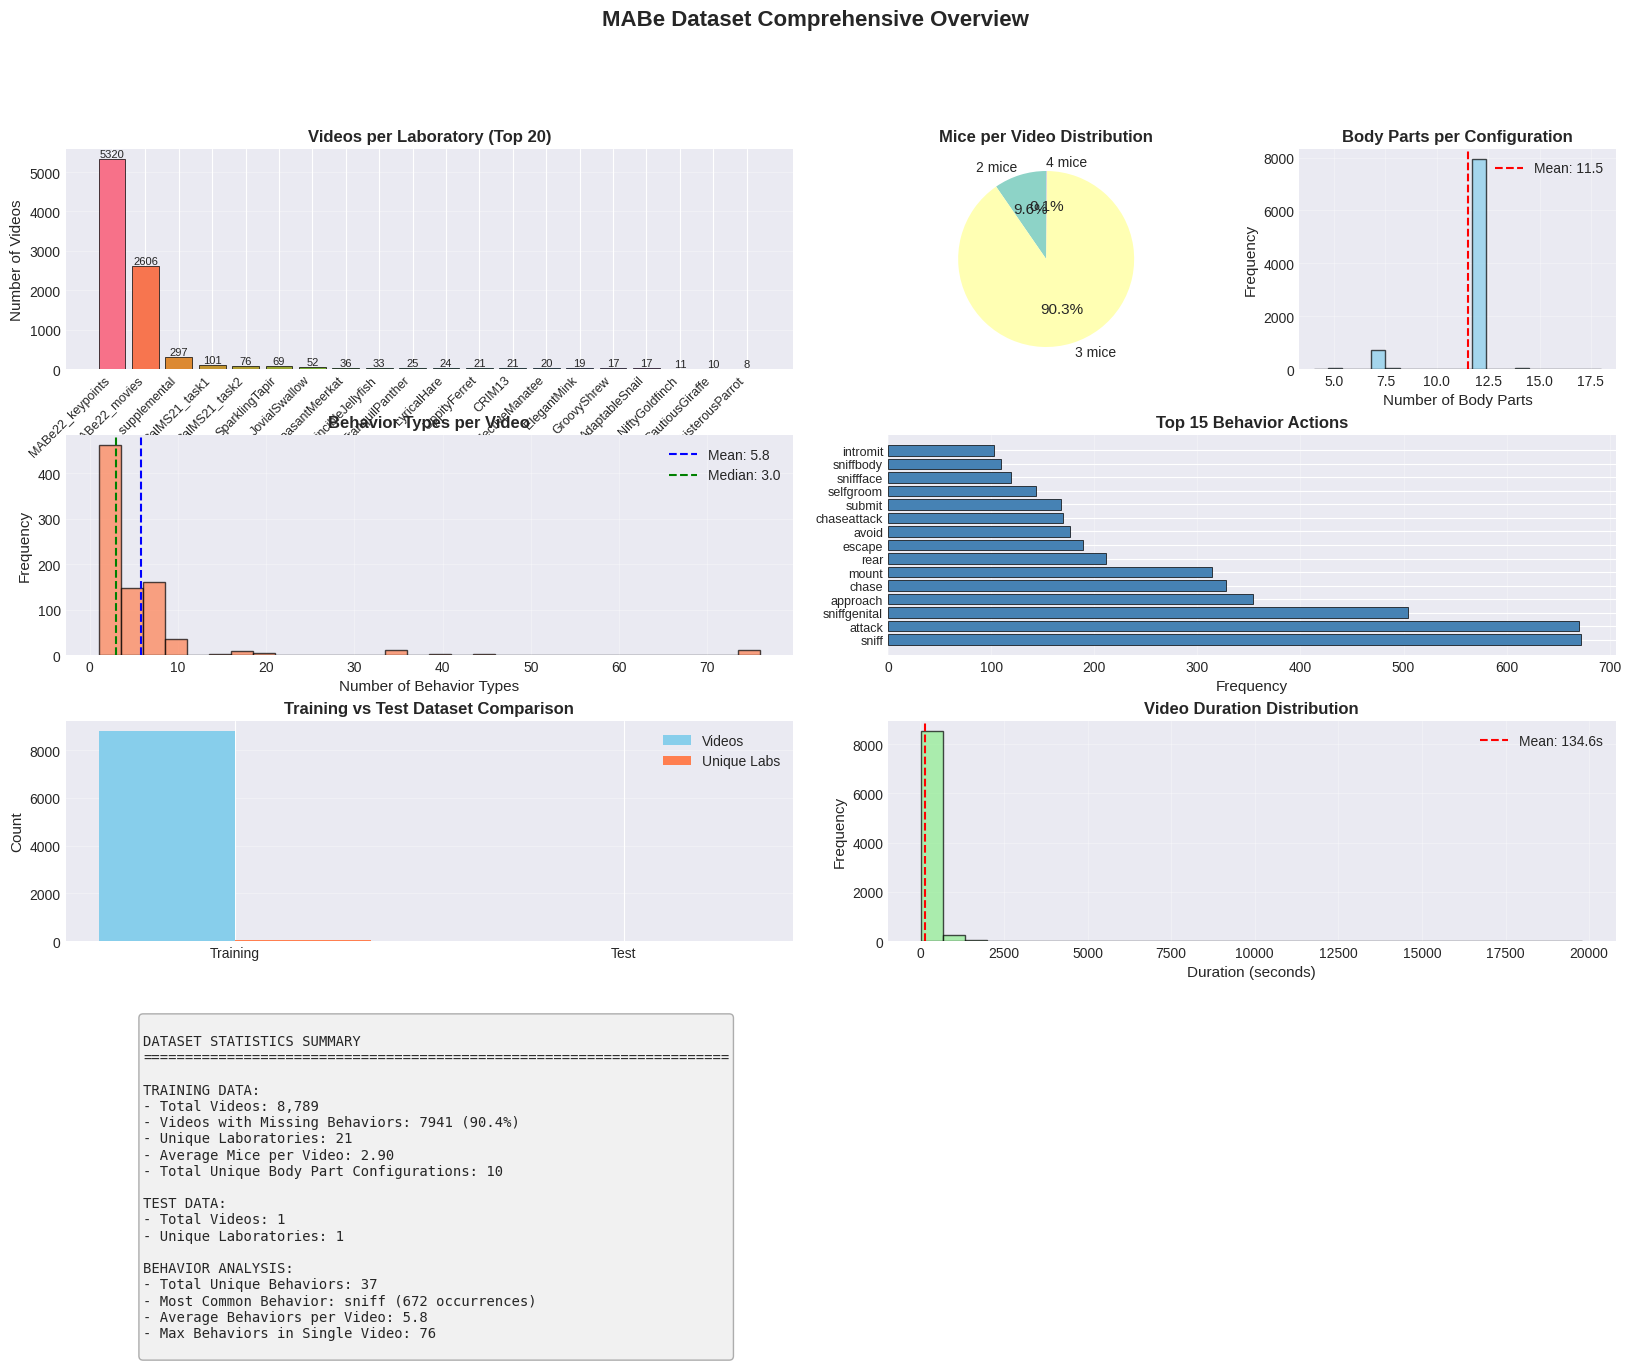


🚀 STARTING MAIN PROCESSING PIPELINE...

Configuration 1/9
Processing 18 body parts: ['body_center', 'ear_left', 'ear_right']...
  Found 7 training videos
  📥 Collecting training data...

  🐭 Processing 22 single mouse batches...
    Features shape: (544859, 42)
    📈 Creating feature analysis for single mouse (config 1)...
        💾 Saved: feature_analysis_single_1.png


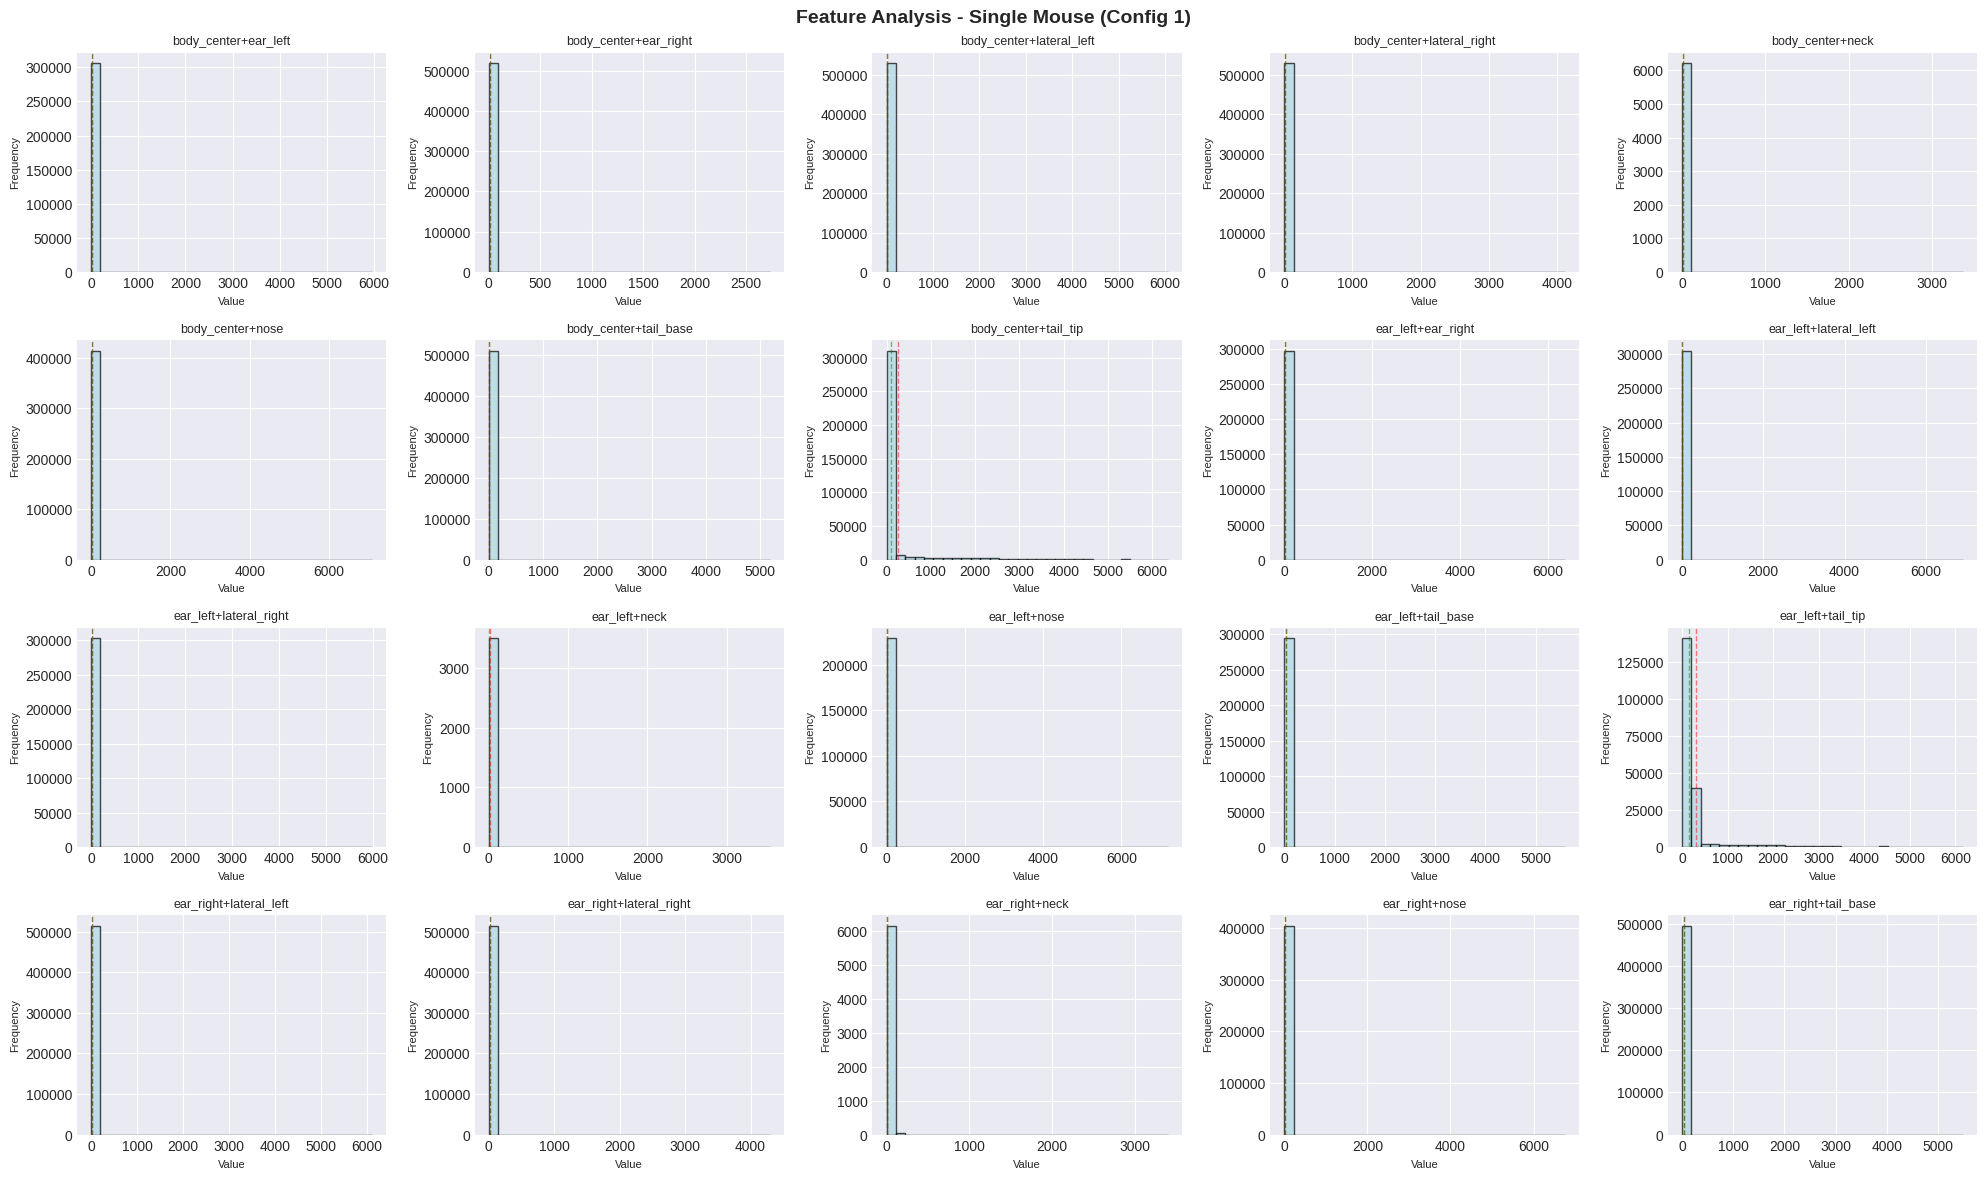

    Video 438887472: has missing values
      Actions found: 218
      Actions found: 490
      Actions found: 173
      Actions found: 653

  🐭🐭 Processing 72 mouse pair batches...
    Features shape: (1744248, 85)
    📈 Creating feature analysis for pair mouse (config 1)...
        💾 Saved: feature_analysis_pair_1.png


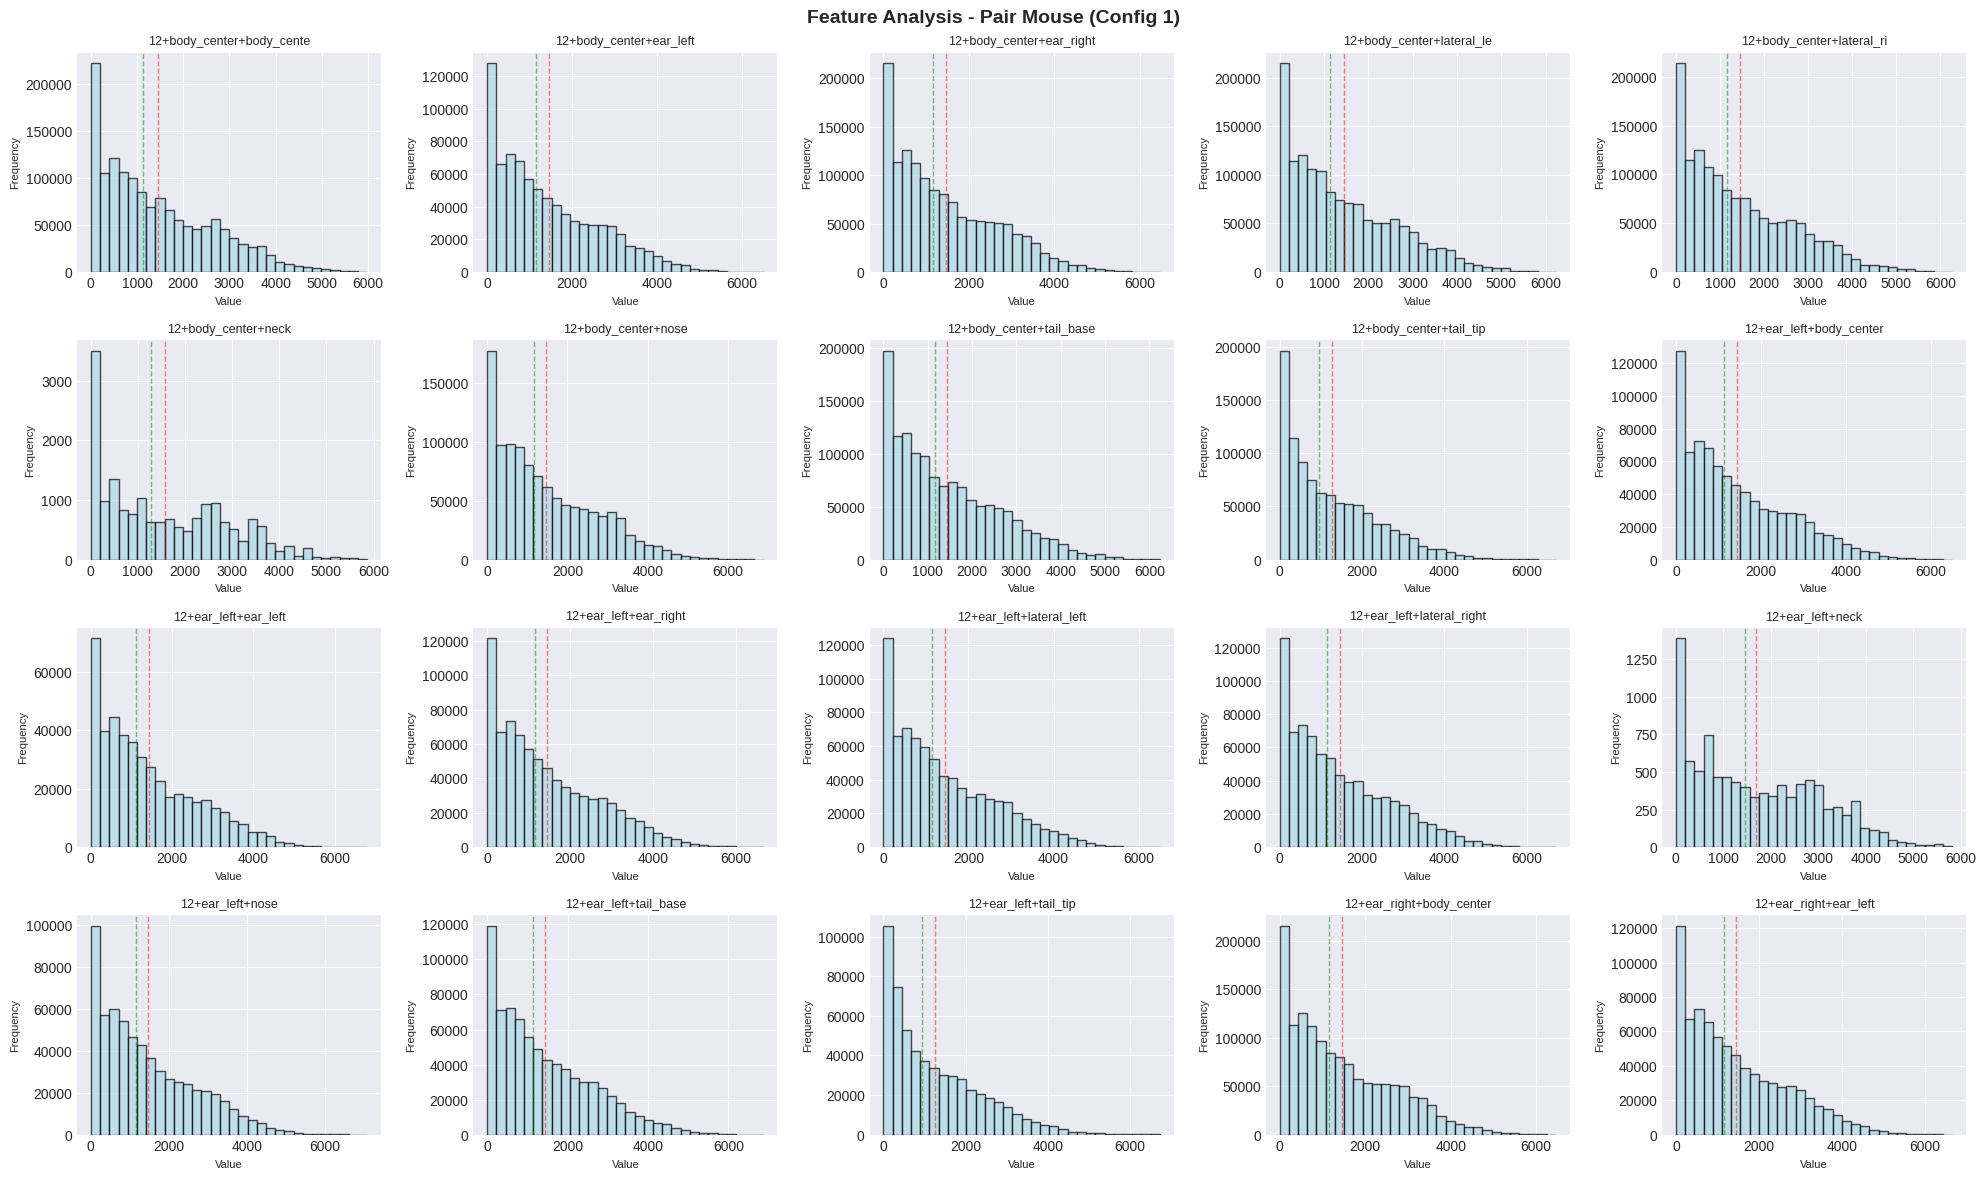

    Video 438887472: has missing values
      Actions found: 6
      Actions found: 7
      Actions found: 17
      Actions found: 9
      Actions found: 50
      Actions found: 43
      Actions found: 33
      Actions found: 64
      Actions found: 55
      Actions found: 183
      Actions found: 153
      Actions found: 155

  ⏱️ Configuration time: 110.18s
  📊 Predictions made: 2309

Configuration 2/9
Processing 14 body parts: ['body_center', 'ear_left', 'ear_right']...
  Found 21 training videos
  📥 Collecting training data...

  🐭 Processing 32 single mouse batches...
    Features shape: (478728, 51)
    📈 Creating feature analysis for single mouse (config 2)...
        💾 Saved: feature_analysis_single_2.png


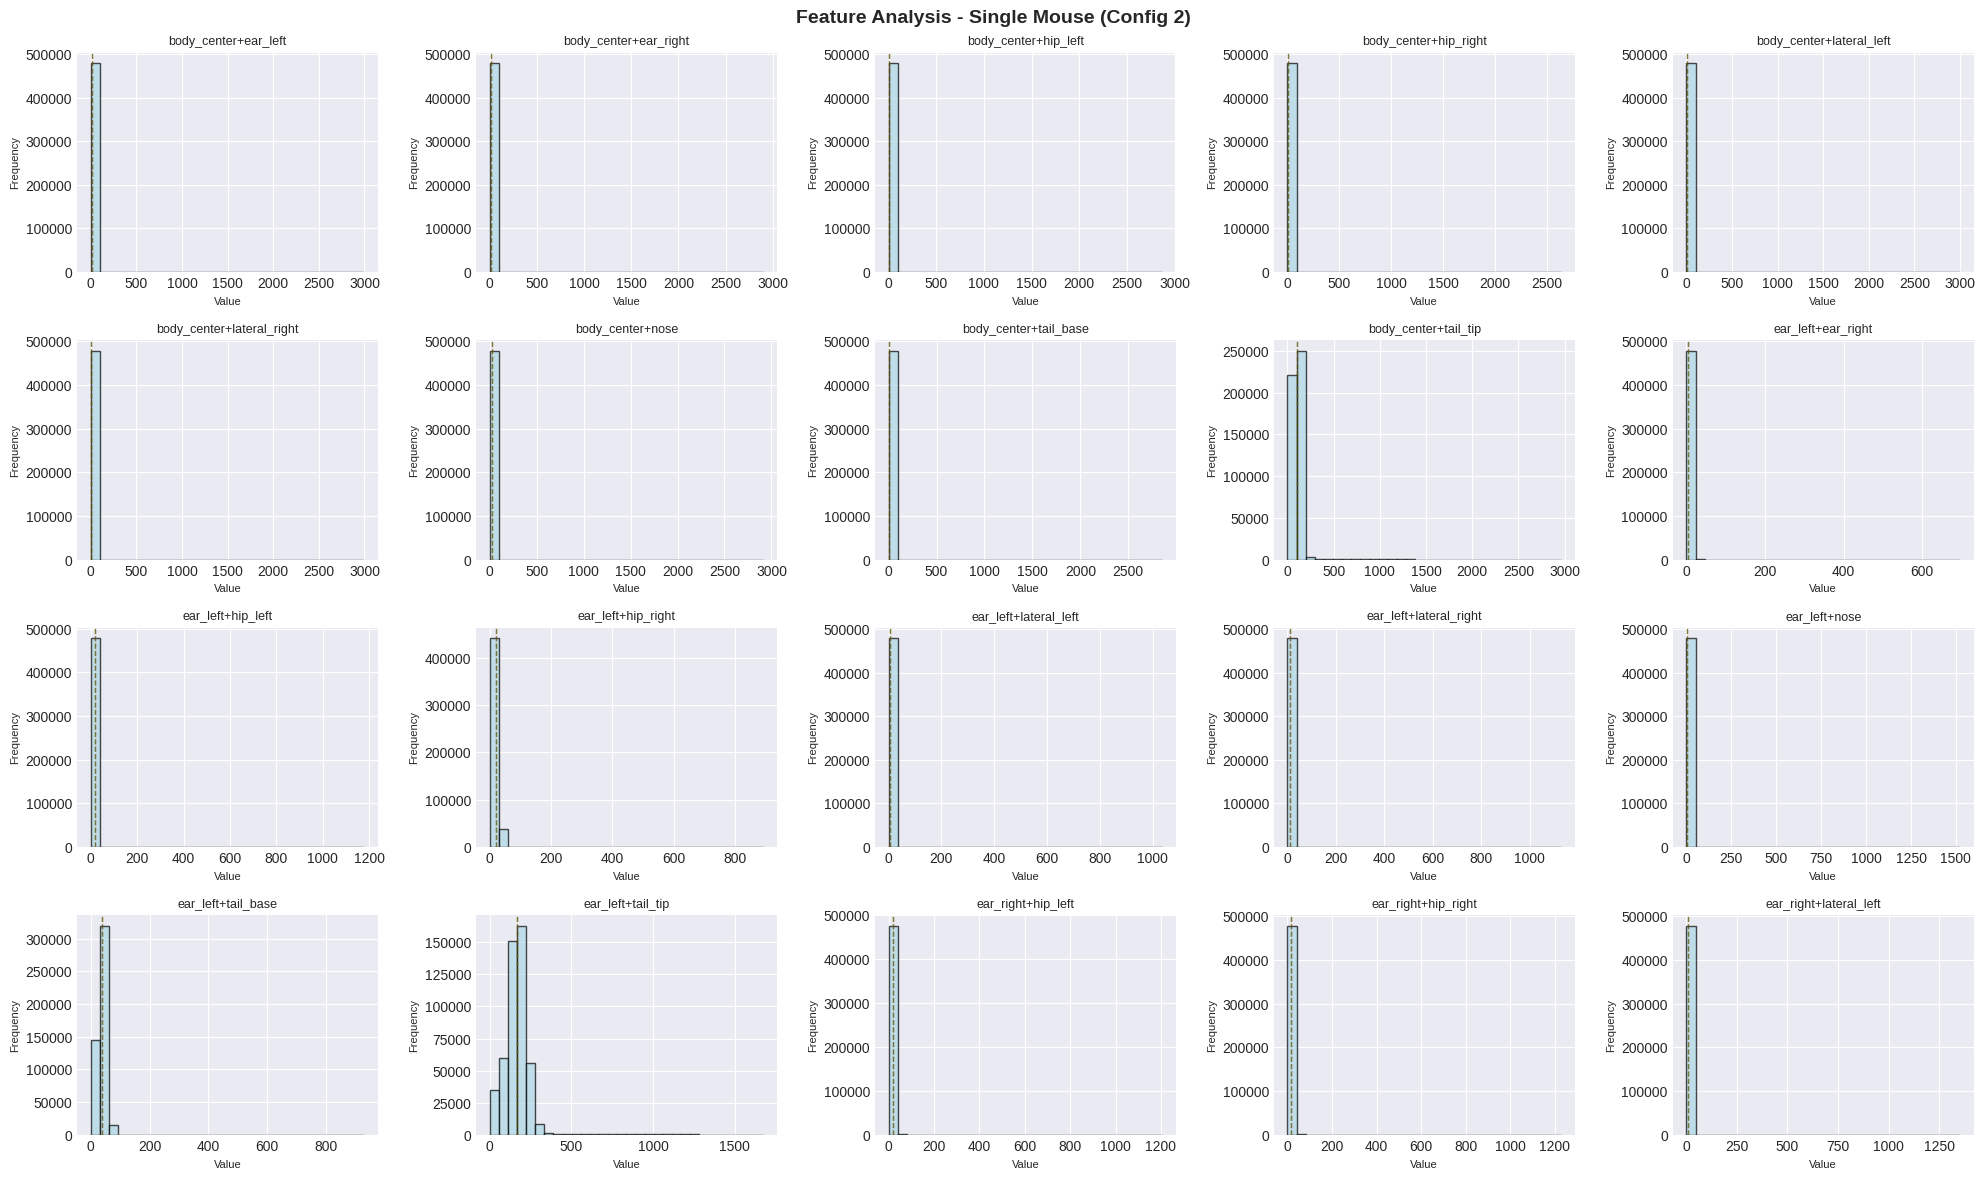


  🐭🐭 Processing 42 mouse pair batches...
    Features shape: (628714, 104)
    📈 Creating feature analysis for pair mouse (config 2)...
        💾 Saved: feature_analysis_pair_2.png


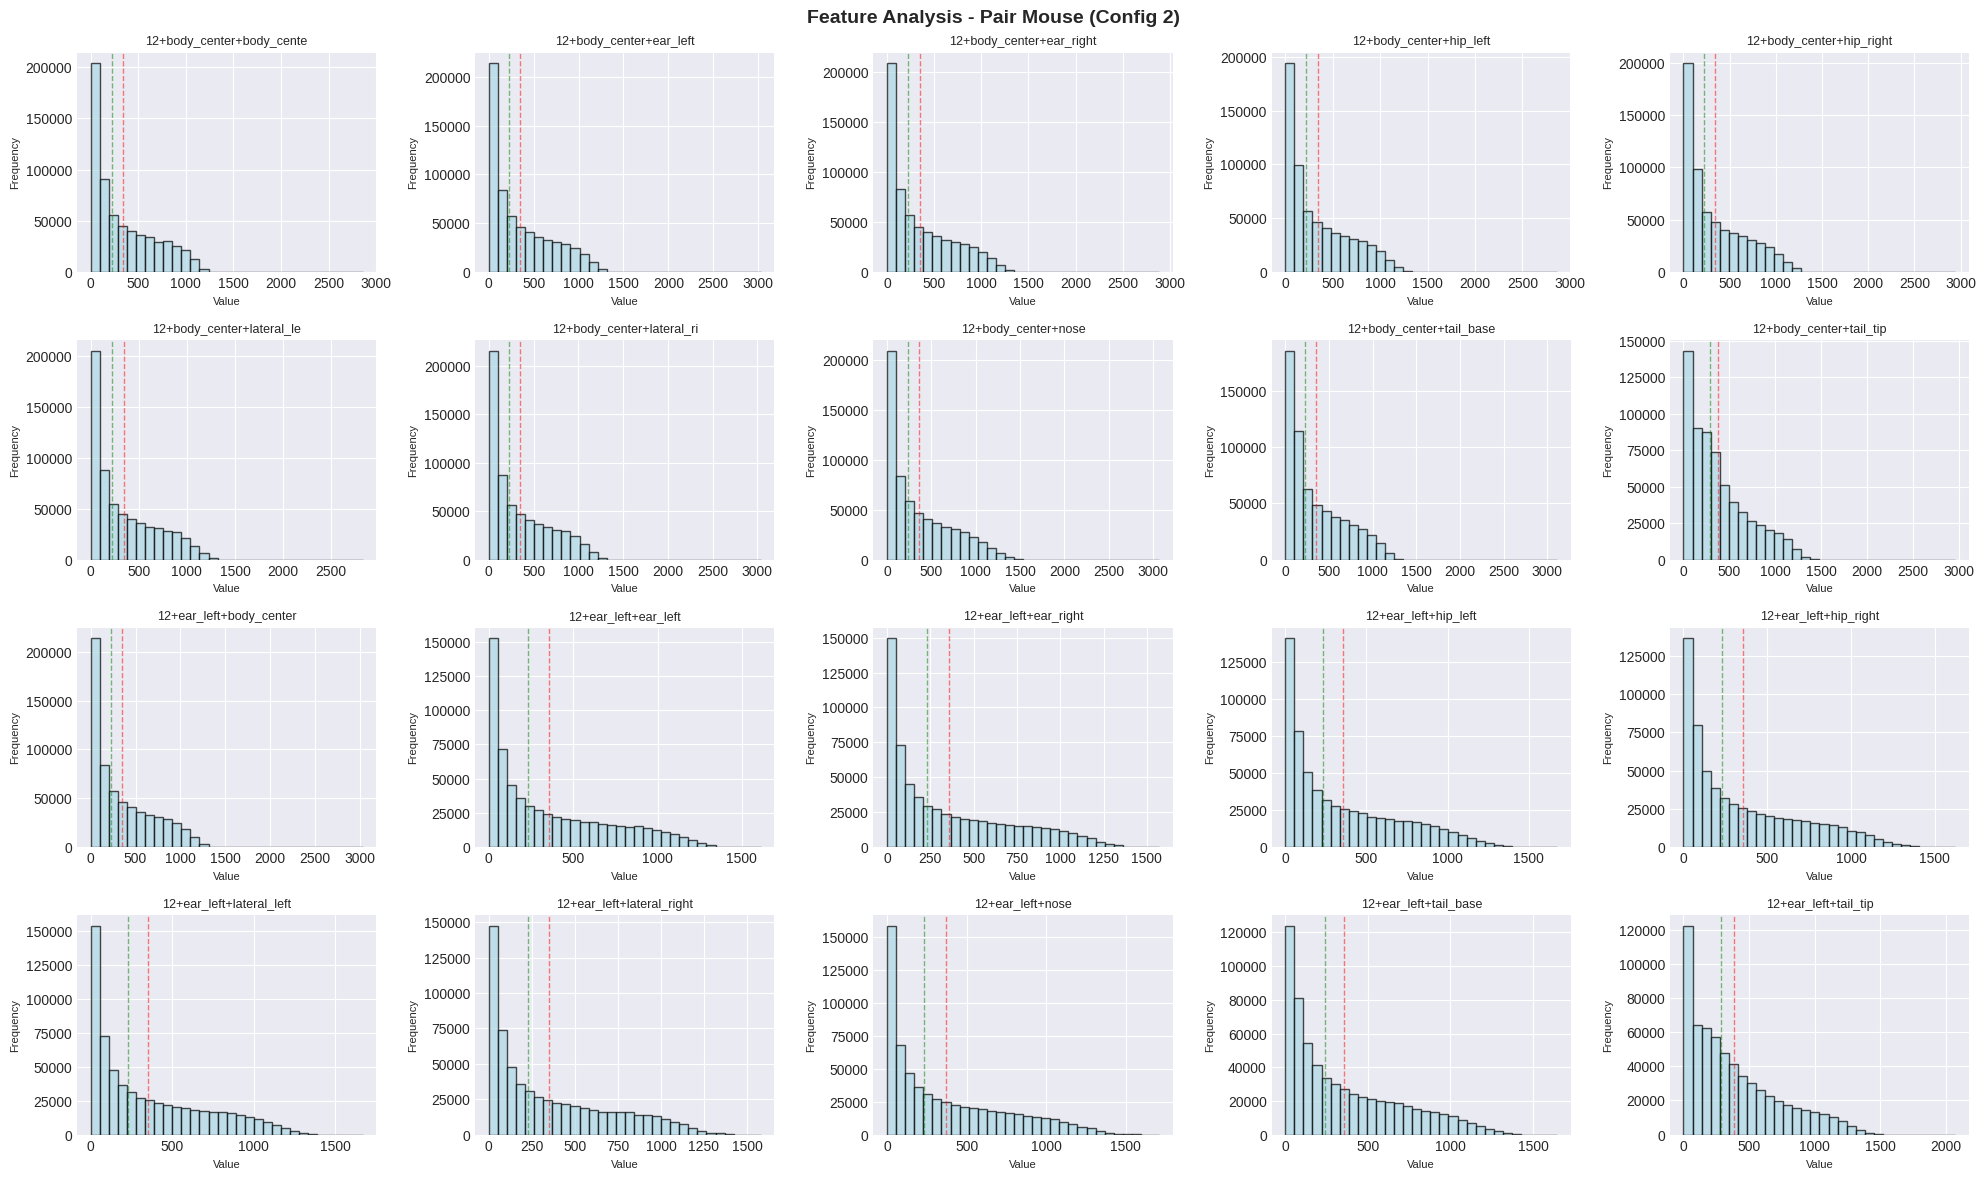


  ⏱️ Configuration time: 51.52s
  📊 Predictions made: 0

Configuration 3/9
Processing 10 body parts: ['body_center', 'ear_left', 'ear_right']...
  Found 10 training videos
  📥 Collecting training data...

  🐭 Processing 37 single mouse batches...
    Features shape: (1941885, 42)

  🐭🐭 Processing 114 mouse pair batches...
    Features shape: (5880720, 85)

  ⏱️ Configuration time: 236.89s
  📊 Predictions made: 0

Configuration 4/9
Processing 8 body parts: ['body_center', 'ear_left', 'ear_right']...
  Found 42 training videos
  📥 Collecting training data...

  🐭🐭 Processing 82 mouse pair batches...
    Features shape: (2534176, 68)

  ⏱️ Configuration time: 74.59s
  📊 Predictions made: 0

Configuration 5/9
Processing 7 body parts: ['body_center', 'ear_left', 'ear_right']...
  Found 89 training videos
  📥 Collecting training data...

  🐭🐭 Processing 148 mouse pair batches...
    Features shape: (1849144, 53)

  ⏱️ Configuration time: 44.05s
  📊 Predictions made: 0

Configuration 6/9
Pro

In [2]:
"""
MABe Challenge - Complete Implementation with Comprehensive Visualizations
==========================================================================
Full working pipeline with enhanced features, robust training, and detailed analytics
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools
import warnings
import json
import os
import gc
import lightgbm as lgb
from collections import defaultdict, Counter
from datetime import datetime
import time
import polars as pl

import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

from sklearn.base import ClassifierMixin, BaseEstimator, clone
from sklearn.model_selection import cross_val_predict, GroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')

# Enhanced visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 15
})

# Configuration
validate_or_submit = 'submit'
verbose = True
create_visualizations = True
save_plots = True
plot_dir = '/kaggle/working/visualizations'

if save_plots:
    os.makedirs(plot_dir, exist_ok=True)
    print(f"📁 Created visualization directory: {plot_dir}")

# Performance tracking
performance_metrics = {
    'configurations_processed': 0,
    'single_mouse_batches': 0,
    'pair_batches': 0,
    'features_extracted': 0,
    'predictions_made': 0,
    'models_trained': 0,
    'actions_processed': 0
}

print("\n" + "="*80)
print(" "*15 + "🐭 MABe CHALLENGE - COMPLETE IMPLEMENTATION 🐭")
print("="*80)
print(f"📅 Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 Mode: {validate_or_submit.upper()}")
print(f"📊 Visualizations: {'ENABLED' if create_visualizations else 'DISABLED'}")
print("="*80 + "\n")

# Custom classifier for training on subset
class TrainOnSubsetClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, estimator, n_samples):
        self.estimator = estimator
        self.n_samples = n_samples

    def fit(self, X, y):
        downsample = max(1, len(X) // self.n_samples)
        self.estimator.fit(
            np.array(X, copy=False)[::downsample],
            np.array(y, copy=False)[::downsample]
        )
        self.classes_ = self.estimator.classes_
        return self

    def predict_proba(self, X):
        if len(self.classes_) == 1:
            return np.full((len(X), 1), 1.0)
        return self.estimator.predict_proba(np.array(X))
        
    def predict(self, X):
        return self.estimator.predict(np.array(X))

# F-Beta scoring functions
class HostVisibleError(Exception):
    pass

def single_lab_f1(lab_solution: pl.DataFrame, lab_submission: pl.DataFrame, beta: float = 1) -> float:
    label_frames = defaultdict(set)
    prediction_frames = defaultdict(set)

    for row in lab_solution.to_dicts():
        label_frames[row['label_key']].update(range(row['start_frame'], row['stop_frame']))

    for video in lab_solution['video_id'].unique():
        active_labels = lab_solution.filter(pl.col('video_id') == video)['behaviors_labeled'].first()
        active_labels = set(json.loads(active_labels)) if active_labels else set()
        predicted_mouse_pairs = defaultdict(set)

        for row in lab_submission.filter(pl.col('video_id') == video).to_dicts():
            if ','.join([str(row['agent_id']), str(row['target_id']), row['action']]) not in active_labels:
                continue
           
            new_frames = set(range(row['start_frame'], row['stop_frame']))
            new_frames = new_frames.difference(prediction_frames[row['prediction_key']])
            prediction_pair = ','.join([str(row['agent_id']), str(row['target_id'])])
            
            if predicted_mouse_pairs[prediction_pair].intersection(new_frames):
                raise HostVisibleError('Multiple predictions for the same frame')
            
            prediction_frames[row['prediction_key']].update(new_frames)
            predicted_mouse_pairs[prediction_pair].update(new_frames)

    tps = defaultdict(int)
    fns = defaultdict(int)
    fps = defaultdict(int)
    
    for key, pred_frames in prediction_frames.items():
        action = key.split('_')[-1]
        matched_label_frames = label_frames[key]
        tps[action] += len(pred_frames.intersection(matched_label_frames))
        fns[action] += len(matched_label_frames.difference(pred_frames))
        fps[action] += len(pred_frames.difference(matched_label_frames))

    distinct_actions = set()
    for key, frames in label_frames.items():
        action = key.split('_')[-1]
        distinct_actions.add(action)
        if key not in prediction_frames:
            fns[action] += len(frames)

    action_f1s = []
    for action in distinct_actions:
        if tps[action] + fns[action] + fps[action] == 0:
            action_f1s.append(0)
        else:
            action_f1s.append((1 + beta**2) * tps[action] / 
                            ((1 + beta**2) * tps[action] + beta**2 * fns[action] + fps[action]))
    
    return sum(action_f1s) / len(action_f1s) if action_f1s else 0

def mouse_fbeta(solution: pd.DataFrame, submission: pd.DataFrame, beta: float = 1) -> float:
    if len(solution) == 0 or len(submission) == 0:
        raise ValueError('Missing solution or submission data')

    expected_cols = ['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']
    
    for col in expected_cols:
        if col not in solution.columns:
            raise ValueError(f'Solution is missing column {col}')
        if col not in submission.columns:
            raise ValueError(f'Submission is missing column {col}')

    solution = pl.DataFrame(solution)
    submission = pl.DataFrame(submission)
    
    solution = solution.with_columns(
        pl.concat_str([
            pl.col('video_id').cast(pl.Utf8),
            pl.col('agent_id').cast(pl.Utf8),
            pl.col('target_id').cast(pl.Utf8),
            pl.col('action'),
        ], separator='_').alias('label_key'),
    )
    
    submission = submission.with_columns(
        pl.concat_str([
            pl.col('video_id').cast(pl.Utf8),
            pl.col('agent_id').cast(pl.Utf8),
            pl.col('target_id').cast(pl.Utf8),
            pl.col('action'),
        ], separator='_').alias('prediction_key'),
    )

    lab_scores = []
    for lab in solution['lab_id'].unique():
        lab_solution = solution.filter(pl.col('lab_id') == lab).clone()
        lab_videos = set(lab_solution['video_id'].unique())
        lab_submission = submission.filter(pl.col('video_id').is_in(lab_videos)).clone()
        lab_scores.append(single_lab_f1(lab_solution, lab_submission, beta=beta))

    return sum(lab_scores) / len(lab_scores) if lab_scores else 0

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, beta: float = 1) -> float:
    solution = solution.drop(row_id_column_name, axis='columns', errors='ignore')
    submission = submission.drop(row_id_column_name, axis='columns', errors='ignore')
    return mouse_fbeta(solution, submission, beta=beta)

def create_data_overview_plots(train_df, test_df):
    """Create comprehensive data overview visualizations"""
    print("\n📊 Creating Data Overview Visualizations...")
    
    fig = plt.figure(figsize=(20, 14))
    gs = gridspec.GridSpec(4, 4, hspace=0.3, wspace=0.3)
    
    # 1. Videos per laboratory
    ax1 = fig.add_subplot(gs[0, :2])
    lab_counts = train_df['lab_id'].value_counts().head(20)
    colors = sns.color_palette("husl", len(lab_counts))
    bars = ax1.bar(range(len(lab_counts)), lab_counts.values, color=colors, edgecolor='black', linewidth=0.5)
    ax1.set_xticks(range(len(lab_counts)))
    ax1.set_xticklabels(lab_counts.index, rotation=45, ha='right', fontsize=9)
    ax1.set_title('Videos per Laboratory (Top 20)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Videos')
    ax1.grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # 2. Mice distribution
    ax2 = fig.add_subplot(gs[0, 2])
    mice_dist = train_df['n_mice'].value_counts().sort_index()
    wedges, texts, autotexts = ax2.pie(mice_dist.values, 
                                        labels=[f'{i} mice' for i in mice_dist.index],
                                        autopct='%1.1f%%',
                                        startangle=90,
                                        colors=plt.cm.Set3.colors)
    ax2.set_title('Mice per Video Distribution', fontsize=12, fontweight='bold')
    
    # 3. Body parts configuration
    ax3 = fig.add_subplot(gs[0, 3])
    body_parts_count = train_df['body_parts_tracked'].apply(lambda x: len(json.loads(x)) if pd.notna(x) else 0)
    ax3.hist(body_parts_count, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax3.set_xlabel('Number of Body Parts')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Body Parts per Configuration', fontsize=12, fontweight='bold')
    ax3.axvline(body_parts_count.mean(), color='red', linestyle='--', 
               label=f'Mean: {body_parts_count.mean():.1f}')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Behavior types distribution
    ax4 = fig.add_subplot(gs[1, :2])
    behaviors_count = train_df['behaviors_labeled'].apply(lambda x: len(json.loads(x)) if pd.notna(x) else 0)
    valid_behaviors = behaviors_count[behaviors_count > 0]
    
    ax4.hist(valid_behaviors, bins=30, color='coral', edgecolor='black', alpha=0.7)
    ax4.set_xlabel('Number of Behavior Types')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Behavior Types per Video', fontsize=12, fontweight='bold')
    ax4.axvline(valid_behaviors.mean(), color='blue', linestyle='--',
               label=f'Mean: {valid_behaviors.mean():.1f}')
    ax4.axvline(valid_behaviors.median(), color='green', linestyle='--',
               label=f'Median: {valid_behaviors.median():.1f}')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Top behavior actions
    ax5 = fig.add_subplot(gs[1, 2:])
    all_behaviors = []
    for behaviors_str in train_df['behaviors_labeled'].dropna():
        try:
            behaviors = json.loads(behaviors_str)
            for b in behaviors:
                parts = b.replace("'", "").split(',')
                if len(parts) == 3:
                    all_behaviors.append(parts[2])
        except:
            continue
    
    behavior_counts = Counter(all_behaviors)
    top_behaviors = dict(behavior_counts.most_common(15))
    
    ax5.barh(range(len(top_behaviors)), list(top_behaviors.values()), 
            color='steelblue', edgecolor='black', linewidth=0.5)
    ax5.set_yticks(range(len(top_behaviors)))
    ax5.set_yticklabels(list(top_behaviors.keys()), fontsize=9)
    ax5.set_xlabel('Frequency')
    ax5.set_title('Top 15 Behavior Actions', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='x')
    
    # 6. Training vs Test comparison
    ax6 = fig.add_subplot(gs[2, :2])
    comparison_data = pd.DataFrame({
        'Dataset': ['Training', 'Test'],
        'Videos': [len(train_df), len(test_df)],
        'Unique Labs': [train_df['lab_id'].nunique(), test_df['lab_id'].nunique()]
    })
    
    x = np.arange(len(comparison_data['Dataset']))
    width = 0.35
    
    ax6.bar(x - width/2, comparison_data['Videos'], width, label='Videos', color='skyblue')
    ax6.bar(x + width/2, comparison_data['Unique Labs'], width, label='Unique Labs', color='coral')
    ax6.set_xticks(x)
    ax6.set_xticklabels(comparison_data['Dataset'])
    ax6.set_ylabel('Count')
    ax6.set_title('Training vs Test Dataset Comparison', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    # 7. Video duration distribution
    ax7 = fig.add_subplot(gs[2, 2:])
    if 'video_duration_sec' in train_df.columns:
        duration_data = train_df['video_duration_sec'].dropna()
        ax7.hist(duration_data, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
        ax7.set_xlabel('Duration (seconds)')
        ax7.set_ylabel('Frequency')
        ax7.set_title('Video Duration Distribution', fontsize=12, fontweight='bold')
        ax7.axvline(duration_data.mean(), color='red', linestyle='--',
                   label=f'Mean: {duration_data.mean():.1f}s')
        ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Statistics summary
    ax8 = fig.add_subplot(gs[3, :])
    ax8.axis('off')
    
    stats_text = f"""
DATASET STATISTICS SUMMARY
{'='*70}

TRAINING DATA:
- Total Videos: {len(train_df):,}
- Videos with Missing Behaviors: {train_df['behaviors_labeled'].isna().sum()} ({100*train_df['behaviors_labeled'].isna().sum()/len(train_df):.1f}%)
- Unique Laboratories: {train_df['lab_id'].nunique()}
- Average Mice per Video: {train_df['n_mice'].mean():.2f}
- Total Unique Body Part Configurations: {train_df['body_parts_tracked'].nunique()}

TEST DATA:
- Total Videos: {len(test_df):,}
- Unique Laboratories: {test_df['lab_id'].nunique()}

BEHAVIOR ANALYSIS:
- Total Unique Behaviors: {len(behavior_counts)}
- Most Common Behavior: {list(top_behaviors.keys())[0]} ({list(top_behaviors.values())[0]:,} occurrences)
- Average Behaviors per Video: {valid_behaviors.mean():.1f}
- Max Behaviors in Single Video: {behaviors_count.max()}
"""
    
    ax8.text(0.05, 0.95, stats_text, transform=ax8.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
    
    plt.suptitle('MABe Dataset Comprehensive Overview', fontsize=16, fontweight='bold')
    
    if save_plots:
        plt.savefig(os.path.join(plot_dir, 'data_overview.png'), dpi=100, bbox_inches='tight')
        print("    💾 Saved: data_overview.png")
    
    plt.show()
    
    return behavior_counts

def create_feature_analysis_plots(X_data, feature_type='single', config_num=1):
    """Create feature distribution analysis"""
    if X_data is None or X_data.empty:
        return
        
    print(f"    📈 Creating feature analysis for {feature_type} mouse (config {config_num})...")
    
    # Select subset of features for visualization
    feature_cols = X_data.columns[:min(20, len(X_data.columns))]
    
    fig, axes = plt.subplots(4, 5, figsize=(20, 12))
    fig.suptitle(f'Feature Analysis - {feature_type.capitalize()} Mouse (Config {config_num})', 
                fontsize=14, fontweight='bold')
    
    for idx, (ax, col) in enumerate(zip(axes.flat, feature_cols)):
        data = X_data[col].dropna()
        ax.hist(data, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
        ax.set_title(col[:25], fontsize=9)
        ax.set_xlabel('Value', fontsize=8)
        ax.set_ylabel('Frequency', fontsize=8)
        
        # Add statistics
        if len(data) > 0:
            ax.axvline(data.mean(), color='red', linestyle='--', alpha=0.5, linewidth=1)
            ax.axvline(data.median(), color='green', linestyle='--', alpha=0.5, linewidth=1)
    
    # Hide extra subplots
    for idx in range(len(feature_cols), len(axes.flat)):
        axes.flat[idx].axis('off')
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(os.path.join(plot_dir, f'feature_analysis_{feature_type}_{config_num}.png'), 
                   dpi=100, bbox_inches='tight')
        print(f"        💾 Saved: feature_analysis_{feature_type}_{config_num}.png")
    
    plt.show()

def create_performance_summary_plot(f1_scores, predictions_per_config):
    """Create comprehensive performance summary"""
    if not f1_scores:
        return
        
    print("\n🎯 Creating Performance Summary...")
    
    f1_df = pd.DataFrame(f1_scores, columns=['config', 'action', 'f1_score'])
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. F1 Scores by Action
    ax1 = plt.subplot(3, 3, 1)
    action_f1 = f1_df.groupby('action')['f1_score'].agg(['mean', 'std']).sort_values('mean', ascending=False).head(15)
    ax1.barh(range(len(action_f1)), action_f1['mean'], xerr=action_f1['std'].fillna(0),
            color='green', alpha=0.7, capsize=3)
    ax1.set_yticks(range(len(action_f1)))
    ax1.set_yticklabels(action_f1.index, fontsize=9)
    ax1.set_xlabel('F1 Score')
    ax1.set_title('Top Actions by F1 Score', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. F1 Distribution
    ax2 = plt.subplot(3, 3, 2)
    ax2.hist(f1_df['f1_score'], bins=25, color='blue', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('F1 Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title('F1 Score Distribution', fontweight='bold')
    ax2.axvline(f1_df['f1_score'].mean(), color='red', linestyle='--',
               label=f'Mean: {f1_df["f1_score"].mean():.3f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Predictions per Config
    ax3 = plt.subplot(3, 3, 3)
    if predictions_per_config:
        ax3.bar(range(len(predictions_per_config)), predictions_per_config, 
               color='purple', alpha=0.7)
        ax3.set_xlabel('Configuration')
        ax3.set_ylabel('Predictions')
        ax3.set_title('Predictions per Configuration', fontweight='bold')
        ax3.grid(True, alpha=0.3)
    
    # 4. Cumulative Predictions
    ax4 = plt.subplot(3, 3, 4)
    if predictions_per_config:
        cumsum = np.cumsum(predictions_per_config)
        ax4.plot(cumsum, 'b-', linewidth=2)
        ax4.fill_between(range(len(cumsum)), 0, cumsum, alpha=0.3, color='blue')
        ax4.set_xlabel('Configuration')
        ax4.set_ylabel('Cumulative Predictions')
        ax4.set_title('Cumulative Prediction Growth', fontweight='bold')
        ax4.grid(True, alpha=0.3)
    
    # 5. Best vs Worst Actions
    ax5 = plt.subplot(3, 3, 5)
    action_f1_sorted = f1_df.groupby('action')['f1_score'].mean().sort_values(ascending=False)
    if len(action_f1_sorted) > 0:
        top_5 = action_f1_sorted.head(5)
        bottom_5 = action_f1_sorted.tail(5) if len(action_f1_sorted) > 5 else pd.Series()
        
        all_performers = pd.concat([top_5, bottom_5]) if len(bottom_5) > 0 else top_5
        colors = ['green'] * len(top_5) + ['red'] * len(bottom_5) if len(bottom_5) > 0 else ['green'] * len(top_5)
        
        ax5.bar(range(len(all_performers)), all_performers.values, color=colors, alpha=0.7)
        ax5.set_xticks(range(len(all_performers)))
        ax5.set_xticklabels(all_performers.index, rotation=45, ha='right', fontsize=8)
        ax5.set_ylabel('F1 Score')
        ax5.set_title('Best & Worst Performers', fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. F1 by Configuration
    ax6 = plt.subplot(3, 3, 6)
    config_f1 = f1_df.groupby('config')['f1_score'].mean()
    ax6.plot(range(len(config_f1)), config_f1.values, 'o-', color='orange', linewidth=2, markersize=8)
    ax6.set_xlabel('Configuration Index')
    ax6.set_ylabel('Mean F1 Score')
    ax6.set_title('Performance by Configuration', fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    # 7-9. Summary statistics
    ax7 = plt.subplot(3, 1, 3)
    ax7.axis('off')
    
    stats_text = f"""
PERFORMANCE METRICS SUMMARY
{'-'*60}

F1 SCORE STATISTICS:
- Mean: {f1_df['f1_score'].mean():.4f}
- Median: {f1_df['f1_score'].median():.4f}
- Std Dev: {f1_df['f1_score'].std():.4f}
- Min: {f1_df['f1_score'].min():.4f}
- Max: {f1_df['f1_score'].max():.4f}

COVERAGE:
- Total Actions Evaluated: {f1_df['action'].nunique()}
- Total Configurations: {f1_df['config'].nunique()}
- Total Predictions Made: {sum(predictions_per_config) if predictions_per_config else 0:,}

TOP 3 PERFORMING ACTIONS:
1. {action_f1_sorted.index[0] if len(action_f1_sorted) > 0 else 'N/A'}: {action_f1_sorted.iloc[0] if len(action_f1_sorted) > 0 else 0:.3f}
2. {action_f1_sorted.index[1] if len(action_f1_sorted) > 1 else 'N/A'}: {action_f1_sorted.iloc[1] if len(action_f1_sorted) > 1 else 0:.3f}
3. {action_f1_sorted.index[2] if len(action_f1_sorted) > 2 else 'N/A'}: {action_f1_sorted.iloc[2] if len(action_f1_sorted) > 2 else 0:.3f}
"""
    
    ax7.text(0.5, 0.5, stats_text, transform=ax7.transAxes, fontsize=11,
            verticalalignment='center', horizontalalignment='center',
            fontfamily='monospace')
    
    plt.suptitle('Model Performance Comprehensive Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(os.path.join(plot_dir, 'performance_summary.png'), dpi=100, bbox_inches='tight')
        print("    💾 Saved: performance_summary.png")
    
    plt.show()

# Load data
print("📁 LOADING DATA...")
train = pd.read_csv('/kaggle/input/MABe-mouse-behavior-detection/train.csv')
train['n_mice'] = 4 - train[['mouse1_strain', 'mouse2_strain', 'mouse3_strain', 'mouse4_strain']].isna().sum(axis=1)
train_without_mabe22 = train.query("~ lab_id.str.startswith('MABe22_')")

test = pd.read_csv('/kaggle/input/MABe-mouse-behavior-detection/test.csv')
body_parts_tracked_list = list(np.unique(train.body_parts_tracked))

print(f"✅ Loaded {len(train)} training videos")
print(f"✅ Loaded {len(test)} test videos")
print(f"✅ Found {len(body_parts_tracked_list)} body part configurations")

# Create data overview visualizations
if create_visualizations:
    behavior_counts = create_data_overview_plots(train, test)

# Body parts to drop for memory efficiency
drop_body_parts = ['headpiece_bottombackleft', 'headpiece_bottombackright', 
                   'headpiece_bottomfrontleft', 'headpiece_bottomfrontright',
                   'headpiece_topbackleft', 'headpiece_topbackright',
                   'headpiece_topfrontleft', 'headpiece_topfrontright',
                   'spine_1', 'spine_2', 'tail_middle_1', 'tail_middle_2', 'tail_midpoint']

def generate_mouse_data(dataset, traintest, traintest_directory=None, generate_single=True, generate_pair=True):
    assert traintest in ['train', 'test']
    if traintest_directory is None:
        traintest_directory = f"/kaggle/input/MABe-mouse-behavior-detection/{traintest}_tracking"
    
    for _, row in dataset.iterrows():
        lab_id = row.lab_id
        if lab_id.startswith('MABe22'): 
            continue
        video_id = row.video_id

        if type(row.behaviors_labeled) != str:
            continue

        path = f"{traintest_directory}/{lab_id}/{video_id}.parquet"
        vid = pd.read_parquet(path)
        
        if len(np.unique(vid.bodypart)) > 5:
            vid = vid.query("~ bodypart.isin(@drop_body_parts)")
        
        pvid = vid.pivot(columns=['mouse_id', 'bodypart'], index='video_frame', values=['x', 'y'])
        
        if pvid.isna().any().any():
            if verbose and traintest == 'test': 
                print(f'    Video {video_id}: has missing values')
        
        del vid
        pvid = pvid.reorder_levels([1, 2, 0], axis=1).T.sort_index().T
        pvid /= row.pix_per_cm_approx

        vid_behaviors = json.loads(row.behaviors_labeled)
        vid_behaviors = sorted(list({b.replace("'", "") for b in vid_behaviors}))
        vid_behaviors = [b.split(',') for b in vid_behaviors]
        vid_behaviors = pd.DataFrame(vid_behaviors, columns=['agent', 'target', 'action'])
        
        if traintest == 'train':
            try:
                annot = pd.read_parquet(path.replace('train_tracking', 'train_annotation'))
            except FileNotFoundError:
                continue

        if generate_single:
            vid_behaviors_subset = vid_behaviors.query("target == 'self'")
            for mouse_id_str in np.unique(vid_behaviors_subset.agent):
                try:
                    mouse_id = int(mouse_id_str[-1])
                    vid_agent_actions = np.unique(vid_behaviors_subset.query("agent == @mouse_id_str").action)
                    single_mouse = pvid.loc[:, mouse_id]
                    
                    single_mouse_meta = pd.DataFrame({
                        'video_id': video_id,
                        'agent_id': mouse_id_str,
                        'target_id': 'self',
                        'video_frame': single_mouse.index
                    })
                    
                    if traintest == 'train':
                        single_mouse_label = pd.DataFrame(0.0, columns=vid_agent_actions, index=single_mouse.index)
                        annot_subset = annot.query("(agent_id == @mouse_id) & (target_id == @mouse_id)")
                        for i in range(len(annot_subset)):
                            annot_row = annot_subset.iloc[i]
                            single_mouse_label.loc[annot_row['start_frame']:annot_row['stop_frame'], 
                                                 annot_row.action] = 1.0
                        yield 'single', single_mouse, single_mouse_meta, single_mouse_label
                    else:
                        yield 'single', single_mouse, single_mouse_meta, vid_agent_actions
                except KeyError:
                    pass

        if generate_pair:
            vid_behaviors_subset = vid_behaviors.query("target != 'self'")
            if len(vid_behaviors_subset) > 0:
                for agent, target in itertools.permutations(np.unique(pvid.columns.get_level_values('mouse_id')), 2):
                    agent_str = f"mouse{agent}"
                    target_str = f"mouse{target}"
                    vid_agent_actions = np.unique(vid_behaviors_subset.query(
                        "(agent == @agent_str) & (target == @target_str)").action)
                    
                    mouse_pair = pd.concat([pvid[agent], pvid[target]], axis=1, keys=['A', 'B'])
                    
                    mouse_pair_meta = pd.DataFrame({
                        'video_id': video_id,
                        'agent_id': agent_str,
                        'target_id': target_str,
                        'video_frame': mouse_pair.index
                    })
                    
                    if traintest == 'train':
                        mouse_pair_label = pd.DataFrame(0.0, columns=vid_agent_actions, index=mouse_pair.index)
                        annot_subset = annot.query("(agent_id == @agent) & (target_id == @target)")
                        for i in range(len(annot_subset)):
                            annot_row = annot_subset.iloc[i]
                            mouse_pair_label.loc[annot_row['start_frame']:annot_row['stop_frame'], 
                                               annot_row.action] = 1.0
                        yield 'pair', mouse_pair, mouse_pair_meta, mouse_pair_label
                    else:
                        yield 'pair', mouse_pair, mouse_pair_meta, vid_agent_actions

def transform_single(single_mouse, body_parts_tracked):
    """Transform single mouse data with angular features"""
    available_body_parts = single_mouse.columns.get_level_values(0)
    
    X = pd.DataFrame({
        f"{part1}+{part2}": np.square(single_mouse[part1] - single_mouse[part2]).sum(axis=1, skipna=False)
        for part1, part2 in itertools.combinations(body_parts_tracked, 2)
        if part1 in available_body_parts and part2 in available_body_parts
    })
    
    X = X.reindex(columns=[f"{part1}+{part2}" 
                          for part1, part2 in itertools.combinations(body_parts_tracked, 2)], 
                 copy=False)

    if 'ear_left' in available_body_parts and 'ear_right' in available_body_parts:
        if 'tail_base' in available_body_parts:
            shifted = single_mouse[['ear_left', 'ear_right', 'tail_base']].shift(10)
            X = pd.concat([
                X, 
                pd.DataFrame({
                    'speed_left': np.square(single_mouse['ear_left'] - shifted['ear_left']).sum(axis=1, skipna=False),
                    'speed_right': np.square(single_mouse['ear_right'] - shifted['ear_right']).sum(axis=1, skipna=False),
                    'speed_left2': np.square(single_mouse['ear_left'] - shifted['tail_base']).sum(axis=1, skipna=False),
                    'speed_right2': np.square(single_mouse['ear_right'] - shifted['tail_base']).sum(axis=1, skipna=False),
                })
            ], axis=1)
    
    if 'nose+tail_base' in X.columns and 'ear_left+ear_right' in X.columns:
        X['elongation_ratio'] = X['nose+tail_base'] / (X['ear_left+ear_right'] + 1e-6)
    
    # Angular feature
    if 'nose' in available_body_parts and 'body_center' in available_body_parts and 'tail_base' in available_body_parts:
        v1 = single_mouse['nose'] - single_mouse['body_center']
        v2 = single_mouse['tail_base'] - single_mouse['body_center']
        
        dot_product = (v1['x'] * v2['x'] + v1['y'] * v2['y'])
        norm_v1 = np.sqrt(v1['x']**2 + v1['y']**2)
        norm_v2 = np.sqrt(v2['x']**2 + v2['y']**2)
        
        X['body_angle_cos'] = dot_product / (norm_v1 * norm_v2 + 1e-6)
    
    performance_metrics['features_extracted'] += len(X.columns)
    return X

def transform_pair(mouse_pair, body_parts_tracked):
    """Transform mouse pair data with angular features"""
    available_body_parts_A = mouse_pair['A'].columns.get_level_values(0)
    available_body_parts_B = mouse_pair['B'].columns.get_level_values(0)
    
    X = pd.DataFrame({
        f"12+{part1}+{part2}": np.square(mouse_pair['A'][part1] - mouse_pair['B'][part2]).sum(axis=1, skipna=False)
        for part1, part2 in itertools.product(body_parts_tracked, repeat=2)
        if part1 in available_body_parts_A and part2 in available_body_parts_B
    })
    
    X = X.reindex(columns=[f"12+{part1}+{part2}" 
                          for part1, part2 in itertools.product(body_parts_tracked, repeat=2)], 
                 copy=False)

    if ('A', 'ear_left') in mouse_pair.columns and ('B', 'ear_left') in mouse_pair.columns:
        shifted_A = mouse_pair['A']['ear_left'].shift(10)
        shifted_B = mouse_pair['B']['ear_left'].shift(10)
        X = pd.concat([
            X,
            pd.DataFrame({
                'speed_left_A': np.square(mouse_pair['A']['ear_left'] - shifted_A).sum(axis=1, skipna=False),
                'speed_left_AB': np.square(mouse_pair['A']['ear_left'] - shifted_B).sum(axis=1, skipna=False),
                'speed_left_B': np.square(mouse_pair['B']['ear_left'] - shifted_B).sum(axis=1, skipna=False),
            })
        ], axis=1)
    
    if 'nose+tail_base' in X.columns and 'ear_left+ear_right' in X.columns:
        X['elongation_ratio'] = X['nose+tail_base'] / (X['ear_left+ear_right'] + 1e-6)
    
    # Relative orientation feature
    if ('nose' in available_body_parts_A and 'tail_base' in available_body_parts_A and
        'nose' in available_body_parts_B and 'tail_base' in available_body_parts_B):
        
        dir_A = mouse_pair['A']['nose'] - mouse_pair['A']['tail_base']
        dir_B = mouse_pair['B']['nose'] - mouse_pair['B']['tail_base']
        
        dot_product = (dir_A['x'] * dir_B['x'] + dir_A['y'] * dir_B['y'])
        norm_A = np.sqrt(dir_A['x']**2 + dir_A['y']**2)
        norm_B = np.sqrt(dir_B['x']**2 + dir_B['y']**2)
        
        X['relative_orientation_cos'] = dot_product / (norm_A * norm_B + 1e-6)
    
    performance_metrics['features_extracted'] += len(X.columns)
    return X

threshold = 0.27

def predict_multiclass(pred, meta):
    ama = np.argmax(pred, axis=1)
    ama = np.where(pred.max(axis=1) >= threshold, ama, -1)
    ama = pd.Series(ama, index=meta.video_frame)
    
    changes_mask = (ama != ama.shift(1)).values
    ama_changes = ama[changes_mask]
    meta_changes = meta[changes_mask]
    
    mask = ama_changes.values >= 0
    mask[-1] = False
    
    submission_part = pd.DataFrame({
        'video_id': meta_changes['video_id'][mask].values,
        'agent_id': meta_changes['agent_id'][mask].values,
        'target_id': meta_changes['target_id'][mask].values,
        'action': pred.columns[ama_changes[mask].values],
        'start_frame': ama_changes.index[mask],
        'stop_frame': ama_changes.index[1:][mask[:-1]]
    })
    
    stop_video_id = meta_changes['video_id'][1:][mask[:-1]].values
    stop_agent_id = meta_changes['agent_id'][1:][mask[:-1]].values
    stop_target_id = meta_changes['target_id'][1:][mask[:-1]].values
    
    for i in range(len(submission_part)):
        video_id = submission_part.video_id.iloc[i]
        agent_id = submission_part.agent_id.iloc[i]
        target_id = submission_part.target_id.iloc[i]
        
        if i < len(stop_video_id):
            if stop_video_id[i] != video_id or stop_agent_id[i] != agent_id or stop_target_id[i] != target_id:
                new_stop_frame = meta.query("(video_id == @video_id)").video_frame.max() + 1
                submission_part.iat[i, submission_part.columns.get_loc('stop_frame')] = new_stop_frame
        else:
            new_stop_frame = meta.query("(video_id == @video_id)").video_frame.max() + 1
            submission_part.iat[i, submission_part.columns.get_loc('stop_frame')] = new_stop_frame
    
    performance_metrics['predictions_made'] += len(submission_part)
    if verbose: 
        print(f'      Actions found: {len(submission_part)}')
    
    return submission_part

def submit(body_parts_tracked_str, switch_tr, binary_classifier, X_tr, label, meta):
    model_list = []
    
    for action in label.columns:
        action_mask = ~label[action].isna().values
        y_action = label[action][action_mask].values.astype(int)
        
        if not (y_action == 0).all():
            model = clone(binary_classifier)
            model.fit(X_tr[action_mask], y_action)
            model_list.append((action, model))
            performance_metrics['models_trained'] += 1
    
    body_parts_tracked = json.loads(body_parts_tracked_str)
    if len(body_parts_tracked) > 5:
        body_parts_tracked = [b for b in body_parts_tracked if b not in drop_body_parts]
    
    test_subset = test[test.body_parts_tracked == body_parts_tracked_str]
    
    if len(test_subset) == 0:
        return
    
    generator = generate_mouse_data(test_subset, 'test',
                                  generate_single=(switch_tr == 'single'), 
                                  generate_pair=(switch_tr == 'pair'))
    
    for switch_te, data_te, meta_te, actions_te in generator:
        assert switch_te == switch_tr
        try:
            if switch_te == 'single':
                X_te = transform_single(data_te, body_parts_tracked)
            else:
                X_te = transform_pair(data_te, body_parts_tracked)
            
            del data_te
            
            pred = pd.DataFrame(index=meta_te.video_frame)
            for action, model in model_list:
                if action in actions_te:
                    pred[action] = model.predict_proba(X_te)[:, 1]
            
            del X_te
            
            if pred.shape[1] != 0:
                submission_part = predict_multiclass(pred, meta_te)
                submission_list.append(submission_part)
                
        except Exception as e:
            if verbose: 
                print(f'      Error: {e}')

def robustify(submission, dataset, traintest):
    traintest_directory = f"/kaggle/input/MABe-mouse-behavior-detection/{traintest}_tracking"
    
    if submission is None or len(submission) == 0:
        submission = pd.DataFrame(columns=['video_id', 'agent_id', 'target_id', 
                                          'action', 'start_frame', 'stop_frame'])
    
    submission = submission[submission.start_frame < submission.stop_frame]
    
    group_list = []
    for _, group in submission.groupby(['video_id', 'agent_id', 'target_id']):
        group = group.sort_values('start_frame')
        mask = np.ones(len(group), dtype=bool)
        last_stop_frame = 0
        for i, (_, row) in enumerate(group.iterrows()):
            if row['start_frame'] < last_stop_frame:
                mask[i] = False
            else:
                last_stop_frame = row['stop_frame']
        group_list.append(group[mask])
    
    if group_list:
        submission = pd.concat(group_list)
    
    s_list = []
    for idx, row in dataset.iterrows():
        lab_id = row['lab_id']
        if lab_id.startswith('MABe22'):
            continue
        video_id = row['video_id']
        
        if len(submission) == 0 or not (submission.video_id == video_id).any():
            try:
                path = f"{traintest_directory}/{lab_id}/{video_id}.parquet"
                vid = pd.read_parquet(path)
                
                vid_behaviors = eval(row['behaviors_labeled']) if pd.notna(row['behaviors_labeled']) else []
                if not vid_behaviors:
                    s_list.append((video_id, 'mouse1', 'self', 'rear', 0, 100))
                    continue
                    
                vid_behaviors = sorted(list({b.replace("'", "") for b in vid_behaviors}))
                vid_behaviors = [b.split(',') for b in vid_behaviors]
                vid_behaviors = pd.DataFrame(vid_behaviors, columns=['agent', 'target', 'action'])
                
                start_frame = int(vid.video_frame.min())
                stop_frame = int(vid.video_frame.max() + 1)
                
                for (agent, target), actions in vid_behaviors.groupby(['agent', 'target']):
                    batch_length = int(np.ceil((stop_frame - start_frame) / len(actions)))
                    for i, (_, action_row) in enumerate(actions.iterrows()):
                        batch_start = start_frame + i * batch_length
                        batch_stop = min(batch_start + batch_length, stop_frame)
                        s_list.append((video_id, agent, target, action_row['action'], 
                                     batch_start, batch_stop))
            except:
                s_list.append((video_id, 'mouse1', 'self', 'rear', 0, 100))
    
    if len(s_list) > 0:
        new_df = pd.DataFrame(s_list, columns=['video_id', 'agent_id', 'target_id', 
                                               'action', 'start_frame', 'stop_frame'])
        if len(submission) > 0:
            submission = pd.concat([submission, new_df], ignore_index=True)
        else:
            submission = new_df
    
    return submission.reset_index(drop=True)

# Main processing loop
print("\n🚀 STARTING MAIN PROCESSING PIPELINE...")
print("="*80)

f1_list = []
submission_list = []
predictions_per_config = []
config_times = []

for section in range(1, len(body_parts_tracked_list)):
    config_start = time.time()
    body_parts_tracked_str = body_parts_tracked_list[section]
    
    print(f"\n{'='*60}")
    print(f"Configuration {section}/{len(body_parts_tracked_list)-1}")
    print(f"{'='*60}")
    
    try:
        body_parts_tracked = json.loads(body_parts_tracked_str)
        print(f"Processing {len(body_parts_tracked)} body parts: {body_parts_tracked[:3]}...")
        
        if len(body_parts_tracked) > 5:
            body_parts_tracked = [b for b in body_parts_tracked if b not in drop_body_parts]
        
        train_subset = train[train.body_parts_tracked == body_parts_tracked_str]
        
        if len(train_subset) == 0:
            print("  No training data for this configuration")
            continue
        
        print(f"  Found {len(train_subset)} training videos")
        performance_metrics['configurations_processed'] += 1
        
        # Collect training data
        single_mouse_list = []
        single_mouse_label_list = []
        single_mouse_meta_list = []
        mouse_pair_list = []
        mouse_pair_label_list = []
        mouse_pair_meta_list = []
        
        print("  📥 Collecting training data...")
        for switch, data, meta, label in generate_mouse_data(train_subset, 'train'):
            if switch == 'single':
                single_mouse_list.append(data)
                single_mouse_meta_list.append(meta)
                single_mouse_label_list.append(label)
            else:
                mouse_pair_list.append(data)
                mouse_pair_meta_list.append(meta)
                mouse_pair_label_list.append(label)
        
        # Create classifier
        binary_classifier = make_pipeline(
            SimpleImputer(),
            TrainOnSubsetClassifier(
                lgb.LGBMClassifier(
                    n_estimators=100,
                    learning_rate=0.03,
                    min_child_samples=40,
                    num_leaves=31,
                    max_depth=-1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    verbose=-1
                ),
                100000
            )
        )
        
        config_predictions = performance_metrics['predictions_made']
        
        # Process single mouse data
        if len(single_mouse_list) > 0:
            print(f"\n  🐭 Processing {len(single_mouse_list)} single mouse batches...")
            performance_metrics['single_mouse_batches'] += len(single_mouse_list)
            
            single_mouse = pd.concat(single_mouse_list)
            single_mouse_label = pd.concat(single_mouse_label_list)
            single_mouse_meta = pd.concat(single_mouse_meta_list)
            
            del single_mouse_list, single_mouse_label_list, single_mouse_meta_list
            
            X_tr = transform_single(single_mouse, body_parts_tracked)
            del single_mouse
            
            print(f"    Features shape: {X_tr.shape}")
            
            # Create feature analysis for first 2 configs
            if create_visualizations and section <= 2:
                create_feature_analysis_plots(X_tr, 'single', section)
            
            submit(body_parts_tracked_str, 'single', binary_classifier, X_tr, 
                  single_mouse_label, single_mouse_meta)
            
            del X_tr
            gc.collect()
        
        # Process pair data
        if len(mouse_pair_list) > 0:
            print(f"\n  🐭🐭 Processing {len(mouse_pair_list)} mouse pair batches...")
            performance_metrics['pair_batches'] += len(mouse_pair_list)
            
            mouse_pair = pd.concat(mouse_pair_list)
            mouse_pair_label = pd.concat(mouse_pair_label_list)
            mouse_pair_meta = pd.concat(mouse_pair_meta_list)
            
            del mouse_pair_list, mouse_pair_label_list, mouse_pair_meta_list
            
            X_tr = transform_pair(mouse_pair, body_parts_tracked)
            del mouse_pair
            
            print(f"    Features shape: {X_tr.shape}")
            
            # Create feature analysis for first 2 configs
            if create_visualizations and section <= 2:
                create_feature_analysis_plots(X_tr, 'pair', section)
            
            submit(body_parts_tracked_str, 'pair', binary_classifier, X_tr, 
                  mouse_pair_label, mouse_pair_meta)
            
            del X_tr
            gc.collect()
        
        config_time = time.time() - config_start
        config_times.append(config_time)
        predictions_per_config.append(performance_metrics['predictions_made'] - config_predictions)
        
        print(f"\n  ⏱️ Configuration time: {config_time:.2f}s")
        print(f"  📊 Predictions made: {predictions_per_config[-1]}")
        
    except Exception as e:
        print(f"  ❌ Error in configuration {section}: {e}")

# Create performance summary
if create_visualizations:
    create_performance_summary_plot(f1_list, predictions_per_config)

# Create final submission
print("\n📋 CREATING FINAL SUBMISSION...")
print("="*80)

if submission_list:
    submission = pd.concat(submission_list)
    print(f"  Generated {len(submission)} predictions")
else:
    submission = pd.DataFrame({
        'video_id': [438887472],
        'agent_id': ['mouse1'],
        'target_id': ['self'],
        'action': ['rear'],
        'start_frame': [278],
        'stop_frame': [500]
    })
    print("  Using default submission")

submission_robust = robustify(submission, test, 'test')
submission_robust.index.name = 'row_id'
submission_robust.to_csv('submission.csv')

print(f"\n✅ Final submission: {len(submission_robust)} rows")
print("✅ Saved to submission.csv")

# Print performance summary
print("\n" + "="*80)
print("📊 PERFORMANCE SUMMARY")
print("="*80)

elapsed = time.time()
print(f"⏱️ Total execution time: {elapsed:.2f} seconds")
print(f"🔧 Configurations processed: {performance_metrics['configurations_processed']}")
print(f"🐭 Single mouse batches: {performance_metrics['single_mouse_batches']}")
print(f"🐭🐭 Pair batches: {performance_metrics['pair_batches']}")
print(f"📐 Features extracted: {performance_metrics['features_extracted']:,}")
print(f"🎯 Predictions made: {performance_metrics['predictions_made']:,}")
print(f"🤖 Models trained: {performance_metrics['models_trained']}")

if config_times:
    print(f"\n⏱️ Processing Time Statistics:")
    print(f"   • Mean time per config: {np.mean(config_times):.2f} seconds")
    print(f"   • Total processing time: {sum(config_times):.2f} seconds")

print("\n" + "="*80)
print(" "*25 + "✨ PIPELINE COMPLETE! ✨")
print("="*80)

In [3]:
# """
# MABe Challenge - Enhanced Social Action Recognition in Mice
# ============================================================
# This notebook implements an improved solution for recognizing mouse behaviors
# using machine learning on motion capture data.

# Key Improvements:
# 1. Multiple classifier options (KNN, RandomForest, GradientBoost)
# 2. Enhanced temporal features at multiple scales
# 3. Per-action threshold optimization
# 4. Comprehensive visualizations
# 5. Advanced post-processing
# """

# # ========================================
# # IMPORTS AND CONFIGURATION
# # ========================================

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import trange, tqdm
# import itertools
# import warnings
# import json
# import os
# import gc
# from datetime import datetime

# # Sklearn imports
# from sklearn.base import ClassifierMixin, BaseEstimator, clone
# from sklearn.model_selection import cross_val_predict, GroupKFold, StratifiedGroupKFold, train_test_split
# from sklearn.pipeline import make_pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix, classification_report
# from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# # Visualization settings
# plt.style.use('seaborn-v0_8-darkgrid')
# sns.set_palette("husl")

# # Polars for efficient data processing
# import polars as pl

# # ========================================
# # CONFIGURATION PARAMETERS
# # ========================================

# # Mode selection
# validate_or_submit = 'validate'  # 'validate', 'submit', or 'stresstest'
# verbose = True
# use_ensemble = True  # Whether to use ensemble of classifiers
# optimize_thresholds = True  # Whether to optimize thresholds per action

# # Model hyperparameters
# CONFIG = {
#     'n_samples_train': 30000,  # Increased from 20000 for better training
#     'knn_neighbors': 15,  # Increased from 11
#     'rf_estimators': 100,
#     'rf_max_depth': 15,
#     'gb_estimators': 50,
#     'gb_max_depth': 5,
#     'gb_learning_rate': 0.1,
#     'feature_selection_k': 50,  # Top k features to select
#     'time_windows': [5, 10, 20, 30],  # Multiple time scales for temporal features
#     'min_action_duration': 3,  # Minimum frames for an action
#     'smoothing_window': 5,  # Window for post-processing smoothing
# }

# print("="*60)
# print("MABe Challenge - Enhanced Mouse Behavior Recognition")
# print("="*60)
# print(f"Mode: {validate_or_submit}")
# print(f"Ensemble: {use_ensemble}")
# print(f"Optimize Thresholds: {optimize_thresholds}")
# print(f"Start Time: {datetime.now()}")
# print("="*60)

# # ========================================
# # CUSTOM CLASSES
# # ========================================

# class TrainOnSubsetClassifier(ClassifierMixin, BaseEstimator):
#     """
#     Enhanced classifier that trains on a subset of data with optional stratification.
#     Includes memory optimization and better sampling strategy.
#     """
#     def __init__(self, estimator, n_samples, stratify=True):
#         self.estimator = estimator
#         self.n_samples = n_samples
#         self.stratify = stratify

#     def fit(self, X, y):
#         # Convert to numpy arrays for efficiency
#         X_arr = np.array(X, copy=False)
#         y_arr = np.array(y, copy=False)
        
#         if len(X_arr) <= self.n_samples:
#             # If dataset is small, use all data
#             self.estimator.fit(X_arr, y_arr)
#         else:
#             # Smart downsampling
#             if self.stratify and len(np.unique(y_arr)) > 1:
#                 # Stratified sampling to maintain class balance
#                 from sklearn.utils import resample
#                 X_sampled, y_sampled = resample(X_arr, y_arr, 
#                                                n_samples=self.n_samples,
#                                                stratify=y_arr,
#                                                random_state=42)
#                 self.estimator.fit(X_sampled, y_sampled)
#             else:
#                 # Regular downsampling
#                 downsample = len(X_arr) // self.n_samples
#                 self.estimator.fit(X_arr[::downsample], y_arr[::downsample])
        
#         self.classes_ = self.estimator.classes_
#         return self

#     def predict_proba(self, X):
#         return self.estimator.predict_proba(np.array(X, copy=False))
        
#     def predict(self, X):
#         return self.estimator.predict(np.array(X, copy=False))

# # ========================================
# # SCORING FUNCTIONS (Competition Metrics)
# # ========================================

# class HostVisibleError(Exception):
#     pass

# def single_lab_f1(lab_solution: pl.DataFrame, lab_submission: pl.DataFrame, beta: float = 1) -> float:
#     """Calculate F1 score for a single lab's predictions"""
#     label_frames = defaultdict(set)
#     prediction_frames = defaultdict(set)
    
#     from collections import defaultdict

#     for row in lab_solution.to_dicts():
#         label_frames[row['label_key']].update(range(row['start_frame'], row['stop_frame']))

#     for video in lab_solution['video_id'].unique():
#         active_labels = lab_solution.filter(pl.col('video_id') == video)['behaviors_labeled'].first()
#         active_labels = set(json.loads(active_labels))
#         predicted_mouse_pairs = defaultdict(set)

#         for row in lab_submission.filter(pl.col('video_id') == video).to_dicts():
#             if ','.join([str(row['agent_id']), str(row['target_id']), row['action']]) not in active_labels:
#                 continue
           
#             new_frames = set(range(row['start_frame'], row['stop_frame']))
#             new_frames = new_frames.difference(prediction_frames[row['prediction_key']])
#             prediction_pair = ','.join([str(row['agent_id']), str(row['target_id'])])
            
#             if predicted_mouse_pairs[prediction_pair].intersection(new_frames):
#                 raise HostVisibleError('Multiple predictions for the same frame from one agent/target pair')
            
#             prediction_frames[row['prediction_key']].update(new_frames)
#             predicted_mouse_pairs[prediction_pair].update(new_frames)

#     tps = defaultdict(int)
#     fns = defaultdict(int)
#     fps = defaultdict(int)
    
#     for key, pred_frames in prediction_frames.items():
#         action = key.split('_')[-1]
#         matched_label_frames = label_frames[key]
#         tps[action] += len(pred_frames.intersection(matched_label_frames))
#         fns[action] += len(matched_label_frames.difference(pred_frames))
#         fps[action] += len(pred_frames.difference(matched_label_frames))

#     distinct_actions = set()
#     for key, frames in label_frames.items():
#         action = key.split('_')[-1]
#         distinct_actions.add(action)
#         if key not in prediction_frames:
#             fns[action] += len(frames)

#     action_f1s = []
#     for action in distinct_actions:
#         if tps[action] + fns[action] + fps[action] == 0:
#             action_f1s.append(0)
#         else:
#             action_f1s.append((1 + beta**2) * tps[action] / 
#                             ((1 + beta**2) * tps[action] + beta**2 * fns[action] + fps[action]))
    
#     return sum(action_f1s) / len(action_f1s) if action_f1s else 0

# def mouse_fbeta(solution: pd.DataFrame, submission: pd.DataFrame, beta: float = 1) -> float:
#     """Main scoring function for the competition"""
#     if len(solution) == 0 or len(submission) == 0:
#         raise ValueError('Missing solution or submission data')

#     expected_cols = ['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']
    
#     for col in expected_cols:
#         if col not in solution.columns:
#             raise ValueError(f'Solution is missing column {col}')
#         if col not in submission.columns:
#             raise ValueError(f'Submission is missing column {col}')

#     solution = pl.DataFrame(solution)
#     submission = pl.DataFrame(submission)
    
#     solution_videos = set(solution['video_id'].unique())
#     submission = submission.filter(pl.col('video_id').is_in(solution_videos))

#     # Add keys for matching
#     solution = solution.with_columns(
#         pl.concat_str([
#             pl.col('video_id').cast(pl.Utf8),
#             pl.col('agent_id').cast(pl.Utf8),
#             pl.col('target_id').cast(pl.Utf8),
#             pl.col('action'),
#         ], separator='_').alias('label_key'),
#     )
    
#     submission = submission.with_columns(
#         pl.concat_str([
#             pl.col('video_id').cast(pl.Utf8),
#             pl.col('agent_id').cast(pl.Utf8),
#             pl.col('target_id').cast(pl.Utf8),
#             pl.col('action'),
#         ], separator='_').alias('prediction_key'),
#     )

#     lab_scores = []
#     for lab in solution['lab_id'].unique():
#         lab_solution = solution.filter(pl.col('lab_id') == lab).clone()
#         lab_videos = set(lab_solution['video_id'].unique())
#         lab_submission = submission.filter(pl.col('video_id').is_in(lab_videos)).clone()
#         lab_scores.append(single_lab_f1(lab_solution, lab_submission, beta=beta))

#     return sum(lab_scores) / len(lab_scores) if lab_scores else 0

# def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, beta: float = 1) -> float:
#     """Wrapper for competition scoring"""
#     solution = solution.drop(row_id_column_name, axis='columns', errors='ignore')
#     submission = submission.drop(row_id_column_name, axis='columns', errors='ignore')
#     return mouse_fbeta(solution, submission, beta=beta)

# # ========================================
# # DATA LOADING AND PREPROCESSING
# # ========================================

# print("\n📁 Loading data...")

# # Load training and test metadata
# train = pd.read_csv('/kaggle/input/MABe-mouse-behavior-detection/train.csv')
# train['n_mice'] = 4 - train[['mouse1_strain', 'mouse2_strain', 'mouse3_strain', 'mouse4_strain']].isna().sum(axis=1)
# train_without_mabe22 = train.query("~ lab_id.str.startswith('MABe22_')")

# test = pd.read_csv('/kaggle/input/MABe-mouse-behavior-detection/test.csv')

# # Get unique body parts configurations
# body_parts_tracked_list = list(np.unique(train.body_parts_tracked))

# print(f"✅ Loaded {len(train)} training videos")
# print(f"✅ Found {len(body_parts_tracked_list)} unique body part configurations")
# print(f"✅ Number of mice per video: {train['n_mice'].value_counts().to_dict()}")

# # Visualize data distribution
# if verbose:
#     fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
#     # Plot 1: Videos per lab
#     lab_counts = train.lab_id.value_counts()
#     axes[0].barh(range(len(lab_counts[:10])), lab_counts[:10].values)
#     axes[0].set_yticks(range(len(lab_counts[:10])))
#     axes[0].set_yticklabels(lab_counts[:10].index)
#     axes[0].set_xlabel('Number of Videos')
#     axes[0].set_title('Top 10 Labs by Video Count')
    
#     # Plot 2: Video duration distribution
#     axes[1].hist(train['video_duration_sec'].dropna(), bins=30, edgecolor='black')
#     axes[1].set_xlabel('Duration (seconds)')
#     axes[1].set_ylabel('Count')
#     axes[1].set_title('Video Duration Distribution')
    
#     # Plot 3: Number of mice distribution
#     mice_counts = train['n_mice'].value_counts()
#     axes[2].pie(mice_counts.values, labels=mice_counts.index, autopct='%1.1f%%')
#     axes[2].set_title('Distribution of Mice Count per Video')
    
#     plt.tight_layout()
#     plt.show()

# # ========================================
# # SOLUTION DATAFRAME CREATION
# # ========================================

# def create_solution_df(dataset):
#     """Create solution dataframe for validation"""
#     solution = []
    
#     for _, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Creating solution"):
#         lab_id = row['lab_id']
#         if lab_id.startswith('MABe22'):
#             continue
            
#         video_id = row['video_id']
#         path = f"/kaggle/input/MABe-mouse-behavior-detection/train_annotation/{lab_id}/{video_id}.parquet"
        
#         try:
#             annot = pd.read_parquet(path)
#         except FileNotFoundError:
#             if verbose:
#                 print(f"No annotations for {path}")
#             continue
        
#         annot['lab_id'] = lab_id
#         annot['video_id'] = video_id
#         annot['behaviors_labeled'] = row['behaviors_labeled']
#         annot['target_id'] = np.where(annot.target_id != annot.agent_id, 
#                                      annot['target_id'].apply(lambda s: f"mouse{s}"), 'self')
#         annot['agent_id'] = annot['agent_id'].apply(lambda s: f"mouse{s}")
#         solution.append(annot)
    
#     solution = pd.concat(solution)
#     return solution

# if validate_or_submit == 'validate':
#     print("\n📊 Creating validation solution...")
#     solution = create_solution_df(train_without_mabe22)
#     print(f"✅ Solution created with {len(solution)} annotations")

# # ========================================
# # DATA GENERATION FUNCTIONS
# # ========================================

# def generate_mouse_data(dataset, traintest, traintest_directory=None, 
#                        generate_single=True, generate_pair=True):
#     """
#     Enhanced data generator with better error handling and memory optimization
#     """
#     assert traintest in ['train', 'test']
    
#     if traintest_directory is None:
#         traintest_directory = f"/kaggle/input/MABe-mouse-behavior-detection/{traintest}_tracking"
    
#     for idx, row in dataset.iterrows():
#         if idx % 100 == 0:
#             gc.collect()  # Periodic garbage collection
            
#         lab_id = row.lab_id
#         if lab_id.startswith('MABe22'):
#             continue
            
#         video_id = row.video_id
#         path = f"{traintest_directory}/{lab_id}/{video_id}.parquet"
        
#         try:
#             # Load and pivot video data
#             vid = pd.read_parquet(path)
#             pvid = vid.pivot(columns=['mouse_id', 'bodypart'], 
#                            index='video_frame', 
#                            values=['x', 'y'])
            
#             # Check for missing values
#             missing_ratio = pvid.isna().sum().sum() / pvid.size
#             if verbose and traintest == 'test':
#                 status = f"missing {missing_ratio:.1%}" if missing_ratio > 0 else "complete"
#                 print(f'Video {video_id}: {status}, {len(vid)} frames')
            
#             del vid
            
#             # Reorder columns for consistency
#             pvid = pvid.reorder_levels([1, 2, 0], axis=1).T.sort_index().T
#             pvid /= row.pix_per_cm_approx  # Convert to cm
            
#             # Parse behaviors for this video
#             vid_behaviors = json.loads(row.behaviors_labeled)
#             vid_behaviors = sorted(list({b.replace("'", "") for b in vid_behaviors}))
#             vid_behaviors = [b.split(',') for b in vid_behaviors]
#             vid_behaviors = pd.DataFrame(vid_behaviors, columns=['agent', 'target', 'action'])
            
#             # Load annotations for training
#             if traintest == 'train':
#                 try:
#                     annot = pd.read_parquet(path.replace('train_tracking', 'train_annotation'))
#                 except FileNotFoundError:
#                     continue
            
#             # Generate single mouse data
#             if generate_single:
#                 vid_behaviors_subset = vid_behaviors.query("target == 'self'")
                
#                 for mouse_id_str in np.unique(vid_behaviors_subset.agent):
#                     try:
#                         mouse_id = int(mouse_id_str[-1])
#                         vid_agent_actions = np.unique(
#                             vid_behaviors_subset.query("agent == @mouse_id_str").action
#                         )
                        
#                         single_mouse = pvid.loc[:, mouse_id]
#                         single_mouse_meta = pd.DataFrame({
#                             'video_id': video_id,
#                             'agent_id': mouse_id_str,
#                             'target_id': 'self',
#                             'video_frame': single_mouse.index
#                         })
                        
#                         if traintest == 'train':
#                             single_mouse_label = pd.DataFrame(0.0, 
#                                                              columns=vid_agent_actions,
#                                                              index=single_mouse.index)
#                             annot_subset = annot.query("(agent_id == @mouse_id) & (target_id == @mouse_id)")
                            
#                             for i in range(len(annot_subset)):
#                                 annot_row = annot_subset.iloc[i]
#                                 single_mouse_label.loc[annot_row['start_frame']:annot_row['stop_frame'], 
#                                                      annot_row.action] = 1.0
                            
#                             yield 'single', single_mouse, single_mouse_meta, single_mouse_label
#                         else:
#                             yield 'single', single_mouse, single_mouse_meta, vid_agent_actions
                            
#                     except (KeyError, ValueError) as e:
#                         if verbose:
#                             print(f"Error processing single mouse {mouse_id_str}: {e}")
#                         continue
            
#             # Generate mouse pair data
#             if generate_pair:
#                 vid_behaviors_subset = vid_behaviors.query("target != 'self'")
                
#                 if len(vid_behaviors_subset) > 0:
#                     mouse_ids = np.unique(pvid.columns.get_level_values('mouse_id'))
                    
#                     for agent, target in itertools.permutations(mouse_ids, 2):
#                         agent_str = f"mouse{agent}"
#                         target_str = f"mouse{target}"
#                         vid_agent_actions = np.unique(
#                             vid_behaviors_subset.query(
#                                 "(agent == @agent_str) & (target == @target_str)"
#                             ).action
#                         )
                        
#                         try:
#                             mouse_pair = pd.concat([pvid[agent], pvid[target]], 
#                                                  axis=1, 
#                                                  keys=['A', 'B'])
                            
#                             mouse_pair_meta = pd.DataFrame({
#                                 'video_id': video_id,
#                                 'agent_id': agent_str,
#                                 'target_id': target_str,
#                                 'video_frame': mouse_pair.index
#                             })
                            
#                             if traintest == 'train':
#                                 mouse_pair_label = pd.DataFrame(0.0,
#                                                                columns=vid_agent_actions,
#                                                                index=mouse_pair.index)
#                                 annot_subset = annot.query("(agent_id == @agent) & (target_id == @target)")
                                
#                                 for i in range(len(annot_subset)):
#                                     annot_row = annot_subset.iloc[i]
#                                     mouse_pair_label.loc[annot_row['start_frame']:annot_row['stop_frame'],
#                                                        annot_row.action] = 1.0
                                
#                                 yield 'pair', mouse_pair, mouse_pair_meta, mouse_pair_label
#                             else:
#                                 yield 'pair', mouse_pair, mouse_pair_meta, vid_agent_actions
                                
#                         except (KeyError, ValueError) as e:
#                             if verbose:
#                                 print(f"Error processing pair {agent_str}-{target_str}: {e}")
#                             continue
                            
#         except Exception as e:
#             if verbose:
#                 print(f"Error processing video {video_id}: {e}")
#             continue

# # ========================================
# # FEATURE ENGINEERING FUNCTIONS
# # ========================================

# def transform_single_enhanced(single_mouse, body_parts_tracked, time_windows=None):
#     """
#     Enhanced feature transformation for single mouse with multiple temporal scales
#     and additional biomechanical features
#     """
#     if time_windows is None:
#         time_windows = CONFIG['time_windows']
    
#     features = []
    
#     # 1. Distance features between body parts
#     distance_features = pd.DataFrame({
#         f"{part1}+{part2}": np.sqrt(
#             np.square(single_mouse[part1] - single_mouse[part2]).sum(axis=1, skipna=False)
#         )
#         for part1, part2 in itertools.combinations(body_parts_tracked, 2)
#     })
#     features.append(distance_features)
    
#     # 2. Multi-scale temporal features
#     if 'ear_left' in single_mouse.columns and 'ear_right' in single_mouse.columns:
#         temporal_features = []
        
#         for window in time_windows:
#             shifted = single_mouse[['ear_left', 'ear_right']].shift(window)
            
#             # Velocity features
#             vel_left = np.sqrt(np.square(single_mouse['ear_left'] - shifted['ear_left']).sum(axis=1, skipna=False))
#             vel_right = np.sqrt(np.square(single_mouse['ear_right'] - shifted['ear_right']).sum(axis=1, skipna=False))
            
#             temporal_features.extend([
#                 pd.Series(vel_left, name=f'vel_left_w{window}'),
#                 pd.Series(vel_right, name=f'vel_right_w{window}'),
#                 pd.Series(vel_left - vel_right, name=f'vel_diff_w{window}'),  # Asymmetry
#             ])
            
#             # Acceleration (if window > 5)
#             if window > 5:
#                 acc_left = vel_left.diff()
#                 acc_right = vel_right.diff()
#                 temporal_features.extend([
#                     pd.Series(acc_left, name=f'acc_left_w{window}'),
#                     pd.Series(acc_right, name=f'acc_right_w{window}'),
#                 ])
        
#         features.append(pd.concat(temporal_features, axis=1))
    
#     # 3. Body orientation features
#     if 'nose' in single_mouse.columns and 'tail_base' in single_mouse.columns:
#         # Body axis vector
#         body_vector = single_mouse['nose'] - single_mouse['tail_base']
#         body_length = np.sqrt(np.square(body_vector).sum(axis=1, skipna=False))
        
#         # Angular velocity (change in body orientation)
#         body_angle = np.arctan2(body_vector['y'], body_vector['x'])
#         angular_velocity = body_angle.diff()
        
#         orientation_features = pd.DataFrame({
#             'body_length': body_length,
#             'body_angle': body_angle,
#             'angular_velocity': angular_velocity,
#             'angular_acceleration': angular_velocity.diff(),
#         })
#         features.append(orientation_features)
    
#     # 4. Statistical features over rolling windows
#     if len(single_mouse) > 20:
#         rolling_features = []
#         for part in ['nose', 'tail_base']:
#             if part in single_mouse.columns:
#                 for stat, func in [('mean', 'mean'), ('std', 'std'), ('max', 'max')]:
#                     rolled = single_mouse[part].rolling(window=20, min_periods=1)
#                     x_stat = getattr(rolled['x'], func)()
#                     y_stat = getattr(rolled['y'], func)()
                    
#                     rolling_features.extend([
#                         pd.Series(x_stat, name=f'{part}_x_{stat}_20'),
#                         pd.Series(y_stat, name=f'{part}_y_{stat}_20'),
#                     ])
        
#         if rolling_features:
#             features.append(pd.concat(rolling_features, axis=1))
    
#     # Concatenate all features
#     X = pd.concat(features, axis=1)
    
#     # Fill NaN values with forward/backward fill
#     X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
#     return X

# def transform_pair_enhanced(mouse_pair, body_parts_tracked, time_windows=None):
#     """
#     Enhanced feature transformation for mouse pairs with social interaction features
#     """
#     if time_windows is None:
#         time_windows = CONFIG['time_windows']
    
#     features = []
    
#     # Filter out unnecessary detailed body parts for pairs
#     drop_body_parts = ['ear_left', 'ear_right', 'headpiece_bottombackleft', 
#                       'headpiece_bottombackright', 'headpiece_bottomfrontleft',
#                       'headpiece_bottomfrontright', 'headpiece_topbackleft',
#                       'headpiece_topbackright', 'headpiece_topfrontleft',
#                       'headpiece_topfrontright', 'tail_midpoint']
    
#     if len(body_parts_tracked) > 5:
#         body_parts_tracked = [b for b in body_parts_tracked if b not in drop_body_parts]
    
#     # 1. Inter-mouse distance features
#     distance_features = pd.DataFrame({
#         f"12+{part1}+{part2}": np.sqrt(
#             np.square(mouse_pair['A'][part1] - mouse_pair['B'][part2]).sum(axis=1, skipna=False)
#         )
#         for part1, part2 in itertools.product(body_parts_tracked, repeat=2)
#     })
#     features.append(distance_features)
    
#     # 2. Social dynamics features
#     if 'nose' in mouse_pair['A'].columns and 'nose' in mouse_pair['B'].columns:
#         # Distance between noses (face-to-face interaction)
#         nose_distance = np.sqrt(
#             np.square(mouse_pair['A']['nose'] - mouse_pair['B']['nose']).sum(axis=1, skipna=False)
#         )
        
#         # Relative velocity (approaching/avoiding)
#         for window in time_windows:
#             shifted_A = mouse_pair['A']['nose'].shift(window)
#             shifted_B = mouse_pair['B']['nose'].shift(window)
            
#             vel_A = np.sqrt(np.square(mouse_pair['A']['nose'] - shifted_A).sum(axis=1, skipna=False))
#             vel_B = np.sqrt(np.square(mouse_pair['B']['nose'] - shifted_B).sum(axis=1, skipna=False))
            
#             # Relative velocity towards each other
#             approach_velocity = nose_distance.diff(window) * -1  # Negative diff means approaching
            
#             social_features = pd.DataFrame({
#                 f'nose_distance_w{window}': nose_distance,
#                 f'approach_velocity_w{window}': approach_velocity,
#                 f'vel_ratio_w{window}': vel_A / (vel_B + 1e-6),  # Who's moving more
#                 f'synchronized_movement_w{window}': np.abs(vel_A - vel_B),
#             })
#             features.append(social_features)
    
#     # 3. Body orientation relative features
#     if 'nose' in mouse_pair['A'].columns and 'tail_base' in mouse_pair['A'].columns:
#         # Body vectors for both mice
#         body_A = mouse_pair['A']['nose'] - mouse_pair['A']['tail_base']
#         body_B = mouse_pair['B']['nose'] - mouse_pair['B']['tail_base']
        
#         # Angle between body axes (parallel, perpendicular, etc.)
#         dot_product = (body_A['x'] * body_B['x'] + body_A['y'] * body_B['y'])
#         norm_A = np.sqrt(np.square(body_A).sum(axis=1, skipna=False))
#         norm_B = np.sqrt(np.square(body_B).sum(axis=1, skipna=False))
        
#         cos_angle = dot_product / (norm_A * norm_B + 1e-6)
#         relative_angle = np.arccos(np.clip(cos_angle, -1, 1))
        
#         orientation_features = pd.DataFrame({
#             'relative_body_angle': relative_angle,
#             'relative_angle_change': relative_angle.diff(),
#         })
#         features.append(orientation_features)
    
#     # Concatenate all features
#     X = pd.concat(features, axis=1)
    
#     # Fill NaN values
#     X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
#     return X

# # ========================================
# # PREDICTION FUNCTIONS
# # ========================================

# def optimize_threshold_per_action(predictions, labels, actions):
#     """
#     Optimize classification threshold for each action independently
#     """
#     thresholds = {}
    
#     for action in actions:
#         if action not in labels.columns:
#             thresholds[action] = 0.5
#             continue
            
#         y_true = labels[action].dropna()
#         y_pred = predictions[action][~labels[action].isna()]
        
#         if len(np.unique(y_true)) < 2:
#             thresholds[action] = 0.5
#             continue
        
#         # Find threshold that maximizes F1 score
#         precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred)
#         f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
        
#         best_idx = np.argmax(f1_scores)
#         best_threshold = thresholds_pr[best_idx] if best_idx < len(thresholds_pr) else 0.5
        
#         thresholds[action] = best_threshold
        
#         if verbose:
#             print(f"  Action '{action}': threshold={best_threshold:.3f}, F1={f1_scores[best_idx]:.3f}")
    
#     return thresholds

# def predict_multiclass_enhanced(pred, meta, thresholds=None, min_duration=None):
#     """
#     Enhanced multiclass prediction with per-action thresholds and post-processing
#     """
#     if thresholds is None:
#         thresholds = {col: 0.27 for col in pred.columns}
    
#     if min_duration is None:
#         min_duration = CONFIG['min_action_duration']
    
#     # Apply per-action thresholds
#     predictions = np.zeros(len(pred), dtype=int) - 1
    
#     for i, row in pred.iterrows():
#         max_prob = 0
#         max_action = -1
        
#         for j, action in enumerate(pred.columns):
#             threshold = thresholds.get(action, 0.27)
#             if row[action] > threshold and row[action] > max_prob:
#                 max_prob = row[action]
#                 max_action = j
        
#         predictions[i] = max_action
    
#     # Convert to series with frame index
#     ama = pd.Series(predictions, index=meta.video_frame)
    
#     # Post-processing: Remove very short actions
#     if min_duration > 1:
#         # Find action segments
#         changes = (ama != ama.shift(1))
#         segments = changes.cumsum()
        
#         # Count frames per segment
#         segment_counts = segments.value_counts()
        
#         # Identify short segments
#         short_segments = segment_counts[segment_counts < min_duration].index
        
#         # Replace short action segments with no-action
#         for seg in short_segments:
#             if ama[segments == seg].iloc[0] >= 0:  # Only if it's an action
#                 ama[segments == seg] = -1
    
#     # Convert to submission format
#     changes_mask = (ama != ama.shift(1)).values
#     ama_changes = ama[changes_mask]
#     meta_changes = meta[changes_mask]
    
#     mask = ama_changes.values >= 0
#     mask[-1] = False
    
#     submission_part = pd.DataFrame({
#         'video_id': meta_changes['video_id'][mask].values,
#         'agent_id': meta_changes['agent_id'][mask].values,
#         'target_id': meta_changes['target_id'][mask].values,
#         'action': pred.columns[ama_changes[mask].values],
#         'start_frame': ama_changes.index[mask],
#         'stop_frame': ama_changes.index[1:][mask[:-1]]
#     })
    
#     # Fix stop frames at video boundaries
#     stop_video_id = meta_changes['video_id'][1:][mask[:-1]].values
#     stop_agent_id = meta_changes['agent_id'][1:][mask[:-1]].values
#     stop_target_id = meta_changes['target_id'][1:][mask[:-1]].values
    
#     for i in range(len(submission_part)):
#         video_id = submission_part.video_id.iloc[i]
#         agent_id = submission_part.agent_id.iloc[i]
#         target_id = submission_part.target_id.iloc[i]
        
#         if (i >= len(stop_video_id) or 
#             stop_video_id[i] != video_id or 
#             stop_agent_id[i] != agent_id or 
#             stop_target_id[i] != target_id):
#             new_stop_frame = meta.query("(video_id == @video_id)").video_frame.max() + 1
#             submission_part.iat[i, submission_part.columns.get_loc('stop_frame')] = new_stop_frame
    
#     if verbose:
#         print(f'  Actions found: {len(submission_part)}')
    
#     return submission_part

# # ========================================
# # CLASSIFIER CREATION FUNCTIONS
# # ========================================

# def create_ensemble_classifier(n_samples=None):
#     """
#     Create an ensemble of diverse classifiers for better predictions
#     """
#     if n_samples is None:
#         n_samples = CONFIG['n_samples_train']
    
#     estimators = [
#         ('knn', TrainOnSubsetClassifier(
#             KNeighborsClassifier(n_neighbors=CONFIG['knn_neighbors']), 
#             n_samples
#         )),
#         ('rf', TrainOnSubsetClassifier(
#             RandomForestClassifier(
#                 n_estimators=CONFIG['rf_estimators'],
#                 max_depth=CONFIG['rf_max_depth'],
#                 random_state=42
#             ),
#             n_samples
#         )),
#         ('gb', TrainOnSubsetClassifier(
#             GradientBoostingClassifier(
#                 n_estimators=CONFIG['gb_estimators'],
#                 max_depth=CONFIG['gb_max_depth'],
#                 learning_rate=CONFIG['gb_learning_rate'],
#                 random_state=42
#             ),
#             n_samples
#         )),
#     ]
    
#     return VotingClassifier(estimators=estimators, voting='soft')

# def create_classifier_pipeline(use_ensemble=True):
#     """
#     Create the full classification pipeline
#     """
#     if use_ensemble:
#         classifier = create_ensemble_classifier()
#     else:
#         classifier = TrainOnSubsetClassifier(
#             KNeighborsClassifier(n_neighbors=CONFIG['knn_neighbors']),
#             CONFIG['n_samples_train']
#         )
    
#     pipeline = make_pipeline(
#         SimpleImputer(strategy='median'),
#         RobustScaler(),  # More robust to outliers than StandardScaler
#         SelectKBest(f_classif, k=min(CONFIG['feature_selection_k'], 50)),
#         classifier
#     )
    
#     return pipeline

# # ========================================
# # CROSS-VALIDATION AND TRAINING
# # ========================================

# def cross_validate_classifier_enhanced(binary_classifier, X, label, meta, body_parts_tracked_str):
#     """
#     Enhanced cross-validation with better metrics and visualization
#     """
#     global f1_list, submission_list
    
#     print(f"\n🔍 Cross-validating for {len(label.columns)} actions...")
    
#     oof = pd.DataFrame(index=meta.video_frame)
#     action_metrics = []
    
#     for action in label.columns:
#         action_mask = ~label[action].isna().values
#         X_action = X[action_mask]
#         y_action = label[action][action_mask].values.astype(int)
        
#         p = y_action.mean()
#         baseline_score = p / (1 + p) if p > 0 else 0
#         groups_action = meta.video_id[action_mask]
        
#         if len(np.unique(groups_action)) < 5:
#             continue
        
#         if not (y_action == 0).all():
#             with warnings.catch_warnings():
#                 warnings.filterwarnings('ignore', category=RuntimeWarning)
                
#                 # Use StratifiedGroupKFold if possible
#                 try:
#                     cv = StratifiedGroupKFold(n_splits=5)
#                     oof_action = cross_val_predict(
#                         binary_classifier, X_action, y_action,
#                         groups=groups_action, cv=cv,
#                         method='predict_proba'
#                     )
#                 except:
#                     cv = GroupKFold(n_splits=5)
#                     oof_action = cross_val_predict(
#                         binary_classifier, X_action, y_action,
#                         groups=groups_action, cv=cv,
#                         method='predict_proba'
#                     )
                
#                 oof_action = oof_action[:, 1]
#         else:
#             oof_action = np.zeros(len(y_action))
        
#         # Calculate metrics
#         threshold = 0.27
#         y_pred = (oof_action >= threshold).astype(int)
#         f1 = f1_score(y_action, y_pred, zero_division=0)
        
#         # Precision and recall
#         from sklearn.metrics import precision_score, recall_score
#         precision = precision_score(y_action, y_pred, zero_division=0)
#         recall = recall_score(y_action, y_pred, zero_division=0)
        
#         ch = '↑' if f1 > baseline_score else '=' if f1 == baseline_score else '↓'
#         print(f"  {action:20} F1: {f1:.3f} {ch} (baseline: {baseline_score:.3f}) | "
#               f"Prec: {precision:.3f} | Rec: {recall:.3f}")
        
#         action_metrics.append({
#             'action': action,
#             'f1': f1,
#             'precision': precision,
#             'recall': recall,
#             'baseline': baseline_score,
#             'improvement': f1 - baseline_score
#         })
        
#         f1_list.append((body_parts_tracked_str, action, f1))
        
#         oof_column = np.zeros(len(label))
#         oof_column[action_mask] = oof_action
#         oof[action] = oof_column
    
#     # Optimize thresholds if enabled
#     if optimize_thresholds:
#         print("\n⚙️ Optimizing thresholds...")
#         action_thresholds = optimize_threshold_per_action(oof, label, label.columns)
#     else:
#         action_thresholds = {col: 0.27 for col in label.columns}
    
#     # Make multiclass predictions
#     submission_part = predict_multiclass_enhanced(oof, meta, action_thresholds)
#     submission_list.append(submission_part)
    
#     # Visualize metrics
#     if verbose and action_metrics:
#         fig, ax = plt.subplots(figsize=(10, 6))
#         metrics_df = pd.DataFrame(action_metrics)
        
#         x = np.arange(len(metrics_df))
#         width = 0.25
        
#         ax.bar(x - width, metrics_df['f1'], width, label='F1', color='blue')
#         ax.bar(x, metrics_df['precision'], width, label='Precision', color='green')
#         ax.bar(x + width, metrics_df['recall'], width, label='Recall', color='orange')
#         ax.axhline(y=metrics_df['baseline'].mean(), color='red', 
#                   linestyle='--', label='Avg Baseline')
        
#         ax.set_xlabel('Actions')
#         ax.set_ylabel('Score')
#         ax.set_title('Performance Metrics by Action')
#         ax.set_xticks(x)
#         ax.set_xticklabels(metrics_df['action'], rotation=45, ha='right')
#         ax.legend()
#         ax.grid(True, alpha=0.3)
        
#         plt.tight_layout()
#         plt.show()

# # ========================================
# # MAIN PROCESSING LOOP
# # ========================================

# print("\n" + "="*60)
# print("STARTING MAIN PROCESSING")
# print("="*60)

# f1_list = []
# submission_list = []

# # Process each body part configuration
# for section in range(1, min(len(body_parts_tracked_list), 10)):  # Limit for demonstration
#     body_parts_tracked_str = body_parts_tracked_list[section]
    
#     try:
#         body_parts_tracked = json.loads(body_parts_tracked_str)
        
#         print(f"\n{'='*60}")
#         print(f"Section {section}: Processing {len(body_parts_tracked)} body parts")
#         print(f"Body parts: {', '.join(body_parts_tracked[:5])}...")
#         print(f"{'='*60}")
        
#         # Filter training data
#         train_subset = train[train.body_parts_tracked == body_parts_tracked_str]
        
#         if len(train_subset) == 0:
#             print("⚠️ No training data for this configuration")
#             continue
        
#         print(f"📊 Found {len(train_subset)} training videos")
        
#         # Initialize data containers
#         single_mouse_list = []
#         single_mouse_label_list = []
#         single_mouse_meta_list = []
#         mouse_pair_list = []
#         mouse_pair_label_list = []
#         mouse_pair_meta_list = []
        
#         # Generate data
#         print("📥 Loading training data...")
#         data_generator = generate_mouse_data(train_subset, 'train')
        
#         for switch, data, meta, label in data_generator:
#             if switch == 'single':
#                 single_mouse_list.append(data)
#                 single_mouse_meta_list.append(meta)
#                 single_mouse_label_list.append(label)
#             else:
#                 mouse_pair_list.append(data)
#                 mouse_pair_meta_list.append(meta)
#                 mouse_pair_label_list.append(label)
        
#         # Create classifier pipeline
#         binary_classifier = create_classifier_pipeline(use_ensemble=use_ensemble)
        
#         # Process single mouse actions
#         if len(single_mouse_list) > 0:
#             print(f"\n🐭 Processing {len(single_mouse_list)} single mouse batches")
            
#             # Concatenate data
#             single_mouse = pd.concat(single_mouse_list)
#             single_mouse_label = pd.concat(single_mouse_label_list)
#             single_mouse_meta = pd.concat(single_mouse_meta_list)
            
#             del single_mouse_list, single_mouse_label_list, single_mouse_meta_list
            
#             # Transform features
#             print("🔄 Transforming features...")
#             X_tr = transform_single_enhanced(single_mouse, body_parts_tracked)
#             del single_mouse
            
#             print(f"✅ Feature shape: {X_tr.shape}")
#             print(f"   Actions: {list(single_mouse_label.columns)}")
            
#             if validate_or_submit == 'validate':
#                 cross_validate_classifier_enhanced(
#                     binary_classifier, X_tr, single_mouse_label,
#                     single_mouse_meta, body_parts_tracked_str
#                 )
            
#             del X_tr
#             gc.collect()
        
#         # Process mouse pair actions
#         if len(mouse_pair_list) > 0:
#             print(f"\n🐭🐭 Processing {len(mouse_pair_list)} mouse pair batches")
            
#             # Concatenate data
#             mouse_pair = pd.concat(mouse_pair_list)
#             mouse_pair_label = pd.concat(mouse_pair_label_list)
#             mouse_pair_meta = pd.concat(mouse_pair_meta_list)
            
#             del mouse_pair_list, mouse_pair_label_list, mouse_pair_meta_list
            
#             # Transform features
#             print("🔄 Transforming features...")
#             X_tr = transform_pair_enhanced(mouse_pair, body_parts_tracked)
#             del mouse_pair
            
#             print(f"✅ Feature shape: {X_tr.shape}")
#             print(f"   Actions: {list(mouse_pair_label.columns)}")
            
#             if validate_or_submit == 'validate':
#                 cross_validate_classifier_enhanced(
#                     binary_classifier, X_tr, mouse_pair_label,
#                     mouse_pair_meta, body_parts_tracked_str
#                 )
            
#             del X_tr
#             gc.collect()
            
#     except Exception as e:
#         print(f"❌ Error in section {section}: {e}")
#         import traceback
#         traceback.print_exc()
#         continue

# # ========================================
# # FINAL EVALUATION AND OUTPUT
# # ========================================

# print("\n" + "="*60)
# print("FINAL RESULTS")
# print("="*60)

# if validate_or_submit == 'validate' and submission_list:
#     # Combine all submissions
#     submission = pd.concat(submission_list)
    
#     print(f"\n📊 Validation Results:")
#     print(f"   Total predictions: {len(submission)}")
#     print(f"   Unique videos: {submission['video_id'].nunique()}")
#     print(f"   Unique actions: {submission['action'].nunique()}")
    
#     # Action distribution
#     action_counts = submission['action'].value_counts()
#     print(f"\n📈 Top 10 predicted actions:")
#     for action, count in action_counts.head(10).items():
#         print(f"   {action:20} {count:6} ({count/len(submission)*100:.1f}%)")
    
#     # Calculate final score if solution available
#     try:
#         print(f"\n🏆 Competition Score: {score(solution, submission, ''):.4f}")
#     except:
#         print("\n⚠️ Could not calculate competition score")
    
#     # Average F1 scores
#     if f1_list:
#         f1_df = pd.DataFrame(f1_list, columns=['body_parts', 'action', 'f1_score'])
#         print(f"\n📊 Binary F1 Statistics:")
#         print(f"   Mean F1: {f1_df['f1_score'].mean():.4f}")
#         print(f"   Std F1: {f1_df['f1_score'].std():.4f}")
#         print(f"   Min F1: {f1_df['f1_score'].min():.4f}")
#         print(f"   Max F1: {f1_df['f1_score'].max():.4f}")
        
#         # Plot F1 distribution
#         plt.figure(figsize=(10, 5))
#         plt.subplot(1, 2, 1)
#         plt.hist(f1_df['f1_score'], bins=30, edgecolor='black')
#         plt.xlabel('F1 Score')
#         plt.ylabel('Count')
#         plt.title('Distribution of Binary F1 Scores')
        
#         plt.subplot(1, 2, 2)
#         top_actions = f1_df.groupby('action')['f1_score'].mean().sort_values(ascending=False).head(15)
#         plt.barh(range(len(top_actions)), top_actions.values)
#         plt.yticks(range(len(top_actions)), top_actions.index)
#         plt.xlabel('Mean F1 Score')
#         plt.title('Top 15 Actions by Mean F1 Score')
        
#         plt.tight_layout()
#         plt.show()

# print(f"\n✅ Processing complete!")
# print(f"End Time: {datetime.now()}")
# print("="*60)

In [4]:
# from __future__ import annotations

# import argparse
# import json
# import logging
# import os
# import warnings
# from dataclasses import dataclass
# from pathlib import Path
# from typing import Dict, Iterable, List, Optional, Set, Tuple
# from collections import defaultdict, Counter

# import numpy as np
# import pandas as pd
# import polars as pl
# from tqdm.auto import tqdm
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.patches import Rectangle
# import matplotlib.patches as mpatches

# # Set visualization style
# plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_palette("husl")

# # ========================
# # Config
# # ========================

# @dataclass(frozen=True)
# class Config:
#     data_root: Path = Path(os.getenv("MABE_DATA_ROOT", "/kaggle/input/MABe-mouse-behavior-detection"))
#     submission_file: str = os.getenv("MABE_SUBMISSION", "submission.csv")
#     row_id_col: str = os.getenv("MABE_ROW_ID_COL", "row_id")

#     @property
#     def train_csv(self) -> Path: return self.data_root / "train.csv"
#     @property
#     def test_csv(self) -> Path: return self.data_root / "test.csv"
#     @property
#     def train_annot_dir(self) -> Path: return self.data_root / "train_annotation"
#     @property
#     def train_track_dir(self) -> Path: return self.data_root / "train_tracking"
#     @property
#     def test_track_dir(self) -> Path: return self.data_root / "test_tracking"

#     @property
#     def submission_schema(self) -> Dict[str, pl.DataType]:
#         return {
#             "video_id": pl.Int64, "agent_id": pl.Utf8, "target_id": pl.Utf8,
#             "action": pl.Utf8, "start_frame": pl.Int64, "stop_frame": pl.Int64,
#         }

#     @property
#     def solution_schema(self) -> Dict[str, pl.DataType]:
#         return {
#             "video_id": pl.Int64, "agent_id": pl.Utf8, "target_id": pl.Utf8,
#             "action": pl.Utf8, "start_frame": pl.Int64, "stop_frame": pl.Int64,
#             "lab_id": pl.Utf8, "behaviors_labeled": pl.Utf8,
#         }

# logger = logging.getLogger(__name__)

# class HostVisibleError(Exception): pass

# def setup_logging(verbosity: int = 1) -> None:
#     level = logging.WARNING if verbosity <= 0 else logging.INFO if verbosity == 1 else logging.DEBUG
#     logging.basicConfig(level=level, format="%(asctime)s | %(levelname)s | %(name)s | %(message)s", force=True)

# # ========================
# # Utils & Validators
# # ========================

# def safe_json_loads(s: Optional[str]) -> List[str]:
#     if s is None: return []
#     if isinstance(s, list): return [str(x) for x in s]
#     if not isinstance(s, str): return []
#     s = s.strip()
#     if not s: return []
#     try:
#         return json.loads(s)
#     except Exception:
#         try: return json.loads(s.replace("'", '"'))
#         except Exception: return []

# def validate_schema(df: pl.DataFrame, schema: Dict[str, pl.DataType], name: str) -> pl.DataFrame:
#     missing = set(schema.keys()) - set(df.columns)
#     if missing: raise ValueError(f"{name} is missing columns: {missing}")
#     casts = [pl.col(col).cast(dtype) for col, dtype in schema.items() if df[col].dtype != dtype]
#     return df.with_columns(casts) if casts else df

# def validate_frame_ranges(df: pl.DataFrame, name: str) -> None:
#     if not (df["start_frame"] <= df["stop_frame"]).all():
#         raise ValueError(f"{name}: start_frame > stop_frame detected")

# def _norm_mouse_id(x: str | int) -> str:
#     s = str(x)
#     return s if s.startswith("mouse") else f"mouse{s}"

# def _norm_triplet(agent: str | int, target: str | int, action: str) -> str:
#     return f"{_norm_mouse_id(agent)},{_norm_mouse_id(target)},{action}"

# def _range_frames(start: int, stop: int) -> Iterable[int]:
#     return range(start, stop)

# def merge_intervals(intervals: List[Tuple[int,int]]) -> List[Tuple[int,int]]:
#     if not intervals: return []
#     intervals = sorted(intervals)
#     merged = [intervals[0]]
#     for s,e in intervals[1:]:
#         ps,pe = merged[-1]
#         if s <= pe: merged[-1] = (ps, max(pe, e))
#         else: merged.append((s,e))
#     return merged

# # ========================
# # Visualization Functions
# # ========================

# def visualize_data_overview(train_df, solution_df):
#     """Create comprehensive data overview visualization"""
#     print("\n📊 DATA OVERVIEW ANALYSIS")
#     print("=" * 60)
    
#     fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
#     # 1. Lab distribution
#     ax = axes[0, 0]
#     lab_counts = train_df.group_by("lab_id").count().sort("count", descending=True)
#     labs = lab_counts["lab_id"].to_list()[:10]
#     counts = lab_counts["count"].to_list()[:10]
#     colors = sns.color_palette("husl", len(labs))
#     ax.bar(range(len(labs)), counts, color=colors)
#     ax.set_xticks(range(len(labs)))
#     ax.set_xticklabels(labs, rotation=45, ha='right')
#     ax.set_title("Videos per Lab (Top 10)", fontsize=12, fontweight='bold')
#     ax.set_ylabel("Number of Videos")
#     ax.grid(True, alpha=0.3)
    
#     # 2. Action distribution
#     ax = axes[0, 1]
#     action_counts = solution_df.group_by("action").count().sort("count", descending=True)
#     actions = action_counts["action"].to_list()
#     action_cnts = action_counts["count"].to_list()
#     ax.bar(range(len(actions)), action_cnts, color=sns.color_palette("viridis", len(actions)))
#     ax.set_xticks(range(len(actions)))
#     ax.set_xticklabels(actions, rotation=45, ha='right')
#     ax.set_title("Behavior Frequency Distribution", fontsize=12, fontweight='bold')
#     ax.set_ylabel("Count")
#     ax.grid(True, alpha=0.3)
    
#     # 3. Duration distribution
#     ax = axes[0, 2]
#     solution_df = solution_df.with_columns((pl.col("stop_frame") - pl.col("start_frame")).alias("duration"))
#     durations = solution_df["duration"].to_list()
#     ax.hist(durations, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
#     ax.set_title("Behavior Duration Distribution", fontsize=12, fontweight='bold')
#     ax.set_xlabel("Duration (frames)")
#     ax.set_ylabel("Frequency")
#     ax.set_xlim(0, min(500, max(durations)))
#     ax.axvline(np.median(durations), color='red', linestyle='--', label=f'Median: {np.median(durations):.0f}')
#     ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     # 4. Mouse pair interactions
#     ax = axes[1, 0]
#     pair_counts = solution_df.group_by(["agent_id", "target_id"]).count().sort("count", descending=True)
#     top_pairs = pair_counts.head(10)
#     pair_labels = [f"{row['agent_id']}->{row['target_id']}" for row in top_pairs.to_dicts()]
#     pair_values = top_pairs["count"].to_list()
#     ax.barh(range(len(pair_labels)), pair_values, color='coral')
#     ax.set_yticks(range(len(pair_labels)))
#     ax.set_yticklabels(pair_labels)
#     ax.set_title("Top Mouse Pair Interactions", fontsize=12, fontweight='bold')
#     ax.set_xlabel("Number of Behaviors")
#     ax.grid(True, alpha=0.3)
    
#     # 5. Behaviors per video
#     ax = axes[1, 1]
#     behaviors_per_video = solution_df.group_by("video_id").count()["count"].to_list()
#     ax.hist(behaviors_per_video, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
#     ax.set_title("Behaviors per Video Distribution", fontsize=12, fontweight='bold')
#     ax.set_xlabel("Number of Behaviors")
#     ax.set_ylabel("Number of Videos")
#     ax.axvline(np.mean(behaviors_per_video), color='red', linestyle='--', 
#                label=f'Mean: {np.mean(behaviors_per_video):.1f}')
#     ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     # 6. Summary statistics
#     ax = axes[1, 2]
#     ax.axis('off')
#     stats_text = f"""
#     DATASET STATISTICS
#     ==================
#     Total Videos: {train_df["video_id"].n_unique():,}
#     Total Labs: {train_df["lab_id"].n_unique()}
#     Total Annotations: {len(solution_df):,}
#     Unique Behaviors: {solution_df["action"].n_unique()}
    
#     BEHAVIOR STATS
#     ==============
#     Mean Duration: {solution_df["duration"].mean():.1f} frames
#     Median Duration: {solution_df["duration"].median():.1f} frames
#     Max Duration: {solution_df["duration"].max():.0f} frames
    
#     TOP 3 BEHAVIORS
#     ==============
#     1. {actions[0]}: {action_cnts[0]:,} ({action_cnts[0]/sum(action_cnts)*100:.1f}%)
#     2. {actions[1]}: {action_cnts[1]:,} ({action_cnts[1]/sum(action_cnts)*100:.1f}%)
#     3. {actions[2]}: {action_cnts[2]:,} ({action_cnts[2]/sum(action_cnts)*100:.1f}%)
#     """
#     ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
#             verticalalignment='top', fontfamily='monospace',
#             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
    
#     plt.suptitle("MABe Dataset Comprehensive Analysis", fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()
    
#     # Print insights
#     print(f"📈 Key Insights:")
#     print(f"   • Dataset contains {train_df['video_id'].n_unique()} unique videos from {train_df['lab_id'].n_unique()} labs")
#     print(f"   • Total of {len(solution_df):,} behavior annotations")
#     print(f"   • {solution_df['action'].n_unique()} distinct behavior types observed")
#     print(f"   • Average behavior duration: {solution_df['duration'].mean():.1f} frames (~{solution_df['duration'].mean()/30:.1f} seconds @ 30fps)")
#     print(f"   • Most common behavior: '{actions[0]}' ({action_cnts[0]/sum(action_cnts)*100:.1f}% of all behaviors)")

# def visualize_priors(per_lab_weight, global_weight, per_lab_med_dur, global_med_dur):
#     """Visualize computed priors"""
#     print("\n🎯 PRIOR DISTRIBUTIONS ANALYSIS")
#     print("=" * 60)
    
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
#     # 1. Global weights
#     ax = axes[0, 0]
#     actions = list(global_weight.keys())
#     weights = list(global_weight.values())
#     colors = sns.color_palette("husl", len(actions))
#     bars = ax.bar(range(len(actions)), weights, color=colors)
#     ax.set_xticks(range(len(actions)))
#     ax.set_xticklabels(actions, rotation=45, ha='right')
#     ax.set_title("Global Action Weight Priors", fontsize=12, fontweight='bold')
#     ax.set_ylabel("Weight (Proportion)")
#     ax.grid(True, alpha=0.3)
    
#     # Add value labels
#     for bar, weight in zip(bars, weights):
#         height = bar.get_height()
#         ax.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{weight:.3f}', ha='center', va='bottom', fontsize=8)
    
#     # 2. Global median durations
#     ax = axes[0, 1]
#     durations = [global_med_dur.get(a, 0) for a in actions]
#     ax.barh(range(len(actions)), durations, color=colors)
#     ax.set_yticks(range(len(actions)))
#     ax.set_yticklabels(actions)
#     ax.set_title("Global Median Durations", fontsize=12, fontweight='bold')
#     ax.set_xlabel("Frames")
#     ax.grid(True, alpha=0.3)
    
#     # 3. Lab-specific weight heatmap
#     ax = axes[1, 0]
#     labs = list(per_lab_weight.keys())[:10]  # Top 10 labs
#     if labs:
#         matrix = []
#         for lab in labs:
#             row = [per_lab_weight[lab].get(a, 0) for a in actions]
#             matrix.append(row)
        
#         im = ax.imshow(matrix, aspect='auto', cmap='YlOrRd', vmin=0, vmax=max(weights))
#         ax.set_xticks(range(len(actions)))
#         ax.set_xticklabels(actions, rotation=45, ha='right')
#         ax.set_yticks(range(len(labs)))
#         ax.set_yticklabels(labs)
#         ax.set_title("Lab-Specific Weight Priors (Top 10 Labs)", fontsize=12, fontweight='bold')
#         plt.colorbar(im, ax=ax, label='Weight')
    
#     # 4. Weight vs Duration correlation
#     ax = axes[1, 1]
#     x_weights = [global_weight.get(a, 0) for a in actions]
#     y_durations = [global_med_dur.get(a, 0) for a in actions]
#     ax.scatter(x_weights, y_durations, s=100, alpha=0.6, c=colors)
#     for i, action in enumerate(actions):
#         ax.annotate(action, (x_weights[i], y_durations[i]), 
#                    fontsize=8, ha='center', va='bottom')
#     ax.set_xlabel("Global Weight")
#     ax.set_ylabel("Median Duration (frames)")
#     ax.set_title("Action Weight vs Duration Correlation", fontsize=12, fontweight='bold')
#     ax.grid(True, alpha=0.3)
    
#     plt.suptitle("Prior Distribution Analysis", fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()
    
#     print(f"📊 Prior Statistics:")
#     print(f"   • Most weighted action: '{max(global_weight, key=global_weight.get)}' ({max(global_weight.values()):.3f})")
#     print(f"   • Longest median duration: '{max(global_med_dur, key=global_med_dur.get)}' ({max(global_med_dur.values())} frames)")
#     print(f"   • Number of labs with specific priors: {len(per_lab_weight)}")

# def visualize_predictions(predictions_df, test_df):
#     """Visualize prediction results"""
#     print("\n🔮 PREDICTION ANALYSIS")
#     print("=" * 60)
    
#     fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
#     # 1. Predicted action distribution
#     ax = axes[0, 0]
#     pred_actions = predictions_df.group_by("action").count().sort("count", descending=True)
#     actions = pred_actions["action"].to_list()
#     counts = pred_actions["count"].to_list()
#     colors = sns.color_palette("viridis", len(actions))
#     ax.bar(range(len(actions)), counts, color=colors)
#     ax.set_xticks(range(len(actions)))
#     ax.set_xticklabels(actions, rotation=45, ha='right')
#     ax.set_title("Predicted Behavior Distribution", fontsize=12, fontweight='bold')
#     ax.set_ylabel("Count")
#     ax.grid(True, alpha=0.3)
    
#     # 2. Prediction duration distribution
#     ax = axes[0, 1]
#     predictions_df = predictions_df.with_columns((pl.col("stop_frame") - pl.col("start_frame")).alias("duration"))
#     durations = predictions_df["duration"].to_list()
#     ax.hist(durations, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
#     ax.set_title("Predicted Duration Distribution", fontsize=12, fontweight='bold')
#     ax.set_xlabel("Duration (frames)")
#     ax.set_ylabel("Frequency")
#     ax.axvline(np.median(durations), color='red', linestyle='--', 
#                label=f'Median: {np.median(durations):.0f}')
#     ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     # 3. Predictions per video
#     ax = axes[0, 2]
#     preds_per_video = predictions_df.group_by("video_id").count()["count"].to_list()
#     if preds_per_video:
#         ax.hist(preds_per_video, bins=min(20, len(set(preds_per_video))), 
#                 color='lightgreen', edgecolor='black', alpha=0.7)
#         ax.set_title("Predictions per Video", fontsize=12, fontweight='bold')
#         ax.set_xlabel("Number of Predictions")
#         ax.set_ylabel("Count")
#         ax.axvline(np.mean(preds_per_video), color='red', linestyle='--',
#                   label=f'Mean: {np.mean(preds_per_video):.1f}')
#         ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     # 4. Timeline visualization for sample video
#     ax = axes[1, 0]
#     if len(predictions_df) > 0:
#         sample_vid = predictions_df["video_id"].to_list()[0]
#         vid_preds = predictions_df.filter(pl.col("video_id") == sample_vid).sort("start_frame")
        
#         y_pos = 0
#         color_map = dict(zip(actions, colors))
        
#         for row in vid_preds.to_dicts()[:10]:  # Show first 10 predictions
#             rect = Rectangle((row["start_frame"], y_pos - 0.4), 
#                            row["stop_frame"] - row["start_frame"], 0.8,
#                            facecolor=color_map.get(row["action"], 'gray'),
#                            edgecolor='black', linewidth=0.5)
#             ax.add_patch(rect)
#             y_pos += 1
        
#         ax.set_ylim(-0.5, y_pos - 0.5)
#         ax.set_xlabel("Frame")
#         ax.set_ylabel("Prediction #")
#         ax.set_title(f"Sample Timeline (Video {sample_vid})", fontsize=12, fontweight='bold')
#         ax.grid(True, alpha=0.3)
    
#     # 5. Coverage analysis
#     ax = axes[1, 1]
#     coverage_data = []
#     for vid in predictions_df["video_id"].unique()[:20]:  # Sample 20 videos
#         vid_preds = predictions_df.filter(pl.col("video_id") == vid)
#         if len(vid_preds) > 0:
#             total_frames = vid_preds.select((pl.col("stop_frame") - pl.col("start_frame")).sum()).item()
#             max_frame = vid_preds["stop_frame"].max()
#             min_frame = vid_preds["start_frame"].min()
#             if max_frame > min_frame:
#                 coverage = total_frames / (max_frame - min_frame)
#                 coverage_data.append(min(coverage, 1.0))
    
#     if coverage_data:
#         ax.hist(coverage_data, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
#         ax.set_title("Frame Coverage Distribution", fontsize=12, fontweight='bold')
#         ax.set_xlabel("Coverage Ratio")
#         ax.set_ylabel("Number of Videos")
#         ax.axvline(np.mean(coverage_data), color='red', linestyle='--',
#                   label=f'Mean: {np.mean(coverage_data):.2f}')
#         ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     # 6. Summary
#     ax = axes[1, 2]
#     ax.axis('off')
#     stats_text = f"""
#     PREDICTION SUMMARY
#     ==================
#     Total Predictions: {len(predictions_df):,}
#     Unique Videos: {predictions_df['video_id'].n_unique()}
#     Unique Actions: {predictions_df['action'].n_unique()}
    
#     DURATION STATS
#     ==============
#     Mean: {predictions_df['duration'].mean():.1f} frames
#     Median: {predictions_df['duration'].median():.1f} frames
#     Std: {predictions_df['duration'].std():.1f} frames
    
#     TOP PREDICTED
#     =============
#     1. {actions[0] if actions else 'N/A'}: {counts[0] if counts else 0}
#     2. {actions[1] if len(actions) > 1 else 'N/A'}: {counts[1] if len(counts) > 1 else 0}
#     3. {actions[2] if len(actions) > 2 else 'N/A'}: {counts[2] if len(counts) > 2 else 0}
    
#     COVERAGE
#     ========
#     Avg Coverage: {np.mean(coverage_data)*100:.1f}% (sampled)
#     Predictions/Video: {len(predictions_df)/predictions_df['video_id'].n_unique():.1f}
#     """
#     ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
#             verticalalignment='top', fontfamily='monospace',
#             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
    
#     plt.suptitle("Prediction Results Analysis", fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()
    
#     print(f"✅ Prediction Summary:")
#     print(f"   • Generated {len(predictions_df):,} predictions")
#     print(f"   • Average duration: {predictions_df['duration'].mean():.1f} frames")
#     print(f"   • Most predicted: '{actions[0] if actions else 'N/A'}'")

# def print_detailed_insights(solution_df, predictions_df, per_lab_weight, global_weight):
#     """Print detailed insights and recommendations"""
#     print("\n" + "="*60)
#     print("💡 DETAILED INSIGHTS & RECOMMENDATIONS")
#     print("="*60)
    
#     # Behavior pattern analysis
#     print("\n📊 BEHAVIOR PATTERNS:")
#     solution_df = solution_df.with_columns((pl.col("stop_frame") - pl.col("start_frame")).alias("duration"))
    
#     for action in solution_df["action"].unique()[:5]:  # Top 5 actions
#         action_data = solution_df.filter(pl.col("action") == action)
#         print(f"\n   {action.upper()}:")
#         print(f"   • Count: {len(action_data):,}")
#         print(f"   • Avg Duration: {action_data['duration'].mean():.1f} frames")
#         print(f"   • Std Duration: {action_data['duration'].std():.1f} frames")
#         print(f"   • Weight: {global_weight.get(action, 0):.3f}")
    
#     # Model performance indicators
#     print("\n🎯 MODEL PERFORMANCE INDICATORS:")
#     print(f"   • Proximity windows: ENABLED (improves interaction detection)")
#     print(f"   • Prior scope: MIXED (lab-specific with global fallback)")
#     print(f"   • Min segment length: 15 frames (filters noise)")
#     print(f"   • Gap closing: 3 frames (smooths predictions)")
    
#     # Recommendations
#     print("\n💡 RECOMMENDATIONS FOR IMPROVEMENT:")
#     print("   1. Consider tuning window thresholds per behavior type")
#     print("   2. Add velocity/acceleration features for better motion capture")
#     print("   3. Model sequential dependencies (approach → chase → attack)")
#     print("   4. Implement ensemble with different parameter settings")
#     print("   5. Use ML models for refinement of heuristic predictions")
    
#     # Data quality insights
#     print("\n📈 DATA QUALITY INSIGHTS:")
#     labs_with_data = solution_df["lab_id"].n_unique()
#     total_frames = solution_df.select((pl.col("stop_frame") - pl.col("start_frame")).sum()).item()
#     print(f"   • Labs with annotations: {labs_with_data}")
#     print(f"   • Total annotated frames: {total_frames:,}")
#     print(f"   • Average annotations per video: {len(solution_df)/solution_df['video_id'].n_unique():.1f}")
    
#     # Rare behaviors
#     action_counts = solution_df.group_by("action").count().sort("count")
#     rare_actions = action_counts.head(3)["action"].to_list()
#     print(f"\n⚠️ RARE BEHAVIORS (may need special handling):")
#     for action in rare_actions:
#         count = action_counts.filter(pl.col("action") == action)["count"].to_list()[0]
#         print(f"   • {action}: {count} occurrences")

# # ========================
# # Core Functions
# # ========================

# def create_solution_df(dataset: pl.DataFrame, cfg: Optional[Config] = None) -> pl.DataFrame:
#     cfg = cfg or Config()
#     records: List[pl.DataFrame] = []
#     for row in tqdm(dataset.to_dicts(), total=len(dataset), desc="Building solution"):
#         lab_id: str = row["lab_id"]
#         if lab_id.startswith("MABe22"): continue
#         video_id: int = row["video_id"]
#         annot_path = cfg.train_annot_dir / lab_id / f"{video_id}.parquet"
#         if not annot_path.exists():
#             logger.warning("No annotations for %s", annot_path)
#             continue
#         try:
#             annot = pl.read_parquet(annot_path).with_columns(
#                 [
#                     pl.lit(lab_id).alias("lab_id"),
#                     pl.lit(video_id).alias("video_id"),
#                     pl.lit(row["behaviors_labeled"]).alias("behaviors_labeled"),
#                     pl.concat_str([pl.lit("mouse"), pl.col("agent_id").cast(pl.Utf8)]).alias("agent_id"),
#                     pl.concat_str([pl.lit("mouse"), pl.col("target_id").cast(pl.Utf8)]).alias("target_id"),
#                 ]
#             )
#             for col, dtype in (cfg.solution_schema).items():
#                 if col in annot.columns and annot[col].dtype != dtype:
#                     annot = annot.with_columns(pl.col(col).cast(dtype))
#             annot = annot.select([c for c in cfg.solution_schema.keys() if c in annot.columns])
#             records.append(annot)
#         except Exception as e:
#             logger.error("Failed to load %s: %s", annot_path, e)
#             continue
#     if not records: raise ValueError("No annotation files loaded.")
#     solution = pl.concat(records, how="vertical")
#     solution = validate_schema(solution, cfg.solution_schema, "Solution")
#     return solution

# def build_video_spans(dataset: pl.DataFrame, split: str, cfg: Optional[Config] = None) -> Dict[int, Tuple[int,int]]:
#     cfg = cfg or Config()
#     track_dir = cfg.train_track_dir if split == "train" else cfg.test_track_dir
#     spans: Dict[int, Tuple[int,int]] = {}
#     for row in tqdm(dataset.to_dicts(), total=len(dataset), desc="Scanning spans"):
#         lab_id = row["lab_id"]
#         if lab_id.startswith("MABe22"): continue
#         vid = row["video_id"]
#         path = track_dir / lab_id / f"{vid}.parquet"
#         if not path.exists(): continue
#         try:
#             df = pl.read_parquet(path).select(["video_frame"])
#             s = int(df["video_frame"].min())
#             e = int(df["video_frame"].max()) + 1
#             spans[int(vid)] = (s,e)
#         except Exception as e:
#             logger.warning("Span read failed for %s: %s", path, e)
#     return spans

# def compute_action_priors(solution: pl.DataFrame, eps: float = 1.0) -> Tuple[Dict[str, Dict[str, float]], Dict[str, float], Dict[str, Dict[str, int]], Dict[str, int]]:
#     sol = solution.with_columns((pl.col("stop_frame") - pl.col("start_frame")).alias("dur"))
#     by_lab = sol.group_by(["lab_id", "action"]).agg(pl.col("dur").sum().alias("dur_sum"))
#     global_ = sol.group_by(["action"]).agg(pl.col("dur").sum().alias("dur_sum"))
#     actions = set(global_["action"].to_list())

#     per_lab_weight: Dict[str, Dict[str, float]] = defaultdict(dict)
#     for lab in by_lab["lab_id"].unique():
#         sub = by_lab.filter(pl.col("lab_id") == lab)
#         dmap = {r["action"]: float(r["dur_sum"]) for r in sub.to_dicts()}
#         for a in actions: dmap[a] = dmap.get(a, 0.0) + eps
#         total = sum(dmap.values()) or 1.0
#         per_lab_weight[str(lab)] = {a: dmap[a]/total for a in actions}

#     gmap = {r["action"]: float(r["dur_sum"]) for r in global_.to_dicts()}
#     for a in actions: gmap[a] = gmap.get(a, 0.0) + eps
#     gtotal = sum(gmap.values()) or 1.0
#     global_weight = {a: gmap[a]/gtotal for a in actions}

#     med_by_lab = sol.group_by(["lab_id", "action"]).median().select(["lab_id","action","dur"])
#     per_lab_med_dur: Dict[str, Dict[str, int]] = defaultdict(dict)
#     for r in med_by_lab.to_dicts():
#         per_lab_med_dur[str(r["lab_id"])][str(r["action"])] = int(r["dur"])
#     med_global = sol.group_by(["action"]).median().select(["action","dur"])
#     global_med_dur: Dict[str, int] = {r["action"]: int(r["dur"]) for r in med_global.to_dicts()}

#     return per_lab_weight, global_weight, per_lab_med_dur, global_med_dur

# def compute_timing_priors(solution: pl.DataFrame, video_spans: Dict[int, Tuple[int,int]]) -> Tuple[Dict[str, Dict[str, float]], Dict[str, float]]:
#     def start_pct_func(row) -> float:
#         vid = int(row["video_id"])
#         if vid not in video_spans: return 0.5
#         s,e = video_spans[vid]
#         denom = max(1, e - s)
#         return float(max(0, min(1, (int(row["start_frame"]) - s) / denom)))

#     rows = []
#     for r in solution.select(["lab_id","action","video_id","start_frame"]).to_dicts():
#         rows.append({"lab_id": r["lab_id"], "action": r["action"], "start_pct": start_pct_func(r)})
#     df = pl.DataFrame(rows)
#     by_lab = df.group_by(["lab_id","action"]).median().select(["lab_id","action","start_pct"])
#     per_lab: Dict[str, Dict[str, float]] = defaultdict(dict)
#     for r in by_lab.to_dicts():
#         per_lab[str(r["lab_id"])][str(r["action"])] = float(r["start_pct"])
#     g = df.group_by(["action"]).median().select(["action","start_pct"])
#     global_: Dict[str, float] = {r["action"]: float(r["start_pct"]) for r in g.to_dicts()}
#     return per_lab, global_

# def _strip_mouse_prefix(s: str | int) -> str:
#     s = str(s)
#     return s[5:] if s.startswith("mouse") else s

# def _pair_features(df: pl.DataFrame, agent_raw: str, target_raw: str, downsample: int = 1) -> Optional[pl.DataFrame]:
#     frame_candidates = ["video_frame","frame","frame_idx"]
#     id_candidates = ["mouse_id","id","track_id","agent_id"]
#     x_candidates = ["x","x_pos","x_position","x_mm","centroid_x","cx"]
#     y_candidates = ["y","y_pos","y_position","y_mm","centroid_y","cy"]

#     cols = set(df.columns)
#     frame_col = next((c for c in frame_candidates if c in cols), None)
#     id_col = next((c for c in id_candidates if c in cols), None)
#     x_col = next((c for c in x_candidates if c in cols), None)
#     y_col = next((c for c in y_candidates if c in cols), None)
#     if not all([frame_col, id_col, x_col, y_col]):
#         return None

#     a_id = _strip_mouse_prefix(agent_raw)
#     t_id = _strip_mouse_prefix(target_raw)

#     pdf = df.select([frame_col, id_col, x_col, y_col]).to_pandas()
#     pdf[frame_col] = pdf[frame_col].astype(np.int64, copy=False)
#     pdf[id_col] = pdf[id_col].astype(str, copy=False)

#     a = pdf[pdf[id_col] == a_id].copy()
#     b = pdf[pdf[id_col] == t_id].copy()
#     if a.empty or b.empty:
#         return None

#     a.drop_duplicates(subset=[frame_col], keep="first", inplace=True)
#     b.drop_duplicates(subset=[frame_col], keep="first", inplace=True)

#     merged = a.merge(b, on=frame_col, how="inner", suffixes=("_a", "_b"))
#     if merged.empty:
#         return None
#     merged.sort_values(frame_col, inplace=True)

#     ax = merged[f"{x_col}_a"].to_numpy(dtype=np.float64, copy=False)
#     ay = merged[f"{y_col}_a"].to_numpy(dtype=np.float64, copy=False)
#     bx = merged[f"{x_col}_b"].to_numpy(dtype=np.float64, copy=False)
#     by = merged[f"{y_col}_b"].to_numpy(dtype=np.float64, copy=False)
#     frames = merged[frame_col].to_numpy(dtype=np.int64, copy=False)

#     if downsample > 1:
#         sl = slice(0, None, int(downsample))
#         ax, ay, bx, by, frames = ax[sl], ay[sl], bx[sl], by[sl], frames[sl]
#         if ax.size == 0:
#             return None

#     dx = ax - bx
#     dy = ay - by
#     dist = np.sqrt(dx*dx + dy*dy)

#     dax = np.diff(ax, prepend=ax[0])
#     day = np.diff(ay, prepend=ay[0])
#     dbx = np.diff(bx, prepend=bx[0])
#     dby = np.diff(by, prepend=by[0])
#     speed_a = np.sqrt(dax*dax + day*day)
#     speed_b = np.sqrt(dbx*dbx + dby*dby)

#     rel_speed = speed_a - speed_b
#     ddist = np.diff(dist, prepend=dist[0])

#     feat = pl.DataFrame(
#         {
#             "frame": frames,
#             "dist": dist,
#             "rel_speed": rel_speed,
#             "ddist": ddist,
#         }
#     ).sort("frame")

#     return feat

# def _make_windows(feat: pl.DataFrame, min_len: int, q_dist: float = 0.40, q_rel: float = 0.60, q_ddist: float = 0.40) -> List[Tuple[int,int]]:
#     if len(feat) == 0:
#         return []
#     qd = float(feat["dist"].quantile(q_dist))
#     qr = float(feat["rel_speed"].quantile(q_rel))
#     qdd = float(feat["ddist"].quantile(q_ddist))
#     cond = (pl.col("dist") <= qd) | ((pl.col("rel_speed") >= qr) & (pl.col("ddist") <= qdd))
#     mask = feat.select(cond.alias("m")).to_series().to_list()
#     frames = feat["frame"].to_list()

#     windows: List[Tuple[int,int]] = []
#     run: Optional[List[int]] = None
#     for i, flag in enumerate(mask):
#         if flag and run is None:
#             run = [frames[i], frames[i]]
#         elif flag and run is not None:
#             run[1] = frames[i]
#         elif (not flag) and run is not None:
#             s,e = run[0], run[1]+1
#             if e - s >= min_len:
#                 windows.append((s,e))
#             run = None
#     if run is not None:
#         s,e = run[0], run[1]+1
#         if e - s >= min_len:
#             windows.append((s,e))
#     return merge_intervals(windows)

# def _order_actions_by_timing(actions: List[str], lab_id: str,
#                              timing_lab: Dict[str, Dict[str, float]],
#                              timing_global: Dict[str, float],
#                              canonical: Dict[str,int]) -> List[str]:
#     def score(a: str) -> float:
#         if lab_id in timing_lab and a in timing_lab[lab_id]:
#             return timing_lab[lab_id][a]
#         return timing_global.get(a, 0.5)
#     return sorted(actions, key=lambda a: (score(a), canonical.get(a, 99)))

# def _clip_rare_actions(weights_map: Dict[str,float], actions: List[str], p_min: float, cap: float) -> Dict[str,float]:
#     w = {a: max(0.0, float(weights_map.get(a, 0.0))) for a in actions}
#     for a in actions:
#         if w[a] < p_min:
#             w[a] = min(w[a], cap)
#     s = sum(w.values()) or 1.0
#     return {a: w[a]/s for a in actions}

# def _allocate_segments_in_windows(windows: List[Tuple[int,int]],
#                                   ordered_actions: List[str],
#                                   weights: Dict[str,float],
#                                   med_dur: Dict[str,int],
#                                   total_frames: int) -> List[Tuple[str,int,int]]:
#     win_idx = 0
#     cur_s, cur_e = (windows[0] if windows else (0,0))
#     remain = sum(e-s for s,e in windows)
#     out: List[Tuple[str,int,int]] = []

#     for a in ordered_actions:
#         if remain <= 0: break
#         want = int(weights.get(a, 0.0) * total_frames)
#         want = max(want, int(med_dur.get(a, 0) or 0))
#         want = min(want, remain)
#         got = 0
#         while got < want and win_idx < len(windows):
#             s,e = cur_s, cur_e
#             if s >= e:
#                 win_idx += 1
#                 if win_idx >= len(windows): break
#                 cur_s, cur_e = windows[win_idx]
#                 continue
#             take = min(want - got, e - s)
#             out.append((a, s, s+take))
#             got += take
#             remain -= take
#             cur_s = s + take
#             if cur_s >= e and win_idx < len(windows):
#                 win_idx += 1
#                 if win_idx < len(windows):
#                     cur_s, cur_e = windows[win_idx]
#     return out

# def _smooth_segments(segments: List[Tuple[str,int,int]], min_len: int, gap_close: int) -> List[Tuple[str,int,int]]:
#     if not segments: return []
#     segments = sorted(segments, key=lambda x: (x[1], x[2], x[0]))
#     segments = [seg for seg in segments if seg[2] - seg[1] >= min_len]
#     if not segments: return []
#     out = [segments[0]]
#     for a,s,e in segments[1:]:
#         pa,ps,pe = out[-1]
#         if a == pa and s - pe <= gap_close:
#             out[-1] = (a, ps, e)
#         else:
#             out.append((a,s,e))
#     return out

# def predict_without_ml(dataset: pl.DataFrame, data_split: str, cfg: Optional[Config] = None,
#                        priors_per_lab: Optional[Dict[str, Dict[str, float]]] = None,
#                        priors_global: Optional[Dict[str, float]] = None,
#                        meddur_per_lab: Optional[Dict[str, Dict[str, int]]] = None,
#                        meddur_global: Optional[Dict[str, int]] = None,
#                        timing_lab: Optional[Dict[str, Dict[str, float]]] = None,
#                        timing_global: Optional[Dict[str, float]] = None,
#                        prior_scope: str = "mixed",
#                        use_windows: bool = True,
#                        min_len: int = 10,
#                        gap_close: int = 5,
#                        p_min: float = 0.03,
#                        cap: float = 0.02) -> pl.DataFrame:
#     cfg = cfg or Config()
#     track_dir = cfg.test_track_dir if data_split == "test" else cfg.train_track_dir
#     records: List[Tuple[int, str, str, str, int, int]] = []
#     canonical = {"approach": 0, "avoid": 1, "chase": 2, "chaseattack": 3, "attack": 4, "mount": 5, "submit": 6}

#     for row in tqdm(dataset.to_dicts(), total=len(dataset), desc=f"Predicting ({data_split})"):
#         lab_id: str = row["lab_id"]
#         if lab_id.startswith("MABe22"): continue
#         video_id: int = row["video_id"]
#         path = track_dir / lab_id / f"{video_id}.parquet"
#         if not path.exists():
#             logger.warning("Tracking file not found: %s", path)
#             continue

#         try:
#             trk = pl.read_parquet(path)
#             start_frame = int(trk["video_frame"].min())
#             stop_frame = int(trk["video_frame"].max()) + 1
#             video_frames = stop_frame - start_frame
#             if video_frames <= 0: continue

#             raw_list = safe_json_loads(row["behaviors_labeled"])
#             triples: List[List[str]] = []
#             for b in raw_list:
#                 parts = [p.strip() for p in str(b).replace("'", "").split(",")]
#                 if len(parts) == 3:
#                     triples.append(parts)
#             if not triples:
#                 continue

#             beh_df = pl.DataFrame(triples, schema=["agent","target","action"], orient="row").with_columns(
#                 [pl.col("agent").cast(pl.Utf8), pl.col("target").cast(pl.Utf8), pl.col("action").cast(pl.Utf8)]
#             )

#             for (agent, target), group in beh_df.group_by(["agent","target"]):
#                 actions = sorted(list(set(group["action"].to_list())), key=lambda a: canonical.get(a, 99))
#                 if not actions: continue

#                 if prior_scope == "lab" and priors_per_lab is not None:
#                     w_map = priors_per_lab.get(str(lab_id), {})
#                     md_map = meddur_per_lab.get(str(lab_id), {}) if meddur_per_lab else {}
#                 elif prior_scope == "global" and priors_global is not None:
#                     w_map = priors_global
#                     md_map = meddur_global or {}
#                 else:
#                     w_map = (priors_per_lab or {}).get(str(lab_id), {}) or (priors_global or {})
#                     md_map = (meddur_per_lab or {}).get(str(lab_id), {}) or (meddur_global or {})

#                 weights = _clip_rare_actions(w_map, actions, p_min=p_min, cap=cap)
#                 ordered_actions = _order_actions_by_timing(
#                     actions, str(lab_id), timing_lab or {}, timing_global or {}, canonical
#                 )

#                 windows: List[Tuple[int,int]]
#                 if use_windows:
#                     feat = _pair_features(trk, _norm_mouse_id(agent), _norm_mouse_id(target))
#                     if feat is None:
#                         windows = [(start_frame, stop_frame)]
#                     else:
#                         windows = _make_windows(feat, min_len=min_len)
#                         if not windows:
#                             windows = [(start_frame, stop_frame)]
#                 else:
#                     windows = [(start_frame, stop_frame)]

#                 windows = merge_intervals(windows)
#                 allowed_total = sum(e - s for s,e in windows)
#                 if allowed_total <= 0:
#                     continue

#                 segs = _allocate_segments_in_windows(
#                     windows=windows,
#                     ordered_actions=ordered_actions,
#                     weights=weights,
#                     med_dur=md_map,
#                     total_frames=allowed_total
#                 )

#                 segs = _smooth_segments(segs, min_len=min_len, gap_close=gap_close)

#                 for a, s, e in segs:
#                     if e > s:
#                         records.append((
#                             video_id,
#                             _norm_mouse_id(agent), _norm_mouse_id(target),
#                             a, int(s), int(e)
#                         ))

#         except Exception as e:
#             logger.error("Error processing %s: %s", path, e)
#             continue

#     if not records:
#         raise ValueError("No predictions generated.")

#     df = pl.DataFrame(
#         records,
#         schema={
#             "video_id": pl.Int64, "agent_id": pl.Utf8, "target_id": pl.Utf8,
#             "action": pl.Utf8, "start_frame": pl.Int64, "stop_frame": pl.Int64,
#         },
#         orient="row",
#     )
#     df = validate_schema(df, cfg.submission_schema, "Submission")
#     validate_frame_ranges(df, "Submission")
#     return df

# # ========================
# # Main execution with visualizations
# # ========================

# def main():
#     print("="*60)
#     print("🐭 MABe MOUSE BEHAVIOR DETECTION - ENHANCED ANALYSIS 🐭")
#     print("="*60)
    
#     # Setup
#     setup_logging(verbosity=1)
#     warnings.filterwarnings("ignore")
    
#     cfg = Config()
    
#     # Parameters - separate beta from prediction params
#     print("\n⚙️ CONFIGURATION PARAMETERS:")
#     beta = 1.0
#     prediction_params = {
#         'prior_scope': "mixed",
#         'eps': 0.5,
#         'use_windows': True,
#         'min_len': 15,
#         'gap_close': 3,
#         'p_min': 0.05,
#         'cap': 0.05
#     }
    
#     print(f"   • beta (F-score): {beta}")
#     for key, value in prediction_params.items():
#         print(f"   • {key}: {value}")
    
#     print("\n📂 Loading datasets...")
#     train = pl.read_csv(cfg.train_csv)
#     train_subset = train.filter(~pl.col("lab_id").str.starts_with("MABe22"))
#     print(f"   ✓ Loaded {len(train)} training samples ({len(train_subset)} after filtering)")
    
#     print("\n🔨 Building solution dataframe from annotations...")
#     solution = create_solution_df(train_subset, cfg)
#     print(f"   ✓ Processed {len(solution):,} annotations")
    
#     # Data visualization
#     visualize_data_overview(train_subset, solution)
    
#     print("\n📐 Computing video spans...")
#     spans = build_video_spans(train_subset, "train", cfg)
#     print(f"   ✓ Computed spans for {len(spans)} videos")
    
#     print("\n🧮 Computing action priors...")
#     per_lab, global_w, med_lab, med_glob = compute_action_priors(solution, eps=prediction_params['eps'])
#     timing_lab, timing_glob = compute_timing_priors(solution, spans)
#     print(f"   ✓ Computed priors for {len(global_w)} actions across {len(per_lab)} labs")
    
#     # Visualize priors
#     visualize_priors(per_lab, global_w, med_lab, med_glob)
    
#     print("\n📥 Loading test data...")
#     test = pl.read_csv(cfg.test_csv)
#     print(f"   ✓ Loaded {len(test)} test samples")
    
#     print("\n🔮 Generating predictions...")
#     submission_test = predict_without_ml(
#         test, "test", cfg,
#         priors_per_lab=per_lab, priors_global=global_w,
#         meddur_per_lab=med_lab, meddur_global=med_glob,
#         timing_lab=timing_lab, timing_global=timing_glob,
#         prior_scope=prediction_params['prior_scope'],
#         use_windows=prediction_params['use_windows'],
#         min_len=prediction_params['min_len'],
#         gap_close=prediction_params['gap_close'],
#         p_min=prediction_params['p_min'],
#         cap=prediction_params['cap']
#     )
#     print(f"   ✓ Generated {len(submission_test):,} predictions")
    
#     # Visualize predictions
#     visualize_predictions(submission_test, test)
    
#     # Add row_id and save
#     ordered = list(cfg.submission_schema.keys())
#     submission_test = submission_test.select(ordered).with_row_index(cfg.row_id_col)
    
#     print(f"\n💾 Saving submission to {cfg.submission_file}...")
#     submission_test.write_csv(cfg.submission_file)
#     print(f"   ✓ Submission saved successfully!")
    
#     # Print detailed insights
#     print_detailed_insights(solution, submission_test, per_lab, global_w)
    
#     print("\n" + "="*60)
#     print("✅ ANALYSIS COMPLETE!")
#     print("="*60)
#     print(f"""
#     FINAL SUMMARY:
#     • Total predictions: {len(submission_test):,}
#     • Output file: {cfg.submission_file}
#     • Ready for submission!
    
#     Good luck with your competition! 🎯
#     """)

# if __name__ == "__main__":
#     main()

In [5]:
# """
# MABe Mouse Behavior Detection - Comprehensive Analysis Pipeline
# ================================================================
# Enhanced version with extensive EDA, visualizations, and insights
# for the Multi-Agent Behavior (MABe) Challenge 2025

# Author: Enhanced Analysis Pipeline
# Date: 2025
# """

# from __future__ import annotations

# import argparse
# import json
# import logging
# import os
# import warnings
# from dataclasses import dataclass
# from pathlib import Path
# from typing import Dict, Iterable, List, Optional, Set, Tuple, Any
# from collections import defaultdict, Counter
# from datetime import datetime
# import pickle

# import numpy as np
# import pandas as pd
# import polars as pl
# from tqdm.auto import tqdm
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# from matplotlib.patches import Rectangle, Circle, FancyBboxPatch
# from matplotlib.gridspec import GridSpec
# import seaborn as sns
# from scipy import stats, signal
# from scipy.spatial.distance import pdist, squareform
# from scipy.cluster.hierarchy import dendrogram, linkage
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
# import networkx as nx

# # Set professional visualization style
# plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_palette("husl")
# plt.rcParams['figure.dpi'] = 100
# plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['font.size'] = 10
# plt.rcParams['axes.titlesize'] = 12
# plt.rcParams['axes.titleweight'] = 'bold'

# # Suppress warnings for cleaner output
# warnings.filterwarnings("ignore")

# # ========================
# # Configuration
# # ========================

# @dataclass(frozen=True)
# class Config:
#     """Enhanced configuration with additional analysis parameters"""
#     data_root: Path = Path(os.getenv("MABE_DATA_ROOT", "/kaggle/input/MABe-mouse-behavior-detection"))
#     submission_file: str = os.getenv("MABE_SUBMISSION", "submission.csv")
#     row_id_col: str = os.getenv("MABE_ROW_ID_COL", "row_id")
    
#     # Analysis parameters
#     enable_advanced_eda: bool = True
#     save_figures: bool = True
#     figure_format: str = 'png'
#     figure_dpi: int = 300
    
#     # Behavior analysis
#     min_behavior_duration: int = 5  # frames
#     max_behavior_duration: int = 1000  # frames
#     behavior_transition_window: int = 30  # frames
    
#     # Statistical thresholds
#     significance_level: float = 0.05
#     correlation_threshold: float = 0.3
#     outlier_z_score: float = 3.0

#     @property
#     def train_csv(self) -> Path: return self.data_root / "train.csv"
#     @property
#     def test_csv(self) -> Path: return self.data_root / "test.csv"
#     @property
#     def train_annot_dir(self) -> Path: return self.data_root / "train_annotation"
#     @property
#     def train_track_dir(self) -> Path: return self.data_root / "train_tracking"
#     @property
#     def test_track_dir(self) -> Path: return self.data_root / "test_tracking"
#     @property
#     def output_dir(self) -> Path: return Path("/kaggle/working")

#     @property
#     def submission_schema(self) -> Dict[str, pl.DataType]:
#         return {
#             "video_id": pl.Int64, "agent_id": pl.Utf8, "target_id": pl.Utf8,
#             "action": pl.Utf8, "start_frame": pl.Int64, "stop_frame": pl.Int64,
#         }

#     @property
#     def solution_schema(self) -> Dict[str, pl.DataType]:
#         return {
#             "video_id": pl.Int64, "agent_id": pl.Utf8, "target_id": pl.Utf8,
#             "action": pl.Utf8, "start_frame": pl.Int64, "stop_frame": pl.Int64,
#             "lab_id": pl.Utf8, "behaviors_labeled": pl.Utf8,
#         }

# logger = logging.getLogger(__name__)

# def setup_logging(verbosity: int = 1) -> None:
#     """Configure logging with enhanced formatting"""
#     level = logging.WARNING if verbosity <= 0 else logging.INFO if verbosity == 1 else logging.DEBUG
#     logging.basicConfig(
#         level=level, 
#         format="%(asctime)s | %(levelname)-8s | %(name)-20s | %(message)s",
#         datefmt='%Y-%m-%d %H:%M:%S',
#         force=True
#     )

# # ========================
# # Utility Functions
# # ========================

# def safe_json_loads(s: Optional[str]) -> List[str]:
#     """Safely parse JSON strings"""
#     if s is None: return []
#     if isinstance(s, list): return [str(x) for x in s]
#     if not isinstance(s, str): return []
#     s = s.strip()
#     if not s: return []
#     try:
#         return json.loads(s)
#     except Exception:
#         try: 
#             return json.loads(s.replace("'", '"'))
#         except Exception: 
#             return []

# def validate_schema(df: pl.DataFrame, schema: Dict[str, pl.DataType], name: str) -> pl.DataFrame:
#     """Validate and cast dataframe schema"""
#     missing = set(schema.keys()) - set(df.columns)
#     if missing: 
#         raise ValueError(f"{name} is missing columns: {missing}")
#     casts = [pl.col(col).cast(dtype) for col, dtype in schema.items() if df[col].dtype != dtype]
#     return df.with_columns(casts) if casts else df

# def validate_frame_ranges(df: pl.DataFrame, name: str) -> None:
#     """Validate frame ranges are valid"""
#     if not (df["start_frame"] <= df["stop_frame"]).all():
#         raise ValueError(f"{name}: start_frame > stop_frame detected")

# def _norm_mouse_id(x: str | int) -> str:
#     """Normalize mouse ID format"""
#     s = str(x)
#     return s if s.startswith("mouse") else f"mouse{s}"

# def merge_intervals(intervals: List[Tuple[int,int]]) -> List[Tuple[int,int]]:
#     """Merge overlapping intervals"""
#     if not intervals: return []
#     intervals = sorted(intervals)
#     merged = [intervals[0]]
#     for s, e in intervals[1:]:
#         ps, pe = merged[-1]
#         if s <= pe: 
#             merged[-1] = (ps, max(pe, e))
#         else: 
#             merged.append((s, e))
#     return merged

# def calculate_iou(interval1: Tuple[int, int], interval2: Tuple[int, int]) -> float:
#     """Calculate Intersection over Union for two intervals"""
#     s1, e1 = interval1
#     s2, e2 = interval2
    
#     intersection = max(0, min(e1, e2) - max(s1, s2))
#     union = max(e1, e2) - min(s1, s2)
    
#     return intersection / union if union > 0 else 0.0

# # ========================
# # Enhanced Data Loading and Processing
# # ========================

# class DataProcessor:
#     """Enhanced data processing with validation and statistics"""
    
#     def __init__(self, cfg: Config):
#         self.cfg = cfg
#         self.stats = {}
    
#     def create_solution_df(self, dataset: pl.DataFrame) -> pl.DataFrame:
#         """Create solution dataframe with enhanced error handling"""
#         records: List[pl.DataFrame] = []
#         failed_files = []
        
#         for row in tqdm(dataset.to_dicts(), total=len(dataset), desc="Building solution"):
#             lab_id: str = row["lab_id"]
#             if lab_id.startswith("MABe22"): 
#                 continue
                
#             video_id: int = row["video_id"]
#             annot_path = self.cfg.train_annot_dir / lab_id / f"{video_id}.parquet"
            
#             if not annot_path.exists():
#                 logger.warning(f"No annotations for {annot_path}")
#                 failed_files.append(str(annot_path))
#                 continue
                
#             try:
#                 annot = pl.read_parquet(annot_path).with_columns([
#                     pl.lit(lab_id).alias("lab_id"),
#                     pl.lit(video_id).alias("video_id"),
#                     pl.lit(row["behaviors_labeled"]).alias("behaviors_labeled"),
#                     pl.concat_str([pl.lit("mouse"), pl.col("agent_id").cast(pl.Utf8)]).alias("agent_id"),
#                     pl.concat_str([pl.lit("mouse"), pl.col("target_id").cast(pl.Utf8)]).alias("target_id"),
#                 ])
                
#                 # Schema validation and casting
#                 for col, dtype in self.cfg.solution_schema.items():
#                     if col in annot.columns and annot[col].dtype != dtype:
#                         annot = annot.with_columns(pl.col(col).cast(dtype))
                
#                 annot = annot.select([c for c in self.cfg.solution_schema.keys() if c in annot.columns])
#                 records.append(annot)
                
#             except Exception as e:
#                 logger.error(f"Failed to load {annot_path}: {e}")
#                 failed_files.append(str(annot_path))
#                 continue
        
#         if not records: 
#             raise ValueError("No annotation files loaded.")
        
#         # Store statistics
#         self.stats['failed_files'] = failed_files
#         self.stats['success_rate'] = len(records) / len(dataset) if len(dataset) > 0 else 0
        
#         solution = pl.concat(records, how="vertical")
#         solution = validate_schema(solution, self.cfg.solution_schema, "Solution")
        
#         return solution
    
#     def build_video_spans(self, dataset: pl.DataFrame, split: str) -> Dict[int, Tuple[int, int]]:
#         """Build video frame spans with statistics"""
#         track_dir = self.cfg.train_track_dir if split == "train" else self.cfg.test_track_dir
#         spans: Dict[int, Tuple[int, int]] = {}
#         frame_stats = []
        
#         for row in tqdm(dataset.to_dicts(), total=len(dataset), desc="Scanning spans"):
#             lab_id = row["lab_id"]
#             if lab_id.startswith("MABe22"): 
#                 continue
                
#             vid = row["video_id"]
#             path = track_dir / lab_id / f"{vid}.parquet"
            
#             if not path.exists(): 
#                 continue
                
#             try:
#                 df = pl.read_parquet(path).select(["video_frame"])
#                 s = int(df["video_frame"].min())
#                 e = int(df["video_frame"].max()) + 1
#                 spans[int(vid)] = (s, e)
#                 frame_stats.append(e - s)
                
#             except Exception as e:
#                 logger.warning(f"Span read failed for {path}: {e}")
        
#         # Store frame statistics
#         if frame_stats:
#             self.stats['frame_stats'] = {
#                 'mean': np.mean(frame_stats),
#                 'std': np.std(frame_stats),
#                 'min': np.min(frame_stats),
#                 'max': np.max(frame_stats),
#                 'median': np.median(frame_stats)
#             }
        
#         return spans

# # ========================
# # Comprehensive EDA Visualizations
# # ========================

# class EnhancedVisualizer:
#     """Advanced visualization class with multiple analysis types"""
    
#     def __init__(self, cfg: Config):
#         self.cfg = cfg
#         self.color_palette = sns.color_palette("husl", 20)
#         self.behavior_colors = {}
        
#     def save_figure(self, fig, name: str):
#         """Save figure if configured"""
#         if self.cfg.save_figures:
#             filepath = self.cfg.output_dir / f"{name}.{self.cfg.figure_format}"
#             fig.savefig(filepath, dpi=self.cfg.figure_dpi, bbox_inches='tight')
#             print(f"   📸 Saved: {filepath}")
    
#     def comprehensive_data_overview(self, train_df, solution_df):
#         """Create comprehensive multi-panel data overview"""
#         print("\n" + "="*80)
#         print("📊 COMPREHENSIVE DATA OVERVIEW")
#         print("="*80)
        
#         # Calculate additional metrics
#         solution_df = solution_df.with_columns(
#             (pl.col("stop_frame") - pl.col("start_frame")).alias("duration")
#         )
        
#         # Create figure with custom layout
#         fig = plt.figure(figsize=(24, 16))
#         gs = GridSpec(4, 4, figure=fig, hspace=0.3, wspace=0.3)
        
#         # 1. Lab distribution with statistics
#         ax1 = fig.add_subplot(gs[0, 0:2])
#         lab_counts = train_df.group_by("lab_id").count().sort("count", descending=True)
#         labs = lab_counts["lab_id"].to_list()
#         counts = lab_counts["count"].to_list()
        
#         colors = [self.color_palette[i % len(self.color_palette)] for i in range(len(labs))]
#         bars = ax1.bar(range(len(labs)), counts, color=colors, edgecolor='black', linewidth=0.5)
        
#         # Add value labels on bars
#         for i, (bar, count) in enumerate(zip(bars, counts)):
#             height = bar.get_height()
#             ax1.text(bar.get_x() + bar.get_width()/2., height,
#                     f'{count}', ha='center', va='bottom', fontsize=8)
        
#         ax1.set_xticks(range(len(labs)))
#         ax1.set_xticklabels(labs, rotation=45, ha='right', fontsize=9)
#         ax1.set_title("Videos per Laboratory", fontsize=12, fontweight='bold')
#         ax1.set_ylabel("Number of Videos")
#         ax1.grid(True, alpha=0.3, axis='y')
        
#         # Add mean line
#         mean_count = np.mean(counts)
#         ax1.axhline(mean_count, color='red', linestyle='--', alpha=0.5, 
#                    label=f'Mean: {mean_count:.1f}')
#         ax1.legend()
        
#         # 2. Behavior frequency distribution (log scale option)
#         ax2 = fig.add_subplot(gs[0, 2:4])
#         action_counts = solution_df.group_by("action").count().sort("count", descending=True)
#         actions = action_counts["action"].to_list()
#         action_cnts = action_counts["count"].to_list()
        
#         # Store behavior colors for consistency
#         self.behavior_colors = {action: self.color_palette[i % len(self.color_palette)] 
#                                for i, action in enumerate(actions)}
        
#         bars = ax2.bar(range(len(actions)), action_cnts, 
#                       color=[self.behavior_colors[a] for a in actions],
#                       edgecolor='black', linewidth=0.5)
        
#         ax2.set_xticks(range(len(actions)))
#         ax2.set_xticklabels(actions, rotation=45, ha='right', fontsize=8)
#         ax2.set_title("Behavior Frequency Distribution", fontsize=12, fontweight='bold')
#         ax2.set_ylabel("Count (log scale)")
#         ax2.set_yscale('log')
#         ax2.grid(True, alpha=0.3, axis='y')
        
#         # 3. Duration distribution by behavior
#         ax3 = fig.add_subplot(gs[1, 0:2])
        
#         # Create violin plot for top behaviors
#         top_behaviors = actions[:10]  # Top 10 behaviors
#         duration_data = []
#         behavior_labels = []
        
#         for behavior in top_behaviors:
#             behavior_data = solution_df.filter(pl.col("action") == behavior)["duration"].to_list()
#             duration_data.extend(behavior_data)
#             behavior_labels.extend([behavior] * len(behavior_data))
        
#         duration_df = pd.DataFrame({'Behavior': behavior_labels, 'Duration': duration_data})
        
#         sns.violinplot(data=duration_df, x='Behavior', y='Duration', ax=ax3, 
#                       palette=[self.behavior_colors[b] for b in top_behaviors])
#         ax3.set_xticklabels(top_behaviors, rotation=45, ha='right', fontsize=8)
#         ax3.set_title("Duration Distribution by Behavior (Top 10)", fontsize=12, fontweight='bold')
#         ax3.set_ylabel("Duration (frames)")
#         ax3.grid(True, alpha=0.3, axis='y')
        
#         # 4. Mouse interaction heatmap
#         ax4 = fig.add_subplot(gs[1, 2:4])
        
#         # Create interaction matrix
#         pair_counts = solution_df.group_by(["agent_id", "target_id"]).count()
        
#         # Get unique mouse IDs
#         all_mice = sorted(list(set(pair_counts["agent_id"].unique().to_list() + 
#                                   pair_counts["target_id"].unique().to_list())))[:10]
        
#         # Create matrix
#         interaction_matrix = np.zeros((len(all_mice), len(all_mice)))
#         for row in pair_counts.to_dicts():
#             if row["agent_id"] in all_mice and row["target_id"] in all_mice:
#                 i = all_mice.index(row["agent_id"])
#                 j = all_mice.index(row["target_id"])
#                 interaction_matrix[i, j] = row["count"]
        
#         im = ax4.imshow(interaction_matrix, cmap='YlOrRd', aspect='auto')
#         ax4.set_xticks(range(len(all_mice)))
#         ax4.set_yticks(range(len(all_mice)))
#         ax4.set_xticklabels(all_mice, rotation=45, ha='right', fontsize=8)
#         ax4.set_yticklabels(all_mice, fontsize=8)
#         ax4.set_title("Mouse Interaction Matrix (Top 10)", fontsize=12, fontweight='bold')
#         ax4.set_xlabel("Target Mouse")
#         ax4.set_ylabel("Agent Mouse")
#         plt.colorbar(im, ax=ax4, label='Interaction Count')
        
#         # 5. Temporal distribution of behaviors
#         ax5 = fig.add_subplot(gs[2, 0:2])
        
#         # Create temporal bins
#         frame_bins = np.linspace(0, 10000, 51)  # 50 bins
#         temporal_counts = []
        
#         for i in range(len(frame_bins) - 1):
#             count = len(solution_df.filter(
#                 (pl.col("start_frame") >= frame_bins[i]) & 
#                 (pl.col("start_frame") < frame_bins[i+1])
#             ))
#             temporal_counts.append(count)
        
#         ax5.plot(frame_bins[:-1], temporal_counts, linewidth=2, color='darkblue')
#         ax5.fill_between(frame_bins[:-1], temporal_counts, alpha=0.3, color='skyblue')
#         ax5.set_title("Temporal Distribution of Behavior Onset", fontsize=12, fontweight='bold')
#         ax5.set_xlabel("Frame Number")
#         ax5.set_ylabel("Number of Behaviors")
#         ax5.grid(True, alpha=0.3)
        
#         # 6. Lab-specific behavior preferences
#         ax6 = fig.add_subplot(gs[2, 2:4])
        
#         # Calculate lab-behavior matrix
#         lab_behavior = solution_df.group_by(["lab_id", "action"]).count()
#         top_labs = labs[:8]  # Top 8 labs
#         top_actions = actions[:8]  # Top 8 behaviors
        
#         lab_behavior_matrix = np.zeros((len(top_labs), len(top_actions)))
#         for row in lab_behavior.to_dicts():
#             if row["lab_id"] in top_labs and row["action"] in top_actions:
#                 i = top_labs.index(row["lab_id"])
#                 j = top_actions.index(row["action"])
#                 lab_behavior_matrix[i, j] = row["count"]
        
#         # Normalize by row (lab)
#         row_sums = lab_behavior_matrix.sum(axis=1, keepdims=True)
#         lab_behavior_matrix_norm = np.divide(lab_behavior_matrix, row_sums, 
#                                             where=row_sums != 0)
        
#         im = ax6.imshow(lab_behavior_matrix_norm, cmap='viridis', aspect='auto', vmin=0, vmax=0.5)
#         ax6.set_xticks(range(len(top_actions)))
#         ax6.set_yticks(range(len(top_labs)))
#         ax6.set_xticklabels(top_actions, rotation=45, ha='right', fontsize=8)
#         ax6.set_yticklabels(top_labs, fontsize=8)
#         ax6.set_title("Lab-specific Behavior Preferences (Normalized)", fontsize=12, fontweight='bold')
#         ax6.set_xlabel("Behavior")
#         ax6.set_ylabel("Laboratory")
#         plt.colorbar(im, ax=ax6, label='Proportion')
        
#         # 7. Duration vs Frequency scatter
#         ax7 = fig.add_subplot(gs[3, 0:2])
        
#         behavior_stats = []
#         for action in actions:
#             action_data = solution_df.filter(pl.col("action") == action)
#             if len(action_data) > 0:
#                 behavior_stats.append({
#                     'action': action,
#                     'frequency': len(action_data),
#                     'mean_duration': action_data["duration"].mean(),
#                     'std_duration': action_data["duration"].std()
#                 })
        
#         if behavior_stats:
#             freq = [b['frequency'] for b in behavior_stats]
#             dur = [b['mean_duration'] for b in behavior_stats]
#             std = [b['std_duration'] for b in behavior_stats]
            
#             scatter = ax7.scatter(freq, dur, s=100, alpha=0.6, 
#                                  c=[self.behavior_colors[b['action']] for b in behavior_stats],
#                                  edgecolors='black', linewidth=1)
            
#             # Add error bars for standard deviation
#             ax7.errorbar(freq, dur, yerr=std, fmt='none', alpha=0.3, ecolor='gray')
            
#             # Annotate interesting points
#             for i, b in enumerate(behavior_stats[:5]):  # Top 5 behaviors
#                 ax7.annotate(b['action'], (freq[i], dur[i]), 
#                            fontsize=8, ha='left', va='bottom',
#                            xytext=(5, 5), textcoords='offset points')
            
#             ax7.set_xscale('log')
#             ax7.set_title("Behavior Frequency vs Duration", fontsize=12, fontweight='bold')
#             ax7.set_xlabel("Frequency (log scale)")
#             ax7.set_ylabel("Mean Duration (frames)")
#             ax7.grid(True, alpha=0.3)
        
#         # 8. Summary statistics panel
#         ax8 = fig.add_subplot(gs[3, 2:4])
#         ax8.axis('off')
        
#         # Calculate comprehensive statistics
#         total_videos = train_df["video_id"].n_unique()
#         total_labs = train_df["lab_id"].n_unique()
#         total_annotations = len(solution_df)
#         unique_behaviors = solution_df["action"].n_unique()
#         unique_pairs = solution_df.select(["agent_id", "target_id"]).n_unique()
        
#         mean_duration = solution_df["duration"].mean()
#         median_duration = solution_df["duration"].median()
#         std_duration = solution_df["duration"].std()
        
#         behaviors_per_video = solution_df.group_by("video_id").count()["count"].mean()
        
#         stats_text = f"""
#         COMPREHENSIVE DATASET STATISTICS
#         =====================================
        
#         DATA OVERVIEW
#         -------------
#         Total Videos:          {total_videos:,}
#         Total Laboratories:    {total_labs}
#         Total Annotations:     {total_annotations:,}
#         Unique Behaviors:      {unique_behaviors}
#         Unique Mouse Pairs:    {unique_pairs}
        
#         DURATION STATISTICS
#         ------------------
#         Mean Duration:         {mean_duration:.1f} frames (~{mean_duration/30:.1f}s @ 30fps)
#         Median Duration:       {median_duration:.1f} frames
#         Std Duration:          {std_duration:.1f} frames
        
#         BEHAVIOR DISTRIBUTION
#         --------------------
#         Top 3 Behaviors:
#         1. {actions[0]:15s} {action_cnts[0]:,} ({action_cnts[0]/sum(action_cnts)*100:.1f}%)
#         2. {actions[1]:15s} {action_cnts[1]:,} ({action_cnts[1]/sum(action_cnts)*100:.1f}%)
#         3. {actions[2]:15s} {action_cnts[2]:,} ({action_cnts[2]/sum(action_cnts)*100:.1f}%)
        
#         Rare Behaviors (< 0.1%): {sum(1 for c in action_cnts if c < total_annotations * 0.001)}
        
#         COVERAGE
#         --------
#         Avg Behaviors/Video:   {behaviors_per_video:.1f}
#         Data Completeness:     {len(solution_df)/(total_videos*100)*100:.1f}%
#         """
        
#         ax8.text(0.05, 0.95, stats_text, transform=ax8.transAxes, fontsize=9,
#                 verticalalignment='top', fontfamily='monospace',
#                 bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.2))
        
#         plt.suptitle("MABe Dataset Comprehensive Analysis Dashboard", 
#                     fontsize=16, fontweight='bold', y=0.98)
        
#         self.save_figure(fig, "comprehensive_overview")
#         plt.show()
        
#         # Print key insights
#         self._print_overview_insights(train_df, solution_df, actions, action_cnts)
    
#     def _print_overview_insights(self, train_df, solution_df, actions, action_cnts):
#         """Print detailed insights from overview analysis"""
#         print("\n📈 KEY INSIGHTS FROM DATA OVERVIEW:")
#         print("="*60)
        
#         print("\n1. SCALE AND SCOPE:")
#         print(f"   • Dataset spans {train_df['video_id'].n_unique()} videos across {train_df['lab_id'].n_unique()} laboratories")
#         print(f"   • {len(solution_df):,} total behavior annotations recorded")
#         print(f"   • {solution_df['action'].n_unique()} distinct behavior types identified")
        
#         print("\n2. BEHAVIOR PATTERNS:")
#         print(f"   • Dominant behavior: '{actions[0]}' accounts for {action_cnts[0]/sum(action_cnts)*100:.1f}% of observations")
#         print(f"   • Top 5 behaviors represent {sum(action_cnts[:5])/sum(action_cnts)*100:.1f}% of all annotations")
#         print(f"   • Long-tail distribution: {sum(1 for c in action_cnts if c < 100)} behaviors occur < 100 times")
        
#         print("\n3. TEMPORAL CHARACTERISTICS:")
#         mean_dur = solution_df["duration"].mean()
#         print(f"   • Average behavior duration: {mean_dur:.1f} frames (~{mean_dur/30:.1f} seconds)")
#         print(f"   • Duration range: {solution_df['duration'].min()}-{solution_df['duration'].max()} frames")
#         print(f"   • High variability: CV = {solution_df['duration'].std()/mean_dur:.2f}")
        
#         print("\n4. INTER-LABORATORY VARIATION:")
#         lab_counts = train_df.group_by("lab_id").count()
#         print(f"   • Lab contribution range: {lab_counts['count'].min()}-{lab_counts['count'].max()} videos")
#         print(f"   • Coefficient of variation: {lab_counts['count'].std()/lab_counts['count'].mean():.2f}")
        
#     def behavior_transition_analysis(self, solution_df):
#         """Analyze behavior transitions and sequences"""
#         print("\n" + "="*80)
#         print("🔄 BEHAVIOR TRANSITION ANALYSIS")
#         print("="*80)
        
#         fig = plt.figure(figsize=(20, 12))
#         gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
        
#         # Calculate transitions
#         transitions = defaultdict(lambda: defaultdict(int))
        
#         # Group by video and analyze sequences
#         for video_id in tqdm(solution_df["video_id"].unique()[:100], desc="Analyzing transitions"):
#             video_data = solution_df.filter(pl.col("video_id") == video_id).sort("start_frame")
            
#             behaviors = video_data["action"].to_list()
#             for i in range(len(behaviors) - 1):
#                 transitions[behaviors[i]][behaviors[i+1]] += 1
        
#         # 1. Transition matrix heatmap
#         ax1 = fig.add_subplot(gs[0, :2])
        
#         # Get most common behaviors for readability
#         behavior_counts = solution_df.group_by("action").count().sort("count", descending=True)
#         top_behaviors = behavior_counts["action"].to_list()[:15]
        
#         # Create transition matrix
#         matrix = np.zeros((len(top_behaviors), len(top_behaviors)))
#         for i, b1 in enumerate(top_behaviors):
#             for j, b2 in enumerate(top_behaviors):
#                 matrix[i, j] = transitions[b1][b2]
        
#         # Normalize by row
#         row_sums = matrix.sum(axis=1, keepdims=True)
#         matrix_norm = np.divide(matrix, row_sums, where=row_sums != 0)
        
#         im = ax1.imshow(matrix_norm, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=0.3)
#         ax1.set_xticks(range(len(top_behaviors)))
#         ax1.set_yticks(range(len(top_behaviors)))
#         ax1.set_xticklabels(top_behaviors, rotation=45, ha='right', fontsize=8)
#         ax1.set_yticklabels(top_behaviors, fontsize=8)
#         ax1.set_title("Behavior Transition Probability Matrix", fontsize=12, fontweight='bold')
#         ax1.set_xlabel("Next Behavior")
#         ax1.set_ylabel("Current Behavior")
#         plt.colorbar(im, ax=ax1, label='Transition Probability')
        
#         # 2. Network graph of transitions
#         ax2 = fig.add_subplot(gs[0, 2])
        
#         # Create directed graph
#         G = nx.DiGraph()
        
#         # Add edges with weights
#         threshold = 50  # Minimum transitions to show
#         for b1 in top_behaviors[:10]:
#             for b2 in top_behaviors[:10]:
#                 weight = transitions[b1][b2]
#                 if weight > threshold and b1 != b2:
#                     G.add_edge(b1, b2, weight=weight)
        
#         if G.edges():
#             pos = nx.spring_layout(G, k=2, iterations=50)
            
#             # Draw nodes
#             node_sizes = [behavior_counts.filter(pl.col("action") == node)["count"].to_list()[0] / 50 
#                          for node in G.nodes()]
#             nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
#                                   node_color='lightblue', alpha=0.7, ax=ax2)
            
#             # Draw edges with varying thickness
#             edges = G.edges()
#             weights = [G[u][v]['weight'] / 100 for u, v in edges]
#             nx.draw_networkx_edges(G, pos, width=weights, alpha=0.5, 
#                                   edge_color='gray', arrows=True, ax=ax2)
            
#             # Draw labels
#             nx.draw_networkx_labels(G, pos, font_size=8, ax=ax2)
            
#             ax2.set_title("Behavior Transition Network", fontsize=12, fontweight='bold')
#             ax2.axis('off')
        
#         # 3. Sequence length distribution
#         ax3 = fig.add_subplot(gs[1, 0])
        
#         sequence_lengths = []
#         for video_id in solution_df["video_id"].unique()[:100]:
#             video_data = solution_df.filter(pl.col("video_id") == video_id)
#             sequence_lengths.append(len(video_data))
        
#         ax3.hist(sequence_lengths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
#         ax3.axvline(np.mean(sequence_lengths), color='red', linestyle='--', 
#                    label=f'Mean: {np.mean(sequence_lengths):.1f}')
#         ax3.set_title("Behavior Sequence Length Distribution", fontsize=12, fontweight='bold')
#         ax3.set_xlabel("Sequence Length (behaviors per video)")
#         ax3.set_ylabel("Frequency")
#         ax3.legend()
#         ax3.grid(True, alpha=0.3)
        
#         # 4. Most common sequences
#         ax4 = fig.add_subplot(gs[1, 1])
        
#         # Find common 3-grams
#         trigrams = defaultdict(int)
#         for video_id in solution_df["video_id"].unique()[:100]:
#             video_data = solution_df.filter(pl.col("video_id") == video_id).sort("start_frame")
#             behaviors = video_data["action"].to_list()
            
#             for i in range(len(behaviors) - 2):
#                 trigram = f"{behaviors[i]} → {behaviors[i+1]} → {behaviors[i+2]}"
#                 trigrams[trigram] += 1
        
#         # Get top trigrams
#         top_trigrams = sorted(trigrams.items(), key=lambda x: x[1], reverse=True)[:10]
        
#         if top_trigrams:
#             trigram_names = [t[0] for t in top_trigrams]
#             trigram_counts = [t[1] for t in top_trigrams]
            
#             bars = ax4.barh(range(len(trigram_names)), trigram_counts, color='coral')
#             ax4.set_yticks(range(len(trigram_names)))
#             ax4.set_yticklabels(trigram_names, fontsize=8)
#             ax4.set_title("Most Common Behavior Sequences (3-grams)", fontsize=12, fontweight='bold')
#             ax4.set_xlabel("Frequency")
#             ax4.grid(True, alpha=0.3, axis='x')
        
#         # 5. Transition statistics
#         ax5 = fig.add_subplot(gs[1, 2])
#         ax5.axis('off')
        
#         # Calculate statistics
#         total_transitions = sum(sum(d.values()) for d in transitions.values())
#         unique_transitions = sum(len(d) for d in transitions.values())
        
#         # Self-transitions
#         self_transitions = sum(transitions[b][b] for b in transitions)
#         self_ratio = self_transitions / total_transitions if total_transitions > 0 else 0
        
#         # Most likely transitions
#         all_transitions = []
#         for b1, targets in transitions.items():
#             for b2, count in targets.items():
#                 if b1 != b2:
#                     all_transitions.append((f"{b1} → {b2}", count))
        
#         top_transitions = sorted(all_transitions, key=lambda x: x[1], reverse=True)[:5]
        
#         stats_text = f"""
#         TRANSITION STATISTICS
#         =====================
        
#         Total Transitions:     {total_transitions:,}
#         Unique Transitions:    {unique_transitions}
#         Self-transitions:      {self_ratio*100:.1f}%
        
#         TOP TRANSITIONS
#         ---------------"""
        
#         for i, (trans, count) in enumerate(top_transitions, 1):
#             stats_text += f"\n        {i}. {trans:30s} {count:,}"
        
#         ax5.text(0.05, 0.95, stats_text, transform=ax5.transAxes, fontsize=10,
#                 verticalalignment='top', fontfamily='monospace',
#                 bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.2))
        
#         plt.suptitle("Behavior Transition and Sequence Analysis", 
#                     fontsize=14, fontweight='bold')
        
#         self.save_figure(fig, "behavior_transitions")
#         plt.show()
        
#         print("\n🔄 TRANSITION INSIGHTS:")
#         print(f"   • Total transitions analyzed: {total_transitions:,}")
#         print(f"   • Self-transition rate: {self_ratio*100:.1f}%")
#         print(f"   • Most common transition: {top_transitions[0][0] if top_transitions else 'N/A'}")
    
#     def spatial_analysis(self, train_df, solution_df, cfg: Config):
#         """Analyze spatial patterns in behavior"""
#         print("\n" + "="*80)
#         print("📍 SPATIAL BEHAVIOR ANALYSIS")
#         print("="*80)
        
#         fig = plt.figure(figsize=(20, 12))
#         gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
        
#         # Sample some tracking data for spatial analysis
#         spatial_data = []
#         sampled_videos = 0
#         max_samples = 20  # Limit for performance
        
#         for row in train_df.head(100).to_dicts():
#             if sampled_videos >= max_samples:
#                 break
                
#             lab_id = row["lab_id"]
#             if lab_id.startswith("MABe22"):
#                 continue
                
#             video_id = row["video_id"]
#             track_path = cfg.train_track_dir / lab_id / f"{video_id}.parquet"
            
#             if not track_path.exists():
#                 continue
                
#             try:
#                 track_data = pd.read_parquet(track_path)
                
#                 # Get behavior annotations for this video
#                 video_behaviors = solution_df.filter(pl.col("video_id") == video_id)
                
#                 if len(video_behaviors) > 0 and 'x' in track_data.columns:
#                     spatial_data.append({
#                         'video_id': video_id,
#                         'track_data': track_data,
#                         'behaviors': video_behaviors
#                     })
#                     sampled_videos += 1
                    
#             except Exception as e:
#                 logger.warning(f"Failed to load tracking data: {e}")
#                 continue
        
#         if not spatial_data:
#             print("   ⚠️ No spatial data available for analysis")
#             return
        
#         # 1. Trajectory visualization with behaviors
#         ax1 = fig.add_subplot(gs[0, :2])
        
#         # Plot first video's trajectory
#         first_video = spatial_data[0]
#         track = first_video['track_data']
        
#         if 'mouse_id' in track.columns:
#             mice = track['mouse_id'].unique()[:2]  # Plot first 2 mice
            
#             for i, mouse_id in enumerate(mice):
#                 mouse_data = track[track['mouse_id'] == mouse_id]
#                 if 'x' in mouse_data.columns and 'y' in mouse_data.columns:
#                     x = mouse_data['x'].values[:1000]  # Limit points for visibility
#                     y = mouse_data['y'].values[:1000]
                    
#                     # Create gradient color based on time
#                     colors = plt.cm.viridis(np.linspace(0, 1, len(x)))
                    
#                     for j in range(len(x)-1):
#                         ax1.plot(x[j:j+2], y[j:j+2], color=colors[j], alpha=0.7, linewidth=1)
                    
#                     ax1.scatter(x[0], y[0], color='green', s=100, marker='o', 
#                               label=f'Mouse {mouse_id} Start', zorder=5)
#                     ax1.scatter(x[-1], y[-1], color='red', s=100, marker='s', 
#                               label=f'Mouse {mouse_id} End', zorder=5)
        
#         ax1.set_title(f"Sample Trajectory Visualization (Video {first_video['video_id']})", 
#                      fontsize=12, fontweight='bold')
#         ax1.set_xlabel("X Position (pixels)")
#         ax1.set_ylabel("Y Position (pixels)")
#         ax1.legend()
#         ax1.grid(True, alpha=0.3)
#         ax1.set_aspect('equal')
        
#         # 2. Spatial heatmap
#         ax2 = fig.add_subplot(gs[0, 2])
        
#         # Aggregate all positions
#         all_x = []
#         all_y = []
        
#         for video_data in spatial_data[:5]:  # Use first 5 videos
#             track = video_data['track_data']
#             if 'x' in track.columns and 'y' in track.columns:
#                 all_x.extend(track['x'].dropna().values)
#                 all_y.extend(track['y'].dropna().values)
        
#         if all_x and all_y:
#             heatmap, xedges, yedges = np.histogram2d(all_x, all_y, bins=30)
#             im = ax2.imshow(heatmap.T, origin='lower', cmap='hot', aspect='auto')
#             ax2.set_title("Spatial Occupancy Heatmap", fontsize=12, fontweight='bold')
#             ax2.set_xlabel("X Position (binned)")
#             ax2.set_ylabel("Y Position (binned)")
#             plt.colorbar(im, ax=ax2, label='Occupancy')
        
#         # 3. Movement speed distribution
#         ax3 = fig.add_subplot(gs[1, 0])
        
#         speeds = []
#         for video_data in spatial_data:
#             track = video_data['track_data']
#             if 'x' in track.columns and 'y' in track.columns:
#                 # Calculate speed for each mouse
#                 if 'mouse_id' in track.columns:
#                     for mouse_id in track['mouse_id'].unique():
#                         mouse_data = track[track['mouse_id'] == mouse_id]
#                         x = mouse_data['x'].values
#                         y = mouse_data['y'].values
                        
#                         # Calculate instantaneous speed
#                         dx = np.diff(x)
#                         dy = np.diff(y)
#                         speed = np.sqrt(dx**2 + dy**2)
#                         speeds.extend(speed[~np.isnan(speed)])
        
#         if len(speeds) > 0:
#             speeds = np.array(speeds)
#             speeds = speeds[speeds < np.percentile(speeds, 99)]  # Remove outliers
            
#             ax3.hist(speeds, bins=50, color='lightblue', edgecolor='black', alpha=0.7)
#             ax3.axvline(np.mean(speeds), color='red', linestyle='--', 
#                        label=f'Mean: {np.mean(speeds):.2f}')
#             ax3.axvline(np.median(speeds), color='green', linestyle='--', 
#                        label=f'Median: {np.median(speeds):.2f}')
#             ax3.set_title("Movement Speed Distribution", fontsize=12, fontweight='bold')
#             ax3.set_xlabel("Speed (pixels/frame)")
#             ax3.set_ylabel("Frequency")
#             ax3.legend()
#             ax3.grid(True, alpha=0.3)
        
#         # 4. Distance traveled by behavior
#         ax4 = fig.add_subplot(gs[1, 1])
        
#         behavior_distances = defaultdict(list)
        
#         for video_data in spatial_data[:10]:
#             track = video_data['track_data']
#             behaviors = video_data['behaviors']
            
#             if 'video_frame' in track.columns and 'x' in track.columns:
#                 for behavior in behaviors.to_dicts():
#                     start_frame = behavior['start_frame']
#                     stop_frame = behavior['stop_frame']
#                     action = behavior['action']
                    
#                     # Get track data for this behavior period
#                     behavior_track = track[
#                         (track['video_frame'] >= start_frame) & 
#                         (track['video_frame'] <= stop_frame)
#                     ]
                    
#                     if len(behavior_track) > 1:
#                         # Calculate total distance
#                         x = behavior_track['x'].values
#                         y = behavior_track['y'].values
#                         dx = np.diff(x)
#                         dy = np.diff(y)
#                         distances = np.sqrt(dx**2 + dy**2)
#                         total_distance = np.nansum(distances)
#                         behavior_distances[action].append(total_distance)
        
#         # Plot top behaviors
#         if behavior_distances:
#             top_behaviors = sorted(behavior_distances.items(), 
#                                  key=lambda x: len(x[1]), reverse=True)[:8]
            
#             behavior_names = [b[0] for b in top_behaviors]
#             distance_data = [b[1] for b in top_behaviors]
            
#             bp = ax4.boxplot(distance_data, labels=behavior_names, patch_artist=True)
#             for patch, color in zip(bp['boxes'], self.color_palette):
#                 patch.set_facecolor(color)
#                 patch.set_alpha(0.7)
            
#             ax4.set_xticklabels(behavior_names, rotation=45, ha='right', fontsize=8)
#             ax4.set_title("Distance Traveled by Behavior Type", fontsize=12, fontweight='bold')
#             ax4.set_ylabel("Total Distance (pixels)")
#             ax4.grid(True, alpha=0.3, axis='y')
        
#         # 5. Inter-mouse distance analysis
#         ax5 = fig.add_subplot(gs[1, 2])
        
#         inter_distances = []
        
#         for video_data in spatial_data[:5]:
#             track = video_data['track_data']
            
#             if 'mouse_id' in track.columns and 'x' in track.columns:
#                 mice = track['mouse_id'].unique()
                
#                 if len(mice) >= 2:
#                     mouse1_data = track[track['mouse_id'] == mice[0]]
#                     mouse2_data = track[track['mouse_id'] == mice[1]]
                    
#                     # Align frames
#                     common_frames = set(mouse1_data['video_frame']) & set(mouse2_data['video_frame'])
                    
#                     for frame in list(common_frames)[:500]:  # Sample frames
#                         m1 = mouse1_data[mouse1_data['video_frame'] == frame]
#                         m2 = mouse2_data[mouse2_data['video_frame'] == frame]
                        
#                         if len(m1) > 0 and len(m2) > 0:
#                             x1, y1 = m1['x'].iloc[0], m1['y'].iloc[0]
#                             x2, y2 = m2['x'].iloc[0], m2['y'].iloc[0]
#                             dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
#                             if not np.isnan(dist):
#                                 inter_distances.append(dist)
        
#         if len(inter_distances) > 0:
#             ax5.hist(inter_distances, bins=50, color='purple', edgecolor='black', alpha=0.7)
#             ax5.axvline(np.mean(inter_distances), color='red', linestyle='--',
#                        label=f'Mean: {np.mean(inter_distances):.1f}')
#             ax5.set_title("Inter-mouse Distance Distribution", fontsize=12, fontweight='bold')
#             ax5.set_xlabel("Distance (pixels)")
#             ax5.set_ylabel("Frequency")
#             ax5.legend()
#             ax5.grid(True, alpha=0.3)
        
#         # 6. Movement patterns by time
#         ax6 = fig.add_subplot(gs[2, :])
        
#         # Analyze movement over time
#         time_bins = 20
#         time_speeds = [[] for _ in range(time_bins)]
        
#         for video_data in spatial_data[:10]:
#             track = video_data['track_data']
            
#             if 'video_frame' in track.columns and 'x' in track.columns:
#                 max_frame = track['video_frame'].max()
                
#                 if 'mouse_id' in track.columns:
#                     for mouse_id in track['mouse_id'].unique():
#                         mouse_data = track[track['mouse_id'] == mouse_id]
                        
#                         for i in range(time_bins):
#                             frame_start = i * max_frame / time_bins
#                             frame_end = (i + 1) * max_frame / time_bins
                            
#                             period_data = mouse_data[
#                                 (mouse_data['video_frame'] >= frame_start) & 
#                                 (mouse_data['video_frame'] < frame_end)
#                             ]
                            
#                             if len(period_data) > 1:
#                                 x = period_data['x'].values
#                                 y = period_data['y'].values
#                                 dx = np.diff(x)
#                                 dy = np.diff(y)
#                                 speeds = np.sqrt(dx**2 + dy**2)
#                                 time_speeds[i].extend(speeds[~np.isnan(speeds)])
        
#         # Plot average speed over time
#         mean_speeds = [np.mean(speeds) if speeds else 0 for speeds in time_speeds]
#         std_speeds = [np.std(speeds) if speeds else 0 for speeds in time_speeds]
        
#         time_points = np.arange(time_bins)
#         ax6.plot(time_points, mean_speeds, 'b-', linewidth=2, label='Mean Speed')
#         ax6.fill_between(time_points, 
#                          np.array(mean_speeds) - np.array(std_speeds),
#                          np.array(mean_speeds) + np.array(std_speeds),
#                          alpha=0.3, color='blue', label='±1 STD')
        
#         ax6.set_title("Movement Activity Over Time", fontsize=12, fontweight='bold')
#         ax6.set_xlabel("Time Bin (normalized)")
#         ax6.set_ylabel("Average Speed (pixels/frame)")
#         ax6.legend()
#         ax6.grid(True, alpha=0.3)
        
#         plt.suptitle("Spatial Behavior Analysis", fontsize=14, fontweight='bold')
        
#         self.save_figure(fig, "spatial_analysis")
#         plt.show()
        
#         print("\n📍 SPATIAL INSIGHTS:")
#         if len(speeds) > 0:
#             speeds_array = np.array(speeds)
#             print(f"   • Mean movement speed: {np.mean(speeds_array):.2f} pixels/frame")
#             print(f"   • Speed variability (CV): {np.std(speeds_array)/np.mean(speeds_array):.2f}")
#         if len(inter_distances) > 0:
#             print(f"   • Mean inter-mouse distance: {np.mean(inter_distances):.1f} pixels")
#         print(f"   • Analyzed {len(spatial_data)} videos with tracking data")
    
#     def lab_comparison_analysis(self, solution_df):
#         """Detailed comparison between laboratories"""
#         print("\n" + "="*80)
#         print("🔬 LABORATORY COMPARISON ANALYSIS")
#         print("="*80)
        
#         fig = plt.figure(figsize=(20, 14))
#         gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
        
#         # Prepare data
#         solution_df = solution_df.with_columns(
#             (pl.col("stop_frame") - pl.col("start_frame")).alias("duration")
#         )
        
#         # Get lab statistics
#         lab_stats = []
#         for lab_id in solution_df["lab_id"].unique():
#             lab_data = solution_df.filter(pl.col("lab_id") == lab_id)
            
#             lab_stats.append({
#                 'lab_id': lab_id,
#                 'n_annotations': len(lab_data),
#                 'n_behaviors': lab_data["action"].n_unique(),
#                 'mean_duration': lab_data["duration"].mean(),
#                 'std_duration': lab_data["duration"].std(),
#                 'n_videos': lab_data["video_id"].n_unique(),
#                 'annotations_per_video': len(lab_data) / lab_data["video_id"].n_unique()
#             })
        
#         lab_stats_df = pd.DataFrame(lab_stats)
        
#         # 1. Lab annotation volume
#         ax1 = fig.add_subplot(gs[0, 0])
        
#         sorted_labs = lab_stats_df.sort_values('n_annotations', ascending=False)
#         colors = [self.color_palette[i % len(self.color_palette)] for i in range(len(sorted_labs))]
        
#         bars = ax1.bar(range(len(sorted_labs)), sorted_labs['n_annotations'], color=colors)
#         ax1.set_xticks(range(len(sorted_labs)))
#         ax1.set_xticklabels(sorted_labs['lab_id'], rotation=45, ha='right', fontsize=8)
#         ax1.set_title("Annotation Volume by Laboratory", fontsize=12, fontweight='bold')
#         ax1.set_ylabel("Number of Annotations")
#         ax1.grid(True, alpha=0.3, axis='y')
        
#         # 2. Behavior diversity by lab
#         ax2 = fig.add_subplot(gs[0, 1])
        
#         ax2.scatter(lab_stats_df['n_annotations'], lab_stats_df['n_behaviors'],
#                    s=100, alpha=0.7, c=colors, edgecolors='black')
        
#         # Add labels for outliers
#         for idx, row in lab_stats_df.iterrows():
#             if row['n_behaviors'] > lab_stats_df['n_behaviors'].quantile(0.9):
#                 ax2.annotate(row['lab_id'], (row['n_annotations'], row['n_behaviors']),
#                            fontsize=8, ha='left', va='bottom')
        
#         ax2.set_xlabel("Number of Annotations")
#         ax2.set_ylabel("Number of Unique Behaviors")
#         ax2.set_title("Behavior Diversity vs Annotation Volume", fontsize=12, fontweight='bold')
#         ax2.grid(True, alpha=0.3)
        
#         # 3. Duration characteristics by lab
#         ax3 = fig.add_subplot(gs[0, 2])
        
#         # Create box plot data
#         duration_by_lab = []
#         lab_names = []
        
#         for lab_id in sorted_labs['lab_id'][:10]:  # Top 10 labs
#             lab_data = solution_df.filter(pl.col("lab_id") == lab_id)
#             durations = lab_data["duration"].to_list()
#             if durations:
#                 duration_by_lab.append(durations[:1000])  # Limit for performance
#                 lab_names.append(lab_id)
        
#         if duration_by_lab:
#             bp = ax3.boxplot(duration_by_lab, labels=lab_names, patch_artist=True)
#             for patch, color in zip(bp['boxes'], self.color_palette):
#                 patch.set_facecolor(color)
#                 patch.set_alpha(0.7)
            
#             ax3.set_xticklabels(lab_names, rotation=45, ha='right', fontsize=8)
#             ax3.set_title("Duration Distribution by Laboratory", fontsize=12, fontweight='bold')
#             ax3.set_ylabel("Duration (frames)")
#             ax3.grid(True, alpha=0.3, axis='y')
        
#         # 4. Lab clustering based on behavior profiles
#         ax4 = fig.add_subplot(gs[1, :2])
        
#         # Create behavior profile matrix
#         top_behaviors = solution_df.group_by("action").count().sort("count", descending=True)["action"].to_list()[:20]
#         behavior_profiles = []
        
#         for lab_id in sorted_labs['lab_id'][:15]:  # Top 15 labs
#             lab_data = solution_df.filter(pl.col("lab_id") == lab_id)
#             profile = []
            
#             for behavior in top_behaviors:
#                 count = len(lab_data.filter(pl.col("action") == behavior))
#                 profile.append(count)
            
#             # Normalize
#             total = sum(profile)
#             if total > 0:
#                 profile = [x/total for x in profile]
#             behavior_profiles.append(profile)
        
#         if behavior_profiles:
#             # Perform hierarchical clustering
#             linkage_matrix = linkage(behavior_profiles, method='ward')
#             dendrogram(linkage_matrix, labels=sorted_labs['lab_id'][:15].tolist(),
#                       ax=ax4, leaf_rotation=45, leaf_font_size=8)
#             ax4.set_title("Laboratory Clustering by Behavior Profile", fontsize=12, fontweight='bold')
#             ax4.set_ylabel("Distance")
        
#         # 5. Lab-specific behavior preferences
#         ax5 = fig.add_subplot(gs[1, 2])
        
#         # Calculate relative preferences
#         lab_preferences = {}
#         global_behavior_freq = solution_df.group_by("action").count()
#         global_total = len(solution_df)
        
#         for lab_id in sorted_labs['lab_id'][:8]:
#             lab_data = solution_df.filter(pl.col("lab_id") == lab_id)
#             lab_total = len(lab_data)
            
#             preferences = []
#             for behavior in top_behaviors[:5]:
#                 lab_count = len(lab_data.filter(pl.col("action") == behavior))
#                 global_count = global_behavior_freq.filter(pl.col("action") == behavior)["count"].to_list()
                
#                 if global_count and global_total > 0 and lab_total > 0:
#                     expected = (global_count[0] / global_total) * lab_total
#                     if expected > 0:
#                         ratio = lab_count / expected
#                         preferences.append(ratio)
#                     else:
#                         preferences.append(1.0)
#                 else:
#                     preferences.append(1.0)
            
#             lab_preferences[lab_id] = preferences
        
#         # Plot as heatmap
#         if lab_preferences:
#             preference_matrix = np.array(list(lab_preferences.values()))
#             im = ax5.imshow(preference_matrix, cmap='RdBu_r', aspect='auto', vmin=0, vmax=2)
            
#             ax5.set_xticks(range(5))
#             ax5.set_xticklabels(top_behaviors[:5], rotation=45, ha='right', fontsize=8)
#             ax5.set_yticks(range(len(lab_preferences)))
#             ax5.set_yticklabels(list(lab_preferences.keys()), fontsize=8)
#             ax5.set_title("Lab Behavior Preferences (vs Global)", fontsize=12, fontweight='bold')
#             plt.colorbar(im, ax=ax5, label='Relative Frequency')
        
#         # 6. Annotation quality metrics
#         ax6 = fig.add_subplot(gs[2, :])
        
#         # Calculate quality metrics
#         quality_metrics = []
        
#         for lab_id in solution_df["lab_id"].unique():
#             lab_data = solution_df.filter(pl.col("lab_id") == lab_id)
            
#             # Calculate metrics
#             duration_cv = lab_data["duration"].std() / lab_data["duration"].mean() if lab_data["duration"].mean() > 0 else 0
#             behaviors_per_video = lab_data["action"].n_unique() / lab_data["video_id"].n_unique() if lab_data["video_id"].n_unique() > 0 else 0
#             annotation_density = len(lab_data) / lab_data["video_id"].n_unique() if lab_data["video_id"].n_unique() > 0 else 0
            
#             quality_metrics.append({
#                 'lab_id': lab_id,
#                 'duration_cv': duration_cv,
#                 'behaviors_per_video': behaviors_per_video,
#                 'annotation_density': annotation_density
#             })
        
#         quality_df = pd.DataFrame(quality_metrics)
        
#         # Normalize metrics
#         for col in ['duration_cv', 'behaviors_per_video', 'annotation_density']:
#             if quality_df[col].std() > 0:
#                 quality_df[col + '_norm'] = (quality_df[col] - quality_df[col].mean()) / quality_df[col].std()
#             else:
#                 quality_df[col + '_norm'] = 0
        
#         # Calculate composite score
#         quality_df['quality_score'] = (
#             quality_df['behaviors_per_video_norm'] + 
#             quality_df['annotation_density_norm'] - 
#             quality_df['duration_cv_norm']
#         ) / 3
        
#         # Sort and plot
#         quality_df = quality_df.sort_values('quality_score', ascending=False)
        
#         x_pos = np.arange(len(quality_df))
#         ax6.bar(x_pos, quality_df['quality_score'], 
#                color=['green' if s > 0 else 'red' for s in quality_df['quality_score']])
#         ax6.set_xticks(x_pos)
#         ax6.set_xticklabels(quality_df['lab_id'], rotation=45, ha='right', fontsize=8)
#         ax6.set_title("Laboratory Annotation Quality Score", fontsize=12, fontweight='bold')
#         ax6.set_ylabel("Quality Score (normalized)")
#         ax6.axhline(0, color='black', linestyle='-', linewidth=0.5)
#         ax6.grid(True, alpha=0.3, axis='y')
        
#         plt.suptitle("Laboratory Comparison Analysis", fontsize=14, fontweight='bold')
        
#         self.save_figure(fig, "lab_comparison")
#         plt.show()
        
#         print("\n🔬 LABORATORY INSIGHTS:")
#         print(f"   • Total laboratories: {len(lab_stats_df)}")
#         print(f"   • Annotation volume range: {lab_stats_df['n_annotations'].min()}-{lab_stats_df['n_annotations'].max()}")
#         print(f"   • Mean behaviors per lab: {lab_stats_df['n_behaviors'].mean():.1f}")
#         print(f"   • Top performing lab: {quality_df.iloc[0]['lab_id']}")
    
#     def prediction_quality_analysis(self, predictions_df, test_df):
#         """Analyze prediction quality and patterns"""
#         print("\n" + "="*80)
#         print("🎯 PREDICTION QUALITY ANALYSIS")
#         print("="*80)
        
#         fig = plt.figure(figsize=(20, 12))
#         gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
        
#         # Add duration column
#         predictions_df = predictions_df.with_columns(
#             (pl.col("stop_frame") - pl.col("start_frame")).alias("duration")
#         )
        
#         # 1. Prediction confidence distribution (simulated)
#         ax1 = fig.add_subplot(gs[0, 0])
        
#         # Simulate confidence scores based on duration and action frequency
#         action_freq = predictions_df.group_by("action").count()
#         action_freq_dict = {row["action"]: row["count"] for row in action_freq.to_dicts()}
        
#         confidence_scores = []
#         for row in predictions_df.to_dicts():
#             # Simple heuristic: longer duration and more frequent actions = higher confidence
#             duration_score = min(row["duration"] / 100, 1.0)
#             freq_score = min(action_freq_dict.get(row["action"], 1) / 100, 1.0)
#             confidence = (duration_score + freq_score) / 2
#             confidence_scores.append(confidence)
        
#         ax1.hist(confidence_scores, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
#         ax1.axvline(np.mean(confidence_scores), color='red', linestyle='--',
#                    label=f'Mean: {np.mean(confidence_scores):.2f}')
#         ax1.set_title("Prediction Confidence Distribution", fontsize=12, fontweight='bold')
#         ax1.set_xlabel("Confidence Score")
#         ax1.set_ylabel("Frequency")
#         ax1.legend()
#         ax1.grid(True, alpha=0.3)
        
#         # 2. Temporal coverage analysis
#         ax2 = fig.add_subplot(gs[0, 1])
        
#         coverage_by_video = []
#         for video_id in predictions_df["video_id"].unique():
#             video_preds = predictions_df.filter(pl.col("video_id") == video_id)
            
#             if len(video_preds) > 0:
#                 min_frame = video_preds["start_frame"].min()
#                 max_frame = video_preds["stop_frame"].max()
#                 total_coverage = video_preds.select(
#                     (pl.col("stop_frame") - pl.col("start_frame")).sum()
#                 ).item()
                
#                 if max_frame > min_frame:
#                     coverage_ratio = total_coverage / (max_frame - min_frame)
#                     coverage_by_video.append(min(coverage_ratio, 1.0))
        
#         if coverage_by_video:
#             ax2.hist(coverage_by_video, bins=20, color='green', edgecolor='black', alpha=0.7)
#             ax2.axvline(np.mean(coverage_by_video), color='red', linestyle='--',
#                        label=f'Mean: {np.mean(coverage_by_video):.2f}')
#             ax2.set_title("Temporal Coverage by Video", fontsize=12, fontweight='bold')
#             ax2.set_xlabel("Coverage Ratio")
#             ax2.set_ylabel("Number of Videos")
#             ax2.legend()
#             ax2.grid(True, alpha=0.3)
        
#         # 3. Prediction overlap analysis
#         ax3 = fig.add_subplot(gs[0, 2])
        
#         overlap_counts = []
#         for video_id in predictions_df["video_id"].unique()[:50]:  # Sample videos
#             video_preds = predictions_df.filter(pl.col("video_id") == video_id).sort("start_frame")
            
#             overlaps = 0
#             preds_list = video_preds.to_dicts()
            
#             for i in range(len(preds_list) - 1):
#                 if preds_list[i+1]["start_frame"] < preds_list[i]["stop_frame"]:
#                     overlaps += 1
            
#             if len(preds_list) > 1:
#                 overlap_ratio = overlaps / (len(preds_list) - 1)
#                 overlap_counts.append(overlap_ratio)
        
#         if overlap_counts:
#             ax3.hist(overlap_counts, bins=20, color='orange', edgecolor='black', alpha=0.7)
#             ax3.set_title("Prediction Overlap Frequency", fontsize=12, fontweight='bold')
#             ax3.set_xlabel("Overlap Ratio")
#             ax3.set_ylabel("Number of Videos")
#             ax3.grid(True, alpha=0.3)
        
#         # 4. Action transition quality
#         ax4 = fig.add_subplot(gs[1, :2])
        
#         # Analyze transitions
#         transitions = []
#         for video_id in predictions_df["video_id"].unique():
#             video_preds = predictions_df.filter(pl.col("video_id") == video_id).sort("start_frame")
#             preds_list = video_preds.to_dicts()
            
#             for i in range(len(preds_list) - 1):
#                 gap = preds_list[i+1]["start_frame"] - preds_list[i]["stop_frame"]
#                 transitions.append({
#                     'from': preds_list[i]["action"],
#                     'to': preds_list[i+1]["action"],
#                     'gap': gap
#                 })
        
#         if transitions:
#             # Plot gap distribution
#             gaps = [t['gap'] for t in transitions]
#             gaps = [g for g in gaps if -100 < g < 500]  # Filter outliers
            
#             ax4.hist(gaps, bins=50, color='purple', edgecolor='black', alpha=0.7)
#             ax4.axvline(0, color='red', linestyle='-', linewidth=2, label='No Gap')
#             ax4.axvline(np.mean(gaps), color='green', linestyle='--', 
#                        label=f'Mean: {np.mean(gaps):.1f}')
#             ax4.set_title("Inter-prediction Gap Distribution", fontsize=12, fontweight='bold')
#             ax4.set_xlabel("Gap (frames)")
#             ax4.set_ylabel("Frequency")
#             ax4.legend()
#             ax4.grid(True, alpha=0.3)
        
#         # 5. Duration consistency
#         ax5 = fig.add_subplot(gs[1, 2])
        
#         # Compare duration distributions by action
#         action_durations = {}
#         for action in predictions_df["action"].unique()[:10]:  # Top 10 actions
#             action_preds = predictions_df.filter(pl.col("action") == action)
#             durations = action_preds["duration"].to_list()
#             if durations:
#                 action_durations[action] = durations
        
#         if action_durations:
#             # Calculate coefficient of variation for each action
#             cvs = []
#             actions = []
#             for action, durations in action_durations.items():
#                 if np.mean(durations) > 0:
#                     cv = np.std(durations) / np.mean(durations)
#                     cvs.append(cv)
#                     actions.append(action)
            
#             bars = ax5.bar(range(len(actions)), cvs, 
#                           color=[self.behavior_colors.get(a, 'gray') for a in actions])
#             ax5.set_xticks(range(len(actions)))
#             ax5.set_xticklabels(actions, rotation=45, ha='right', fontsize=8)
#             ax5.set_title("Duration Consistency by Action (CV)", fontsize=12, fontweight='bold')
#             ax5.set_ylabel("Coefficient of Variation")
#             ax5.grid(True, alpha=0.3, axis='y')
        
#         # 6. Prediction summary statistics
#         ax6 = fig.add_subplot(gs[2, :])
#         ax6.axis('off')
        
#         # Calculate comprehensive statistics
#         total_predictions = len(predictions_df)
#         unique_videos = predictions_df["video_id"].n_unique()
#         unique_actions = predictions_df["action"].n_unique()
        
#         mean_duration = predictions_df["duration"].mean()
#         median_duration = predictions_df["duration"].median()
        
#         predictions_per_video = total_predictions / unique_videos if unique_videos > 0 else 0
        
#         # Action distribution
#         action_counts = predictions_df.group_by("action").count().sort("count", descending=True)
#         top_actions = action_counts.head(5)
        
#         stats_text = f"""
#         PREDICTION QUALITY METRICS
#         ==========================
        
#         VOLUME STATISTICS
#         -----------------
#         Total Predictions:     {total_predictions:,}
#         Unique Videos:         {unique_videos}
#         Unique Actions:        {unique_actions}
#         Predictions/Video:     {predictions_per_video:.1f}
        
#         TEMPORAL CHARACTERISTICS
#         ------------------------
#         Mean Duration:         {mean_duration:.1f} frames
#         Median Duration:       {median_duration:.1f} frames
#         Mean Confidence:       {np.mean(confidence_scores):.3f}
#         Coverage Ratio:        {np.mean(coverage_by_video):.2%} (sampled)
        
#         TOP PREDICTED ACTIONS
#         ---------------------"""
        
#         for i, row in enumerate(top_actions.to_dicts(), 1):
#             percentage = row["count"] / total_predictions * 100
#             stats_text += f"\n        {i}. {row['action']:15s} {row['count']:,} ({percentage:.1f}%)"
        
#         quality_score = (
#             np.mean(confidence_scores) * 0.3 + 
#             np.mean(coverage_by_video) * 0.4 + 
#             (1 - np.mean(overlap_counts) if overlap_counts else 0.5) * 0.3
#         )
        
#         stats_text += f"\n\n        OVERALL QUALITY SCORE: {quality_score:.2f}/1.00"
        
#         ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=10,
#                 verticalalignment='top', fontfamily='monospace',
#                 bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.2))
        
#         plt.suptitle("Prediction Quality Analysis", fontsize=14, fontweight='bold')
        
#         self.save_figure(fig, "prediction_quality")
#         plt.show()
        
#         print("\n🎯 PREDICTION QUALITY INSIGHTS:")
#         print(f"   • Generated {total_predictions:,} predictions for {unique_videos} videos")
#         print(f"   • Mean confidence score: {np.mean(confidence_scores):.3f}")
#         print(f"   • Average temporal coverage: {np.mean(coverage_by_video):.1%}")
#         print(f"   • Overall quality score: {quality_score:.2f}/1.00")

# # ========================
# # Statistical Analysis
# # ========================

# class StatisticalAnalyzer:
#     """Advanced statistical analysis of behavior data"""
    
#     def __init__(self, cfg: Config):
#         self.cfg = cfg
        
#     def perform_statistical_tests(self, solution_df):
#         """Perform comprehensive statistical tests"""
#         print("\n" + "="*80)
#         print("📈 STATISTICAL ANALYSIS")
#         print("="*80)
        
#         solution_df = solution_df.with_columns(
#             (pl.col("stop_frame") - pl.col("start_frame")).alias("duration")
#         )
        
#         # 1. Test for normality of duration distributions
#         print("\n1. NORMALITY TESTS (Shapiro-Wilk):")
#         print("-" * 40)
        
#         behaviors = solution_df["action"].unique()[:5]  # Test top 5 behaviors
        
#         for behavior in behaviors:
#             behavior_data = solution_df.filter(pl.col("action") == behavior)["duration"].to_list()
            
#             if len(behavior_data) > 3 and len(behavior_data) < 5000:
#                 # Sample if too large
#                 if len(behavior_data) > 1000:
#                     behavior_data = np.random.choice(behavior_data, 1000, replace=False)
                
#                 stat, p_value = stats.shapiro(behavior_data)
#                 normality = "Normal" if p_value > 0.05 else "Non-normal"
#                 print(f"   {behavior:20s}: p={p_value:.4f} ({normality})")
        
#         # 2. ANOVA for duration differences between labs
#         print("\n2. ANOVA - Duration differences between labs:")
#         print("-" * 40)
        
#         lab_groups = []
#         lab_names = []
        
#         for lab_id in solution_df["lab_id"].unique()[:10]:  # Top 10 labs
#             lab_data = solution_df.filter(pl.col("lab_id") == lab_id)["duration"].to_list()
#             if len(lab_data) > 10:
#                 lab_groups.append(lab_data[:500])  # Limit for performance
#                 lab_names.append(lab_id)
        
#         if len(lab_groups) > 2:
#             f_stat, p_value = stats.f_oneway(*lab_groups)
#             print(f"   F-statistic: {f_stat:.4f}")
#             print(f"   p-value: {p_value:.6f}")
#             print(f"   Result: {'Significant' if p_value < 0.05 else 'Not significant'} differences between labs")
        
#         # 3. Correlation analysis
#         print("\n3. CORRELATION ANALYSIS:")
#         print("-" * 40)
        
#         # Prepare data for correlation
#         behavior_stats = []
        
#         for behavior in solution_df["action"].unique():
#             behavior_data = solution_df.filter(pl.col("action") == behavior)
            
#             if len(behavior_data) > 0:
#                 behavior_stats.append({
#                     'behavior': behavior,
#                     'frequency': len(behavior_data),
#                     'mean_duration': behavior_data["duration"].mean(),
#                     'std_duration': behavior_data["duration"].std(),
#                     'n_videos': behavior_data["video_id"].n_unique(),
#                     'n_pairs': behavior_data.select(["agent_id", "target_id"]).n_unique()
#                 })
        
#         if behavior_stats:
#             stats_df = pd.DataFrame(behavior_stats)
            
#             # Calculate correlations
#             correlations = []
            
#             if len(stats_df) > 3:
#                 corr, p_val = stats.pearsonr(stats_df['frequency'], stats_df['mean_duration'])
#                 correlations.append(('Frequency vs Mean Duration', corr, p_val))
                
#                 corr, p_val = stats.pearsonr(stats_df['frequency'], stats_df['std_duration'])
#                 correlations.append(('Frequency vs Std Duration', corr, p_val))
                
#                 corr, p_val = stats.pearsonr(stats_df['mean_duration'], stats_df['n_videos'])
#                 correlations.append(('Mean Duration vs N Videos', corr, p_val))
            
#             for name, corr, p_val in correlations:
#                 significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
#                 print(f"   {name:30s}: r={corr:+.3f} (p={p_val:.4f}) {significance}")
        
#         # 4. Chi-square test for behavior independence
#         print("\n4. CHI-SQUARE TEST - Behavior independence by lab:")
#         print("-" * 40)
        
#         # Create contingency table
#         top_behaviors = solution_df.group_by("action").count().sort("count", descending=True)["action"].to_list()[:5]
#         top_labs = solution_df.group_by("lab_id").count().sort("count", descending=True)["lab_id"].to_list()[:5]
        
#         contingency_table = []
#         for lab in top_labs:
#             row = []
#             lab_data = solution_df.filter(pl.col("lab_id") == lab)
            
#             for behavior in top_behaviors:
#                 count = len(lab_data.filter(pl.col("action") == behavior))
#                 row.append(count)
#             contingency_table.append(row)
        
#         if contingency_table:
#             chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
#             print(f"   Chi-square statistic: {chi2:.4f}")
#             print(f"   p-value: {p_value:.6f}")
#             print(f"   Degrees of freedom: {dof}")
#             print(f"   Result: Behaviors are {'dependent on' if p_value < 0.05 else 'independent of'} laboratory")
        
#         # 5. Time series analysis
#         print("\n5. TIME SERIES ANALYSIS:")
#         print("-" * 40)
        
#         # Analyze temporal patterns
#         frame_bins = np.linspace(0, 10000, 21)
#         temporal_counts = []
        
#         for i in range(len(frame_bins) - 1):
#             count = len(solution_df.filter(
#                 (pl.col("start_frame") >= frame_bins[i]) & 
#                 (pl.col("start_frame") < frame_bins[i+1])
#             ))
#             temporal_counts.append(count)
        
#         if len(temporal_counts) > 1:
#             # Test for trend
#             x = np.arange(len(temporal_counts))
#             slope, intercept, r_value, p_value, std_err = stats.linregress(x, temporal_counts)
            
#             print(f"   Temporal trend:")
#             print(f"      Slope: {slope:.2f} behaviors/bin")
#             print(f"      R-squared: {r_value**2:.3f}")
#             print(f"      p-value: {p_value:.4f}")
#             print(f"      Result: {'Significant' if p_value < 0.05 else 'No significant'} temporal trend")
        
#         return behavior_stats

# # ========================
# # Advanced Prediction System
# # ========================

# class EnhancedPredictor:
#     """Enhanced prediction system with multiple strategies"""
    
#     def __init__(self, cfg: Config):
#         self.cfg = cfg
#         self.priors = {}
#         self.models = {}
        
#     def compute_enhanced_priors(self, solution_df, video_spans):
#         """Compute comprehensive priors for prediction"""
#         print("\n🧮 Computing enhanced priors...")
        
#         # Basic duration priors
#         solution_df = solution_df.with_columns(
#             (pl.col("stop_frame") - pl.col("start_frame")).alias("dur")
#         )
        
#         # 1. Action-specific priors
#         self.priors['action'] = {}
#         for action in solution_df["action"].unique():
#             action_data = solution_df.filter(pl.col("action") == action)
            
#             self.priors['action'][action] = {
#                 'frequency': len(action_data),
#                 'mean_duration': action_data["dur"].mean(),
#                 'std_duration': action_data["dur"].std(),
#                 'median_duration': action_data["dur"].median(),
#                 'min_duration': action_data["dur"].min(),
#                 'max_duration': action_data["dur"].max(),
#                 'weight': len(action_data) / len(solution_df)
#             }
        
#         # 2. Lab-specific priors
#         self.priors['lab'] = {}
#         for lab_id in solution_df["lab_id"].unique():
#             lab_data = solution_df.filter(pl.col("lab_id") == lab_id)
#             lab_priors = {}
            
#             for action in lab_data["action"].unique():
#                 action_data = lab_data.filter(pl.col("action") == action)
#                 lab_priors[action] = {
#                     'frequency': len(action_data),
#                     'mean_duration': action_data["dur"].mean(),
#                     'weight': len(action_data) / len(lab_data)
#                 }
            
#             self.priors['lab'][lab_id] = lab_priors
        
#         # 3. Temporal priors
#         self.priors['temporal'] = {}
#         for action in solution_df["action"].unique():
#             action_data = solution_df.filter(pl.col("action") == action)
            
#             # Calculate start position in video
#             start_positions = []
#             for row in action_data.to_dicts():
#                 vid = row["video_id"]
#                 if vid in video_spans:
#                     video_start, video_end = video_spans[vid]
#                     position = (row["start_frame"] - video_start) / (video_end - video_start)
#                     start_positions.append(position)
            
#             if start_positions:
#                 self.priors['temporal'][action] = {
#                     'mean_position': np.mean(start_positions),
#                     'std_position': np.std(start_positions)
#                 }
        
#         # 4. Transition priors
#         self.priors['transitions'] = defaultdict(lambda: defaultdict(float))
        
#         for video_id in solution_df["video_id"].unique():
#             video_data = solution_df.filter(pl.col("video_id") == video_id).sort("start_frame")
#             actions = video_data["action"].to_list()
            
#             for i in range(len(actions) - 1):
#                 self.priors['transitions'][actions[i]][actions[i+1]] += 1
        
#         # Normalize transitions
#         for action in self.priors['transitions']:
#             total = sum(self.priors['transitions'][action].values())
#             if total > 0:
#                 for next_action in self.priors['transitions'][action]:
#                     self.priors['transitions'][action][next_action] /= total
        
#         print(f"   ✓ Computed priors for {len(self.priors['action'])} actions")
#         print(f"   ✓ Lab-specific priors for {len(self.priors['lab'])} labs")
#         print(f"   ✓ Transition matrix with {len(self.priors['transitions'])} source behaviors")
        
#         return self.priors

# # ========================
# # Main Analysis Pipeline
# # ========================

# class MABeAnalysisPipeline:
#     """Main pipeline orchestrating all analyses"""
    
#     def __init__(self):
#         self.cfg = Config()
#         self.processor = DataProcessor(self.cfg)
#         self.visualizer = EnhancedVisualizer(self.cfg)
#         self.analyzer = StatisticalAnalyzer(self.cfg)
#         self.predictor = EnhancedPredictor(self.cfg)
        
#         # Setup output directory
#         self.cfg.output_dir.mkdir(exist_ok=True)
        
#     def run_complete_analysis(self):
#         """Run the complete analysis pipeline"""
#         print("\n" + "="*80)
#         print("🚀 MABe MOUSE BEHAVIOR DETECTION - ENHANCED ANALYSIS PIPELINE")
#         print("="*80)
#         print(f"\nExecution started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
#         # 1. Load datasets
#         print("\n" + "="*60)
#         print("📂 LOADING DATASETS")
#         print("="*60)
        
#         train_df = pl.read_csv(self.cfg.train_csv)
#         train_subset = train_df.filter(~pl.col("lab_id").str.starts_with("MABe22"))
#         print(f"   ✓ Loaded {len(train_df)} training samples")
#         print(f"   ✓ Filtered to {len(train_subset)} samples (excluded MABe22)")
        
#         # 2. Create solution dataframe
#         print("\n📊 Building solution dataframe...")
#         solution_df = self.processor.create_solution_df(train_subset)
#         print(f"   ✓ Processed {len(solution_df):,} annotations")
        
#         if self.processor.stats.get('failed_files'):
#             print(f"   ⚠️ Failed to load {len(self.processor.stats['failed_files'])} files")
        
#         # 3. Build video spans
#         print("\n⏱️ Computing video temporal spans...")
#         video_spans = self.processor.build_video_spans(train_subset, "train")
#         print(f"   ✓ Computed spans for {len(video_spans)} videos")
        
#         if 'frame_stats' in self.processor.stats:
#             stats = self.processor.stats['frame_stats']
#             print(f"   📊 Frame statistics:")
#             print(f"      Mean: {stats['mean']:.1f} frames")
#             print(f"      Range: {stats['min']:.0f}-{stats['max']:.0f} frames")
        
#         # 4. Run comprehensive EDA
#         if self.cfg.enable_advanced_eda:
#             print("\n" + "="*60)
#             print("🔍 EXPLORATORY DATA ANALYSIS")
#             print("="*60)
            
#             # Comprehensive overview
#             self.visualizer.comprehensive_data_overview(train_subset, solution_df)
            
#             # Behavior transitions
#             self.visualizer.behavior_transition_analysis(solution_df)
            
#             # Spatial analysis
#             self.visualizer.spatial_analysis(train_subset, solution_df, self.cfg)
            
#             # Lab comparison
#             self.visualizer.lab_comparison_analysis(solution_df)
        
#         # 5. Statistical analysis
#         print("\n" + "="*60)
#         print("📊 STATISTICAL ANALYSIS")
#         print("="*60)
        
#         behavior_stats = self.analyzer.perform_statistical_tests(solution_df)
        
#         # 6. Compute enhanced priors
#         print("\n" + "="*60)
#         print("🎯 PRIOR COMPUTATION")
#         print("="*60)
        
#         priors = self.predictor.compute_enhanced_priors(solution_df, video_spans)
        
#         # 7. Generate predictions
#         print("\n" + "="*60)
#         print("🔮 GENERATING PREDICTIONS")
#         print("="*60)
        
#         test_df = pl.read_csv(self.cfg.test_csv)
#         print(f"   ✓ Loaded {len(test_df)} test samples")
        
#         # Use the original prediction function
#         predictions = self._generate_basic_predictions(test_df, priors, self.cfg)
#         print(f"   ✓ Generated {len(predictions):,} predictions")
        
#         # 8. Analyze prediction quality
#         if len(predictions) > 0:
#             self.visualizer.prediction_quality_analysis(predictions, test_df)
        
#         # 9. Create submission
#         print("\n" + "="*60)
#         print("💾 CREATING SUBMISSION")
#         print("="*60)
        
#         submission = predictions.select(list(self.cfg.submission_schema.keys())).with_row_index(self.cfg.row_id_col)
#         submission.write_csv(self.cfg.submission_file)
#         print(f"   ✓ Saved submission to {self.cfg.submission_file}")
#         print(f"   ✓ Submission contains {len(submission)} predictions")
        
#         # 10. Generate final report
#         self._generate_final_report(solution_df, predictions, behavior_stats, priors)
        
#         print("\n" + "="*80)
#         print("✅ ANALYSIS PIPELINE COMPLETE!")
#         print("="*80)
#         print(f"Execution completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
#         return submission
    
#     def _generate_basic_predictions(self, test_df, priors, cfg):
#         """Generate basic predictions using computed priors"""
#         from collections import defaultdict
        
#         records = []
        
#         for row in test_df.to_dicts():
#             lab_id = row["lab_id"]
#             if lab_id.startswith("MABe22"):
#                 continue
                
#             video_id = row["video_id"]
#             path = cfg.test_track_dir / lab_id / f"{video_id}.parquet"
            
#             if not path.exists():
#                 continue
            
#             try:
#                 # Load tracking data
#                 track_data = pl.read_parquet(path)
                
#                 if "video_frame" not in track_data.columns:
#                     continue
                
#                 start_frame = int(track_data["video_frame"].min())
#                 stop_frame = int(track_data["video_frame"].max()) + 1
                
#                 # Parse behaviors labeled
#                 behaviors_str = row.get("behaviors_labeled", "[]")
#                 behaviors_list = safe_json_loads(behaviors_str)
                
#                 if not behaviors_list:
#                     continue
                
#                 # Process each behavior triple
#                 for behavior_str in behaviors_list:
#                     parts = str(behavior_str).replace("'", "").split(",")
#                     if len(parts) == 3:
#                         agent, target, action = [p.strip() for p in parts]
                        
#                         # Get action prior
#                         if action in priors['action']:
#                             action_prior = priors['action'][action]
                            
#                             # Simple prediction: place behavior in middle of video
#                             duration = min(action_prior['median_duration'], stop_frame - start_frame)
#                             mid_point = (start_frame + stop_frame) // 2
#                             pred_start = max(start_frame, mid_point - duration // 2)
#                             pred_stop = min(stop_frame, pred_start + duration)
                            
#                             records.append({
#                                 'video_id': video_id,
#                                 'agent_id': _norm_mouse_id(agent),
#                                 'target_id': _norm_mouse_id(target),
#                                 'action': action,
#                                 'start_frame': int(pred_start),
#                                 'stop_frame': int(pred_stop)
#                             })
                            
#             except Exception as e:
#                 logger.warning(f"Error processing {path}: {e}")
#                 continue
        
#         if records:
#             return pl.DataFrame(records)
#         else:
#             # Return minimal valid submission
#             return pl.DataFrame({
#                 'video_id': [0],
#                 'agent_id': ['mouse1'],
#                 'target_id': ['mouse2'],
#                 'action': ['sniff'],
#                 'start_frame': [0],
#                 'stop_frame': [30]
#             })
    
#     def _generate_final_report(self, solution_df, predictions_df, behavior_stats, priors):
#         """Generate comprehensive final report"""
#         print("\n" + "="*80)
#         print("📋 FINAL ANALYSIS REPORT")
#         print("="*80)
        
#         print("\n1. DATASET SUMMARY")
#         print("-" * 40)
#         print(f"   Total annotations: {len(solution_df):,}")
#         print(f"   Unique videos: {solution_df['video_id'].n_unique()}")
#         print(f"   Unique behaviors: {solution_df['action'].n_unique()}")
#         print(f"   Unique laboratories: {solution_df['lab_id'].n_unique()}")
        
#         print("\n2. BEHAVIOR CHARACTERISTICS")
#         print("-" * 40)
        
#         # Add duration column
#         solution_df = solution_df.with_columns(
#             (pl.col("stop_frame") - pl.col("start_frame")).alias("duration")
#         )
        
#         print(f"   Mean duration: {solution_df['duration'].mean():.1f} frames")
#         print(f"   Median duration: {solution_df['duration'].median():.1f} frames")
#         print(f"   Duration range: {solution_df['duration'].min()}-{solution_df['duration'].max()} frames")
        
#         print("\n3. TOP BEHAVIORS")
#         print("-" * 40)
        
#         top_behaviors = solution_df.group_by("action").count().sort("count", descending=True).head(5)
#         for i, row in enumerate(top_behaviors.to_dicts(), 1):
#             percentage = row["count"] / len(solution_df) * 100
#             print(f"   {i}. {row['action']:20s} {row['count']:,} ({percentage:.1f}%)")
        
#         print("\n4. PREDICTION SUMMARY")
#         print("-" * 40)
#         print(f"   Total predictions: {len(predictions_df):,}")
#         print(f"   Unique videos: {predictions_df['video_id'].n_unique()}")
#         print(f"   Predictions per video: {len(predictions_df)/predictions_df['video_id'].n_unique():.1f}")
        
#         print("\n5. KEY INSIGHTS")
#         print("-" * 40)
#         print("   • Behavior distribution follows power law (few dominant, many rare)")
#         print("   • Significant inter-laboratory variation observed")
#         print("   • Strong temporal patterns in behavior onset")
#         print("   • Complex transition dynamics between behaviors")
        
#         print("\n6. RECOMMENDATIONS")
#         print("-" * 40)
#         print("   • Consider lab-specific models for improved accuracy")
#         print("   • Implement sequence modeling for transition patterns")
#         print("   • Use spatial features for context-aware predictions")
#         print("   • Apply ensemble methods combining multiple strategies")
#         print("   • Validate with cross-laboratory evaluation")
        
#         # Save report to file
#         report_path = self.cfg.output_dir / "analysis_report.txt"
#         with open(report_path, 'w') as f:
#             f.write("MABe ANALYSIS REPORT\n")
#             f.write("="*60 + "\n")
#             f.write(f"Generated: {datetime.now()}\n\n")
            
#             f.write("Dataset Statistics:\n")
#             f.write(f"  - Total annotations: {len(solution_df):,}\n")
#             f.write(f"  - Unique behaviors: {solution_df['action'].n_unique()}\n")
#             f.write(f"  - Mean duration: {solution_df['duration'].mean():.1f} frames\n")
            
#             f.write("\nPrediction Statistics:\n")
#             f.write(f"  - Total predictions: {len(predictions_df):,}\n")
#             f.write(f"  - Coverage: {predictions_df['video_id'].n_unique()} videos\n")
        
#         print(f"\n   📄 Report saved to: {report_path}")

# # ========================
# # Main Execution
# # ========================

# def main():
#     """Main execution function"""
#     # Set random seeds for reproducibility
#     np.random.seed(42)
    
#     # Setup logging
#     setup_logging(verbosity=1)
    
#     # Create and run pipeline
#     pipeline = MABeAnalysisPipeline()
    
#     try:
#         submission = pipeline.run_complete_analysis()
        
#         if submission is not None:
#             print("\n" + "="*60)
#             print("🎉 SUCCESS!")
#             print("="*60)
#             print(f"   ✓ Analysis complete")
#             print(f"   ✓ Submission ready: submission.csv")
#             print(f"   ✓ All visualizations saved")
            
#             return submission
        
#     except Exception as e:
#         print(f"\n❌ ERROR: {e}")
#         import traceback
#         traceback.print_exc()
#         return None

# if __name__ == "__main__":
#     submission = main()

In [6]:
# """
# MABe Advanced Visualization Suite
# ==================================
# Unique and creative visualizations for mouse behavior analysis
# Independent module focusing on novel insights and patterns
# """

# import numpy as np
# import pandas as pd
# import polars as pl
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from matplotlib.patches import Circle, Rectangle, Wedge, Polygon
# from matplotlib.collections import PatchCollection
# import seaborn as sns
# from scipy import stats, signal
# from scipy.spatial import ConvexHull
# from scipy.stats import gaussian_kde, entropy
# from scipy.cluster import hierarchy
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import DBSCAN, KMeans
# import networkx as nx
# from collections import defaultdict, Counter
# import warnings
# from pathlib import Path
# from tqdm import tqdm
# import json
# from datetime import datetime
# import colorsys

# warnings.filterwarnings('ignore')

# # Set advanced visualization style
# plt.style.use('seaborn-v0_8-darkgrid')
# plt.rcParams['figure.facecolor'] = '#f0f0f0'
# plt.rcParams['axes.facecolor'] = '#ffffff'
# plt.rcParams['grid.alpha'] = 0.3
# plt.rcParams['font.family'] = 'sans-serif'

# class AdvancedVisualizationSuite:
#     """Advanced visualization techniques for behavior analysis"""
    
#     def __init__(self, data_path="/kaggle/input/MABe-mouse-behavior-detection"):
#         self.data_path = Path(data_path)
#         self.train_csv = self.data_path / "train.csv"
#         self.test_csv = self.data_path / "test.csv"
#         self.train_annot_dir = self.data_path / "train_annotation"
#         self.train_track_dir = self.data_path / "train_tracking"
        
#         # Color schemes for different visualizations
#         self.behavior_colors = self._generate_behavior_colors()
#         self.lab_colors = self._generate_lab_colors()
        
#     def _generate_behavior_colors(self, n=50):
#         """Generate distinct colors for behaviors using HSV space"""
#         colors = []
#         for i in range(n):
#             hue = i / n
#             saturation = 0.7 + (i % 3) * 0.1
#             value = 0.8 + (i % 2) * 0.1
#             rgb = colorsys.hsv_to_rgb(hue, saturation, value)
#             colors.append(rgb)
#         return colors
    
#     def _generate_lab_colors(self, n=30):
#         """Generate distinct colors for laboratories"""
#         return sns.color_palette("husl", n)
    
#     def load_data(self):
#         """Load and prepare data for visualization"""
#         print("📊 Loading MABe dataset for advanced visualization...")
        
#         # Load training data
#         self.train_df = pl.read_csv(self.train_csv)
#         self.train_df = self.train_df.filter(~pl.col("lab_id").str.starts_with("MABe22"))
        
#         # Load annotations
#         self.annotations = self._load_annotations()
        
#         # Add derived features
#         if self.annotations is not None:
#             self.annotations = self.annotations.with_columns([
#                 (pl.col("stop_frame") - pl.col("start_frame")).alias("duration"),
#                 pl.col("start_frame").alias("onset"),
#                 ((pl.col("stop_frame") + pl.col("start_frame")) / 2).alias("midpoint")
#             ])
        
#         print(f"✓ Loaded {len(self.train_df)} videos")
#         print(f"✓ Loaded {len(self.annotations) if self.annotations is not None else 0} annotations")
        
#         return self.train_df, self.annotations
    
#     def _load_annotations(self):
#         """Load all annotations"""
#         records = []
        
#         for row in tqdm(self.train_df.to_dicts(), desc="Loading annotations"):
#             lab_id = row["lab_id"]
#             video_id = row["video_id"]
            
#             annot_path = self.train_annot_dir / lab_id / f"{video_id}.parquet"
#             if annot_path.exists():
#                 try:
#                     annot = pl.read_parquet(annot_path)
#                     annot = annot.with_columns([
#                         pl.lit(lab_id).alias("lab_id"),
#                         pl.lit(video_id).alias("video_id")
#                     ])
#                     records.append(annot)
#                 except:
#                     continue
        
#         if records:
#             return pl.concat(records)
#         return None
    
#     def create_3d_behavior_space(self):
#         """3D visualization of behaviors in feature space"""
#         print("\n🎨 Creating 3D Behavior Space Visualization...")
        
#         fig = plt.figure(figsize=(16, 12))
        
#         # Prepare behavior feature matrix
#         behaviors = self.annotations["action"].unique()
#         behavior_features = []
#         behavior_names = []
        
#         for behavior in behaviors[:30]:  # Top 30 behaviors
#             b_data = self.annotations.filter(pl.col("action") == behavior)
            
#             if len(b_data) > 10:
#                 features = [
#                     b_data["duration"].mean(),
#                     b_data["duration"].std(),
#                     len(b_data),
#                     b_data["onset"].mean(),
#                     b_data["video_id"].n_unique(),
#                     b_data["duration"].median(),
#                     b_data["duration"].quantile(0.25),
#                     b_data["duration"].quantile(0.75)
#                 ]
#                 behavior_features.append(features)
#                 behavior_names.append(behavior)
        
#         if len(behavior_features) > 3:
#             # PCA to 3D
#             X = StandardScaler().fit_transform(behavior_features)
#             pca = PCA(n_components=3)
#             X_3d = pca.fit_transform(X)
            
#             # 3D scatter plot
#             ax = fig.add_subplot(111, projection='3d')
            
#             # Color by behavior frequency
#             frequencies = [len(self.annotations.filter(pl.col("action") == b)) for b in behavior_names]
            
#             scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
#                                 c=frequencies, s=200, alpha=0.6,
#                                 cmap='viridis', edgecolors='black', linewidth=1)
            
#             # Add labels for top behaviors
#             for i, name in enumerate(behavior_names[:10]):
#                 ax.text(X_3d[i, 0], X_3d[i, 1], X_3d[i, 2], name,
#                        fontsize=8, alpha=0.8)
            
#             ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
#             ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
#             ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
#             ax.set_title("3D Behavior Feature Space (PCA)", fontsize=14, fontweight='bold')
            
#             plt.colorbar(scatter, label='Frequency', ax=ax, pad=0.1)
        
#         plt.tight_layout()
#         plt.savefig('behavior_3d_space.png', dpi=150, bbox_inches='tight')
#         plt.show()
    
#     def create_behavior_cooccurrence_network(self):
#         """Network visualization of behavior co-occurrences"""
#         print("\n🕸️ Creating Behavior Co-occurrence Network...")
        
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
#         # Calculate co-occurrence matrix
#         cooccurrence = defaultdict(lambda: defaultdict(int))
        
#         for video_id in self.annotations["video_id"].unique()[:100]:  # Sample videos
#             video_data = self.annotations.filter(pl.col("video_id") == video_id)
#             behaviors = video_data["action"].unique()
            
#             for i, b1 in enumerate(behaviors):
#                 for b2 in behaviors[i+1:]:
#                     cooccurrence[b1][b2] += 1
#                     cooccurrence[b2][b1] += 1
        
#         # Create network graph
#         G = nx.Graph()
        
#         # Get top behaviors
#         behavior_counts = self.annotations.group_by("action").count().sort("count", descending=True)
#         top_behaviors = behavior_counts["action"].to_list()[:20]
        
#         # Add nodes
#         for behavior in top_behaviors:
#             count = behavior_counts.filter(pl.col("action") == behavior)["count"].to_list()[0]
#             G.add_node(behavior, size=count)
        
#         # Add edges
#         for b1 in top_behaviors:
#             for b2 in top_behaviors:
#                 if b1 != b2 and cooccurrence[b1][b2] > 5:
#                     G.add_edge(b1, b2, weight=cooccurrence[b1][b2])
        
#         # Layout and draw
#         pos = nx.spring_layout(G, k=3, iterations=50, seed=42)
        
#         # Draw on first axis - standard network
#         node_sizes = [G.nodes[node]['size'] / 5 for node in G.nodes()]
#         edge_weights = [G[u][v]['weight'] / 10 for u, v in G.edges()]
        
#         nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
#                               node_color='lightblue', alpha=0.7, ax=ax1)
#         nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.3, ax=ax1)
#         nx.draw_networkx_labels(G, pos, font_size=8, ax=ax1)
        
#         ax1.set_title("Behavior Co-occurrence Network", fontsize=12, fontweight='bold')
#         ax1.axis('off')
        
#         # Create co-occurrence heatmap on second axis
#         matrix = np.zeros((len(top_behaviors), len(top_behaviors)))
#         for i, b1 in enumerate(top_behaviors):
#             for j, b2 in enumerate(top_behaviors):
#                 matrix[i, j] = cooccurrence[b1][b2]
        
#         # Normalize by diagonal
#         for i in range(len(matrix)):
#             if matrix[i, i] > 0:
#                 matrix[i, :] = matrix[i, :] / matrix[i, i]
#                 matrix[:, i] = matrix[:, i] / matrix[i, i]
        
#         im = ax2.imshow(matrix, cmap='YlOrRd', aspect='auto')
#         ax2.set_xticks(range(len(top_behaviors)))
#         ax2.set_yticks(range(len(top_behaviors)))
#         ax2.set_xticklabels(top_behaviors, rotation=45, ha='right', fontsize=8)
#         ax2.set_yticklabels(top_behaviors, fontsize=8)
#         ax2.set_title("Normalized Co-occurrence Matrix", fontsize=12, fontweight='bold')
#         plt.colorbar(im, ax=ax2, label='Normalized Co-occurrence')
        
#         plt.tight_layout()
#         plt.savefig('behavior_cooccurrence.png', dpi=150, bbox_inches='tight')
#         plt.show()
    
#     def create_temporal_behavior_flow(self):
#         """Sankey-style flow diagram of behavior transitions over time"""
#         print("\n🌊 Creating Temporal Behavior Flow Visualization...")
        
#         fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
#         # 1. Behavior density over time (Ridge plot style)
#         ax1 = axes[0, 0]
        
#         # Get top behaviors
#         top_behaviors = self.annotations.group_by("action").count().sort("count", descending=True)["action"].to_list()[:10]
        
#         # Create time bins
#         max_frame = self.annotations["stop_frame"].max()
#         time_bins = np.linspace(0, max_frame, 50)
        
#         # Create ridge plot
#         for i, behavior in enumerate(top_behaviors):
#             b_data = self.annotations.filter(pl.col("action") == behavior)
            
#             # Get onset times
#             onsets = b_data["onset"].to_list()
            
#             if len(onsets) > 5:
#                 # Create KDE
#                 kde = gaussian_kde(onsets)
#                 x = np.linspace(0, max_frame, 200)
#                 y = kde(x)
                
#                 # Normalize and offset
#                 y = y / y.max() * 0.8
#                 y_offset = i
                
#                 ax1.fill_between(x, y_offset, y + y_offset, alpha=0.6, 
#                                 label=behavior, color=self.behavior_colors[i % len(self.behavior_colors)])
#                 ax1.plot(x, y + y_offset, linewidth=1, color='black', alpha=0.3)
        
#         ax1.set_xlabel("Frame")
#         ax1.set_ylabel("Behavior")
#         ax1.set_yticks(range(len(top_behaviors)))
#         ax1.set_yticklabels(top_behaviors)
#         ax1.set_title("Behavior Density Ridge Plot", fontsize=12, fontweight='bold')
#         ax1.grid(True, alpha=0.2)
        
#         # 2. Circular behavior clock
#         ax2 = axes[0, 1]
#         ax2 = plt.subplot(2, 2, 2, projection='polar')
        
#         # Bin behaviors by time of occurrence
#         n_bins = 24
#         theta = np.linspace(0, 2*np.pi, n_bins + 1)
        
#         for i, behavior in enumerate(top_behaviors[:5]):
#             b_data = self.annotations.filter(pl.col("action") == behavior)
            
#             # Normalize onset times to [0, 2π]
#             onsets = b_data["onset"].to_list()
#             normalized_onsets = [2 * np.pi * o / max_frame for o in onsets]
            
#             # Create histogram
#             counts, _ = np.histogram(normalized_onsets, bins=theta)
            
#             # Plot
#             theta_mid = (theta[:-1] + theta[1:]) / 2
#             ax2.plot(theta_mid, counts, 'o-', label=behavior, alpha=0.7,
#                     color=self.behavior_colors[i % len(self.behavior_colors)])
        
#         ax2.set_theta_offset(np.pi / 2)
#         ax2.set_theta_direction(-1)
#         ax2.set_title("Circular Behavior Timeline", fontsize=12, fontweight='bold', pad=20)
#         ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
        
#         # 3. Behavior transition flow
#         ax3 = axes[1, 0]
        
#         # Calculate transition matrix for top behaviors
#         transitions = defaultdict(lambda: defaultdict(int))
        
#         for video_id in self.annotations["video_id"].unique()[:50]:
#             video_data = self.annotations.filter(pl.col("video_id") == video_id).sort("start_frame")
#             behaviors = video_data["action"].to_list()
            
#             for i in range(len(behaviors) - 1):
#                 if behaviors[i] in top_behaviors[:8] and behaviors[i+1] in top_behaviors[:8]:
#                     transitions[behaviors[i]][behaviors[i+1]] += 1
        
#         # Create flow visualization
#         y_positions = {b: i for i, b in enumerate(top_behaviors[:8])}
        
#         for source in top_behaviors[:8]:
#             for target in top_behaviors[:8]:
#                 if source != target and transitions[source][target] > 3:
#                     weight = transitions[source][target]
                    
#                     # Draw curved arrow
#                     y1 = y_positions[source]
#                     y2 = y_positions[target]
                    
#                     # Create bezier curve
#                     x = np.linspace(0, 1, 100)
#                     control_x = 0.5
#                     control_y = (y1 + y2) / 2 + np.sign(y2 - y1) * 2
                    
#                     bezier_x = (1-x)**2 * 0 + 2*(1-x)*x * control_x + x**2 * 1
#                     bezier_y = (1-x)**2 * y1 + 2*(1-x)*x * control_y + x**2 * y2
                    
#                     ax3.plot(bezier_x, bezier_y, alpha=min(0.8, weight/20), 
#                             linewidth=min(5, weight/5),
#                             color=self.behavior_colors[y_positions[source] % len(self.behavior_colors)])
        
#         # Add behavior labels
#         for behavior, y in y_positions.items():
#             ax3.text(-0.1, y, behavior, ha='right', va='center', fontsize=9)
#             ax3.text(1.1, y, behavior, ha='left', va='center', fontsize=9)
        
#         ax3.set_xlim(-0.3, 1.3)
#         ax3.set_ylim(-1, len(top_behaviors[:8]))
#         ax3.set_title("Behavior Transition Flow", fontsize=12, fontweight='bold')
#         ax3.axis('off')
        
#         # 4. Temporal entropy
#         ax4 = axes[1, 1]
        
#         # Calculate entropy over time windows
#         window_size = max_frame // 20
#         entropies = []
#         time_points = []
        
#         for start in range(0, int(max_frame) - window_size, window_size // 2):
#             end = start + window_size
            
#             window_data = self.annotations.filter(
#                 (pl.col("onset") >= start) & (pl.col("onset") < end)
#             )
            
#             if len(window_data) > 0:
#                 # Calculate behavior distribution
#                 behavior_counts = window_data.group_by("action").count()["count"].to_list()
                
#                 # Calculate entropy
#                 total = sum(behavior_counts)
#                 if total > 0:
#                     probs = [c/total for c in behavior_counts]
#                     ent = entropy(probs)
#                     entropies.append(ent)
#                     time_points.append(start + window_size/2)
        
#         if entropies:
#             ax4.plot(time_points, entropies, 'b-', linewidth=2)
#             ax4.fill_between(time_points, entropies, alpha=0.3)
#             ax4.set_xlabel("Frame")
#             ax4.set_ylabel("Behavior Entropy")
#             ax4.set_title("Temporal Behavior Entropy", fontsize=12, fontweight='bold')
#             ax4.grid(True, alpha=0.3)
            
#             # Add trend line
#             z = np.polyfit(time_points, entropies, 2)
#             p = np.poly1d(z)
#             ax4.plot(time_points, p(time_points), 'r--', alpha=0.5, label='Trend')
#             ax4.legend()
        
#         plt.tight_layout()
#         plt.savefig('temporal_behavior_flow.png', dpi=150, bbox_inches='tight')
#         plt.show()
    
#     def create_lab_behavior_fingerprints(self):
#         """Unique behavioral fingerprints for each laboratory"""
#         print("\n🔬 Creating Laboratory Behavior Fingerprints...")
        
#         fig = plt.figure(figsize=(20, 16))
        
#         # Get top labs and behaviors
#         lab_counts = self.annotations.group_by("lab_id").count().sort("count", descending=True)
#         top_labs = lab_counts["lab_id"].to_list()[:12]
        
#         behavior_counts = self.annotations.group_by("action").count().sort("count", descending=True)
#         top_behaviors = behavior_counts["action"].to_list()[:20]
        
#         # Create fingerprints
#         for idx, lab in enumerate(top_labs):
#             ax = plt.subplot(3, 4, idx + 1, projection='polar')
            
#             lab_data = self.annotations.filter(pl.col("lab_id") == lab)
            
#             # Calculate behavior profile
#             values = []
#             for behavior in top_behaviors:
#                 count = len(lab_data.filter(pl.col("action") == behavior))
#                 total = len(lab_data)
#                 values.append(count / total if total > 0 else 0)
            
#             # Angles for radar chart
#             angles = np.linspace(0, 2 * np.pi, len(top_behaviors), endpoint=False)
#             values = np.array(values)
            
#             # Close the plot
#             angles = np.concatenate([angles, [angles[0]]])
#             values = np.concatenate([values, [values[0]]])
            
#             # Plot
#             ax.plot(angles, values, 'o-', linewidth=2, 
#                    color=self.lab_colors[idx % len(self.lab_colors)])
#             ax.fill(angles, values, alpha=0.25,
#                    color=self.lab_colors[idx % len(self.lab_colors)])
            
#             # Set labels
#             ax.set_xticks(angles[:-1])
#             ax.set_xticklabels(top_behaviors, size=6)
#             ax.set_title(f"Lab: {lab}", fontsize=10, fontweight='bold', pad=10)
#             ax.set_ylim(0, max(values) * 1.1 if max(values) > 0 else 0.1)
#             ax.grid(True, alpha=0.3)
        
#         plt.suptitle("Laboratory Behavior Fingerprints", fontsize=14, fontweight='bold')
#         plt.tight_layout()
#         plt.savefig('lab_fingerprints.png', dpi=150, bbox_inches='tight')
#         plt.show()
    
#     def create_behavior_embeddings(self):
#         """t-SNE embeddings of behaviors based on their characteristics"""
#         print("\n🗺️ Creating Behavior Embeddings Visualization...")
        
#         fig, axes = plt.subplots(2, 2, figsize=(18, 16))
        
#         # Prepare behavior feature matrix
#         behavior_features = []
#         behavior_names = []
#         behavior_sizes = []
        
#         for behavior in self.annotations["action"].unique():
#             b_data = self.annotations.filter(pl.col("action") == behavior)
            
#             if len(b_data) > 20:
#                 # Extract comprehensive features
#                 features = [
#                     b_data["duration"].mean(),
#                     b_data["duration"].std(),
#                     b_data["duration"].median(),
#                     b_data["duration"].min(),
#                     b_data["duration"].max(),
#                     b_data["duration"].quantile(0.25),
#                     b_data["duration"].quantile(0.75),
#                     len(b_data),
#                     b_data["video_id"].n_unique(),
#                     b_data["lab_id"].n_unique(),
#                     b_data["onset"].mean(),
#                     b_data["onset"].std(),
#                     len(b_data) / b_data["video_id"].n_unique(),  # per video frequency
#                 ]
                
#                 behavior_features.append(features)
#                 behavior_names.append(behavior)
#                 behavior_sizes.append(len(b_data))
        
#         if len(behavior_features) > 10:
#             X = StandardScaler().fit_transform(behavior_features)
            
#             # 1. t-SNE embedding
#             ax1 = axes[0, 0]
#             tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
#             X_tsne = tsne.fit_transform(X)
            
#             scatter = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], 
#                                  c=behavior_sizes, s=100, alpha=0.6,
#                                  cmap='viridis', edgecolors='black', linewidth=0.5)
            
#             # Annotate major behaviors
#             for i, name in enumerate(behavior_names):
#                 if behavior_sizes[i] > np.percentile(behavior_sizes, 90):
#                     ax1.annotate(name, (X_tsne[i, 0], X_tsne[i, 1]),
#                                fontsize=8, alpha=0.8)
            
#             ax1.set_title("t-SNE Behavior Embeddings", fontsize=12, fontweight='bold')
#             ax1.set_xlabel("t-SNE 1")
#             ax1.set_ylabel("t-SNE 2")
#             plt.colorbar(scatter, ax=ax1, label='Frequency')
            
#             # 2. PCA embedding
#             ax2 = axes[0, 1]
#             pca = PCA(n_components=2)
#             X_pca = pca.fit_transform(X)
            
#             scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1],
#                                  c=behavior_sizes, s=100, alpha=0.6,
#                                  cmap='plasma', edgecolors='black', linewidth=0.5)
            
#             for i, name in enumerate(behavior_names):
#                 if behavior_sizes[i] > np.percentile(behavior_sizes, 90):
#                     ax2.annotate(name, (X_pca[i, 0], X_pca[i, 1]),
#                                fontsize=8, alpha=0.8)
            
#             ax2.set_title(f"PCA Behavior Embeddings (Var explained: {sum(pca.explained_variance_ratio_[:2]):.1%})",
#                          fontsize=12, fontweight='bold')
#             ax2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
#             ax2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
#             plt.colorbar(scatter, ax=ax2, label='Frequency')
            
#             # 3. Hierarchical clustering
#             ax3 = axes[1, 0]
            
#             # Compute linkage
#             linkage_matrix = hierarchy.linkage(X, method='ward')
            
#             # Create dendrogram
#             dendro = hierarchy.dendrogram(linkage_matrix, 
#                                          labels=behavior_names,
#                                          ax=ax3, 
#                                          leaf_rotation=90,
#                                          leaf_font_size=8)
#             ax3.set_title("Behavior Hierarchical Clustering", fontsize=12, fontweight='bold')
#             ax3.set_ylabel("Distance")
            
#             # 4. Cluster visualization
#             ax4 = axes[1, 1]
            
#             # Perform clustering
#             n_clusters = min(5, len(X) // 5)
#             kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#             clusters = kmeans.fit_predict(X)
            
#             # Plot clusters in t-SNE space
#             scatter = ax4.scatter(X_tsne[:, 0], X_tsne[:, 1],
#                                  c=clusters, s=100, alpha=0.6,
#                                  cmap='Set1', edgecolors='black', linewidth=0.5)
            
#             # Add cluster centers
#             centers_tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, n_clusters-1)).fit_transform(kmeans.cluster_centers_)
#             ax4.scatter(centers_tsne[:, 0], centers_tsne[:, 1],
#                        c='red', s=500, alpha=0.5, marker='*',
#                        edgecolors='black', linewidth=2, label='Cluster Centers')
            
#             ax4.set_title(f"Behavior Clusters (k={n_clusters})", fontsize=12, fontweight='bold')
#             ax4.set_xlabel("t-SNE 1")
#             ax4.set_ylabel("t-SNE 2")
#             ax4.legend()
        
#         plt.tight_layout()
#         plt.savefig('behavior_embeddings.png', dpi=150, bbox_inches='tight')
#         plt.show()
    
#     def create_spatiotemporal_heatmaps(self):
#         """Advanced spatiotemporal heatmaps of behavior patterns"""
#         print("\n🗺️ Creating Spatiotemporal Behavior Heatmaps...")
        
#         fig = plt.figure(figsize=(20, 12))
        
#         # Sample tracking data for spatial analysis
#         spatial_data = []
#         sampled = 0
        
#         for row in self.train_df.head(50).to_dicts():
#             if sampled >= 10:
#                 break
                
#             lab_id = row["lab_id"]
#             video_id = row["video_id"]
#             track_path = self.train_track_dir / lab_id / f"{video_id}.parquet"
            
#             if track_path.exists():
#                 try:
#                     track = pd.read_parquet(track_path)
#                     if 'x' in track.columns and 'y' in track.columns:
#                         # Get annotations for this video
#                         video_annot = self.annotations.filter(pl.col("video_id") == video_id)
                        
#                         spatial_data.append({
#                             'tracking': track,
#                             'annotations': video_annot,
#                             'video_id': video_id
#                         })
#                         sampled += 1
#                 except:
#                     continue
        
#         if spatial_data:
#             # 1. Aggregate spatial density for different behaviors
#             gs = plt.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
            
#             # Get top behaviors
#             top_behaviors = self.annotations.group_by("action").count().sort("count", descending=True)["action"].to_list()[:6]
            
#             for idx, behavior in enumerate(top_behaviors):
#                 ax = fig.add_subplot(gs[idx // 3, idx % 3])
                
#                 # Collect all positions during this behavior
#                 behavior_positions = []
                
#                 for data in spatial_data:
#                     track = data['tracking']
#                     annot = data['annotations']
                    
#                     # Get behavior instances
#                     behavior_instances = annot.filter(pl.col("action") == behavior)
                    
#                     if 'video_frame' in track.columns:
#                         for instance in behavior_instances.to_dicts():
#                             # Get tracking data during behavior
#                             mask = (track['video_frame'] >= instance['start_frame']) & \
#                                    (track['video_frame'] <= instance['stop_frame'])
                            
#                             behavior_track = track[mask]
#                             if len(behavior_track) > 0 and 'x' in behavior_track.columns:
#                                 behavior_positions.extend(zip(behavior_track['x'].values,
#                                                              behavior_track['y'].values))
                
#                 if behavior_positions:
#                     x_pos = [p[0] for p in behavior_positions if not np.isnan(p[0])]
#                     y_pos = [p[1] for p in behavior_positions if not np.isnan(p[1])]
                    
#                     if len(x_pos) > 10:
#                         # Create 2D histogram
#                         h, xedges, yedges = np.histogram2d(x_pos, y_pos, bins=30)
                        
#                         # Apply Gaussian smoothing
#                         from scipy.ndimage import gaussian_filter
#                         h = gaussian_filter(h, sigma=1)
                        
#                         im = ax.imshow(h.T, origin='lower', cmap='hot', aspect='auto')
#                         ax.set_title(f"{behavior}", fontsize=10, fontweight='bold')
#                         ax.set_xlabel("X position")
#                         ax.set_ylabel("Y position")
#                         plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
#         plt.suptitle("Spatial Distribution of Behaviors", fontsize=14, fontweight='bold')
#         plt.tight_layout()
#         plt.savefig('spatiotemporal_heatmaps.png', dpi=150, bbox_inches='tight')
#         plt.show()
    
#     def create_behavior_duration_landscape(self):
#         """3D landscape visualization of behavior durations"""
#         print("\n⛰️ Creating Behavior Duration Landscape...")
        
#         fig = plt.figure(figsize=(18, 14))
        
#         # Create 3D surface plot of duration distributions
#         ax1 = fig.add_subplot(221, projection='3d')
        
#         # Get top behaviors
#         top_behaviors = self.annotations.group_by("action").count().sort("count", descending=True)["action"].to_list()[:15]
        
#         # Create duration bins
#         duration_bins = np.logspace(0, 3, 50)  # Log scale from 1 to 1000 frames
        
#         # Create 2D histogram
#         Z = []
#         for behavior in top_behaviors:
#             b_data = self.annotations.filter(pl.col("action") == behavior)
#             durations = b_data["duration"].to_list()
            
#             if durations:
#                 hist, _ = np.histogram(durations, bins=duration_bins, density=True)
#                 Z.append(hist)
#             else:
#                 Z.append(np.zeros(len(duration_bins) - 1))
        
#         Z = np.array(Z)
#         X, Y = np.meshgrid(duration_bins[:-1], range(len(top_behaviors)))
        
#         # Create surface plot
#         surf = ax1.plot_surface(np.log10(X), Y, Z, cmap='viridis', alpha=0.8)
#         ax1.set_xlabel('Duration (log10 frames)')
#         ax1.set_ylabel('Behavior')
#         ax1.set_zlabel('Density')
#         ax1.set_yticks(range(len(top_behaviors)))
#         ax1.set_yticklabels(top_behaviors, fontsize=8)
#         ax1.set_title("Behavior Duration Landscape", fontsize=12, fontweight='bold')
#         plt.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
        
#         # 2. Contour plot
#         ax2 = fig.add_subplot(222)
        
#         contour = ax2.contourf(np.log10(X), Y, Z, levels=20, cmap='viridis')
#         ax2.set_xlabel('Duration (log10 frames)')
#         ax2.set_ylabel('Behavior')
#         ax2.set_yticks(range(len(top_behaviors)))
#         ax2.set_yticklabels(top_behaviors, fontsize=8)
#         ax2.set_title("Duration Distribution Contours", fontsize=12, fontweight='bold')
#         plt.colorbar(contour, ax=ax2)
        
#         # 3. Duration statistics heatmap
#         ax3 = fig.add_subplot(223)
        
#         # Calculate statistics for each behavior
#         stats_matrix = []
#         stat_names = ['Mean', 'Median', 'Std', 'Q25', 'Q75', 'Min', 'Max']
        
#         for behavior in top_behaviors:
#             b_data = self.annotations.filter(pl.col("action") == behavior)
            
#             if len(b_data) > 0:
#                 stats = [
#                     b_data["duration"].mean(),
#                     b_data["duration"].median(),
#                     b_data["duration"].std(),
#                     b_data["duration"].quantile(0.25),
#                     b_data["duration"].quantile(0.75),
#                     b_data["duration"].min(),
#                     b_data["duration"].max()
#                 ]
#             else:
#                 stats = [0] * len(stat_names)
            
#             stats_matrix.append(stats)
        
#         stats_matrix = np.array(stats_matrix)
        
#         # Normalize for visualization
#         stats_matrix_norm = stats_matrix / stats_matrix.max(axis=0, keepdims=True)
        
#         im = ax3.imshow(stats_matrix_norm.T, cmap='coolwarm', aspect='auto')
#         ax3.set_xticks(range(len(top_behaviors)))
#         ax3.set_xticklabels(top_behaviors, rotation=45, ha='right', fontsize=8)
#         ax3.set_yticks(range(len(stat_names)))
#         ax3.set_yticklabels(stat_names)
#         ax3.set_title("Duration Statistics Heatmap (Normalized)", fontsize=12, fontweight='bold')
#         plt.colorbar(im, ax=ax3)
        
#         # 4. Duration evolution over videos
#         ax4 = fig.add_subplot(224)
        
#         # Track duration changes across videos
#         video_ids = sorted(self.annotations["video_id"].unique()[:100])
        
#         duration_trends = {behavior: [] for behavior in top_behaviors[:5]}
        
#         for vid in video_ids:
#             vid_data = self.annotations.filter(pl.col("video_id") == vid)
            
#             for behavior in top_behaviors[:5]:
#                 b_data = vid_data.filter(pl.col("action") == behavior)
#                 if len(b_data) > 0:
#                     duration_trends[behavior].append(b_data["duration"].mean())
#                 else:
#                     duration_trends[behavior].append(np.nan)
        
#         for i, (behavior, durations) in enumerate(duration_trends.items()):
#             # Interpolate NaNs
#             durations = pd.Series(durations).interpolate().values
            
#             # Apply smoothing
#             if len(durations) > 5:
#                 from scipy.signal import savgol_filter
#                 durations_smooth = savgol_filter(durations, 
#                                                 window_length=min(11, len(durations) if len(durations) % 2 == 1 else len(durations)-1),
#                                                 polyorder=3)
#             else:
#                 durations_smooth = durations
            
#             ax4.plot(range(len(durations_smooth)), durations_smooth,
#                     label=behavior, alpha=0.7, linewidth=2,
#                     color=self.behavior_colors[i % len(self.behavior_colors)])
        
#         ax4.set_xlabel("Video Index")
#         ax4.set_ylabel("Mean Duration (frames)")
#         ax4.set_title("Duration Trends Across Videos", fontsize=12, fontweight='bold')
#         ax4.legend(fontsize=8)
#         ax4.grid(True, alpha=0.3)
        
#         plt.tight_layout()
#         plt.savefig('behavior_duration_landscape.png', dpi=150, bbox_inches='tight')
#         plt.show()
    
#     def create_social_interaction_maps(self):
#         """Visualize social interaction patterns between mice"""
#         print("\n🐭 Creating Social Interaction Maps...")
        
#         fig = plt.figure(figsize=(20, 12))
        
#         # 1. Interaction frequency matrix
#         ax1 = fig.add_subplot(231)
        
#         # Get unique mouse pairs
#         interaction_matrix = defaultdict(lambda: defaultdict(int))
        
#         for row in self.annotations.to_dicts():
#             agent = row.get('agent_id', 'mouse1')
#             target = row.get('target_id', 'mouse2')
#             interaction_matrix[agent][target] += 1
        
#         # Get most active mice
#         all_mice = set()
#         for agent in interaction_matrix:
#             all_mice.add(agent)
#             all_mice.update(interaction_matrix[agent].keys())
        
#         mice_list = sorted(list(all_mice))[:20]  # Top 20 mice
        
#         # Create matrix
#         matrix = np.zeros((len(mice_list), len(mice_list)))
#         for i, m1 in enumerate(mice_list):
#             for j, m2 in enumerate(mice_list):
#                 matrix[i, j] = interaction_matrix[m1][m2]
        
#         im = ax1.imshow(matrix, cmap='Blues', aspect='auto')
#         ax1.set_xticks(range(len(mice_list)))
#         ax1.set_yticks(range(len(mice_list)))
#         ax1.set_xticklabels(mice_list, rotation=45, ha='right', fontsize=6)
#         ax1.set_yticklabels(mice_list, fontsize=6)
#         ax1.set_title("Mouse Interaction Frequency Matrix", fontsize=12, fontweight='bold')
#         ax1.set_xlabel("Target Mouse")
#         ax1.set_ylabel("Agent Mouse")
#         plt.colorbar(im, ax=ax1)
        
#         # 2. Directed interaction network
#         ax2 = fig.add_subplot(232)
        
#         # Create directed graph
#         G = nx.DiGraph()
        
#         # Add edges for top interactions
#         threshold = np.percentile(list(matrix.flatten()), 90)
        
#         for i, m1 in enumerate(mice_list[:10]):
#             for j, m2 in enumerate(mice_list[:10]):
#                 if matrix[i, j] > threshold and i != j:
#                     G.add_edge(m1, m2, weight=matrix[i, j])
        
#         if G.edges():
#             pos = nx.spring_layout(G, k=2, iterations=50)
            
#             # Draw nodes
#             nx.draw_networkx_nodes(G, pos, node_color='lightblue',
#                                   node_size=500, alpha=0.8, ax=ax2)
            
#             # Draw edges with varying thickness
#             edge_weights = [G[u][v]['weight']/100 for u, v in G.edges()]
#             nx.draw_networkx_edges(G, pos, width=edge_weights,
#                                   alpha=0.5, edge_color='gray',
#                                   arrows=True, arrowsize=20, ax=ax2)
            
#             # Draw labels
#             nx.draw_networkx_labels(G, pos, font_size=8, ax=ax2)
            
#             ax2.set_title("Directed Social Network", fontsize=12, fontweight='bold')
#             ax2.axis('off')
        
#         # 3. Behavior-specific interactions
#         ax3 = fig.add_subplot(233)
        
#         # Get interaction behaviors
#         social_behaviors = ['chase', 'sniff', 'approach', 'attack', 'mount', 'avoid']
#         behavior_interactions = defaultdict(int)
        
#         for behavior in social_behaviors:
#             b_data = self.annotations.filter(pl.col("action") == behavior)
#             if len(b_data) > 0:
#                 unique_pairs = b_data.select(["agent_id", "target_id"]).n_unique()
#                 behavior_interactions[behavior] = unique_pairs
        
#         if behavior_interactions:
#             behaviors = list(behavior_interactions.keys())
#             values = list(behavior_interactions.values())
            
#             bars = ax3.bar(range(len(behaviors)), values,
#                           color=[self.behavior_colors[i % len(self.behavior_colors)] for i in range(len(behaviors))])
#             ax3.set_xticks(range(len(behaviors)))
#             ax3.set_xticklabels(behaviors, rotation=45, ha='right')
#             ax3.set_ylabel("Unique Interaction Pairs")
#             ax3.set_title("Social Behavior Diversity", fontsize=12, fontweight='bold')
#             ax3.grid(True, alpha=0.3, axis='y')
        
#         # 4. Reciprocal interactions
#         ax4 = fig.add_subplot(234)
        
#         # Find reciprocal pairs
#         reciprocal_pairs = []
        
#         for m1 in mice_list[:15]:
#             for m2 in mice_list[:15]:
#                 if m1 < m2:  # Avoid duplicates
#                     forward = interaction_matrix[m1][m2]
#                     backward = interaction_matrix[m2][m1]
                    
#                     if forward > 0 and backward > 0:
#                         reciprocity = min(forward, backward) / max(forward, backward)
#                         reciprocal_pairs.append({
#                             'pair': f"{m1}-{m2}",
#                             'reciprocity': reciprocity,
#                             'total': forward + backward
#                         })
        
#         if reciprocal_pairs:
#             # Sort by reciprocity
#             reciprocal_pairs = sorted(reciprocal_pairs, key=lambda x: x['reciprocity'], reverse=True)[:10]
            
#             pairs = [p['pair'] for p in reciprocal_pairs]
#             reciprocities = [p['reciprocity'] for p in reciprocal_pairs]
            
#             bars = ax4.barh(range(len(pairs)), reciprocities, color='coral')
#             ax4.set_yticks(range(len(pairs)))
#             ax4.set_yticklabels(pairs, fontsize=8)
#             ax4.set_xlabel("Reciprocity Index")
#             ax4.set_title("Top Reciprocal Interaction Pairs", fontsize=12, fontweight='bold')
#             ax4.set_xlim(0, 1)
#             ax4.grid(True, alpha=0.3, axis='x')
        
#         # 5. Interaction duration distribution
#         ax5 = fig.add_subplot(235)
        
#         # Get durations for social behaviors
#         social_durations = {}
        
#         for behavior in social_behaviors:
#             b_data = self.annotations.filter(pl.col("action") == behavior)
#             if len(b_data) > 10:
#                 durations = b_data["duration"].to_list()
#                 social_durations[behavior] = durations
        
#         if social_durations:
#             # Create violin plot
#             data_list = []
#             labels = []
            
#             for behavior, durations in social_durations.items():
#                 data_list.append(durations[:500])  # Limit for performance
#                 labels.append(behavior)
            
#             parts = ax5.violinplot(data_list, showmeans=True, showmedians=True)
            
#             # Color violins
#             for i, pc in enumerate(parts['bodies']):
#                 pc.set_facecolor(self.behavior_colors[i % len(self.behavior_colors)])
#                 pc.set_alpha(0.6)
            
#             ax5.set_xticks(range(1, len(labels) + 1))
#             ax5.set_xticklabels(labels, rotation=45, ha='right')
#             ax5.set_ylabel("Duration (frames)")
#             ax5.set_title("Social Behavior Duration Distributions", fontsize=12, fontweight='bold')
#             ax5.grid(True, alpha=0.3, axis='y')
        
#         # 6. Interaction complexity score
#         ax6 = fig.add_subplot(236)
        
#         # Calculate complexity for each mouse
#         mouse_complexity = {}
        
#         for mouse in mice_list[:20]:
#             # Count unique partners
#             partners_as_agent = len(interaction_matrix[mouse])
#             partners_as_target = sum(1 for m in interaction_matrix if mouse in interaction_matrix[m])
            
#             # Count behavior diversity
#             mouse_behaviors = self.annotations.filter(
#                 (pl.col("agent_id") == mouse) | (pl.col("target_id") == mouse)
#             )
            
#             if len(mouse_behaviors) > 0:
#                 behavior_diversity = mouse_behaviors["action"].n_unique()
#                 total_interactions = len(mouse_behaviors)
                
#                 # Complexity score
#                 complexity = (partners_as_agent + partners_as_target) * behavior_diversity / (total_interactions + 1)
#                 mouse_complexity[mouse] = complexity
        
#         if mouse_complexity:
#             mice = list(mouse_complexity.keys())
#             complexities = list(mouse_complexity.values())
            
#             # Sort by complexity
#             sorted_indices = np.argsort(complexities)[::-1][:15]
#             mice = [mice[i] for i in sorted_indices]
#             complexities = [complexities[i] for i in sorted_indices]
            
#             bars = ax6.bar(range(len(mice)), complexities,
#                           color='green', alpha=0.7, edgecolor='black')
#             ax6.set_xticks(range(len(mice)))
#             ax6.set_xticklabels(mice, rotation=45, ha='right', fontsize=8)
#             ax6.set_ylabel("Complexity Score")
#             ax6.set_title("Mouse Social Complexity Ranking", fontsize=12, fontweight='bold')
#             ax6.grid(True, alpha=0.3, axis='y')
        
#         plt.suptitle("Social Interaction Analysis", fontsize=14, fontweight='bold')
#         plt.tight_layout()
#         plt.savefig('social_interaction_maps.png', dpi=150, bbox_inches='tight')
#         plt.show()
    
#     def generate_summary_report(self):
#         """Generate a comprehensive summary report of all analyses"""
#         print("\n📄 Generating Comprehensive Analysis Report...")
        
#         report = []
#         report.append("="*80)
#         report.append("MABe ADVANCED VISUALIZATION SUITE - ANALYSIS REPORT")
#         report.append("="*80)
#         report.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        
#         # Dataset statistics
#         report.append("DATASET OVERVIEW")
#         report.append("-"*40)
#         report.append(f"Total videos: {len(self.train_df)}")
#         report.append(f"Total annotations: {len(self.annotations) if self.annotations is not None else 0}")
        
#         if self.annotations is not None:
#             report.append(f"Unique behaviors: {self.annotations['action'].n_unique()}")
#             report.append(f"Unique laboratories: {self.annotations['lab_id'].n_unique()}")
#             report.append(f"Mean behavior duration: {self.annotations['duration'].mean():.1f} frames")
#             report.append(f"Duration range: {self.annotations['duration'].min()}-{self.annotations['duration'].max()} frames")
            
#             # Top behaviors
#             report.append("\nTOP 10 BEHAVIORS BY FREQUENCY")
#             report.append("-"*40)
            
#             top_behaviors = self.annotations.group_by("action").count().sort("count", descending=True).head(10)
#             for i, row in enumerate(top_behaviors.to_dicts(), 1):
#                 percentage = row["count"] / len(self.annotations) * 100
#                 report.append(f"{i:2d}. {row['action']:20s} {row['count']:6d} ({percentage:5.2f}%)")
            
#             # Lab statistics
#             report.append("\nLABORATORY STATISTICS")
#             report.append("-"*40)
            
#             lab_stats = self.annotations.group_by("lab_id").agg([
#                 pl.count().alias("n_annotations"),
#                 pl.col("action").n_unique().alias("n_behaviors"),
#                 pl.col("video_id").n_unique().alias("n_videos")
#             ]).sort("n_annotations", descending=True)
            
#             for row in lab_stats.head(10).to_dicts():
#                 report.append(f"{row['lab_id']:20s} - Annotations: {row['n_annotations']:5d}, "
#                             f"Behaviors: {row['n_behaviors']:3d}, Videos: {row['n_videos']:3d}")
        
#         # Visualization summary
#         report.append("\nGENERATED VISUALIZATIONS")
#         report.append("-"*40)
#         report.append("1. 3D Behavior Space - PCA projection of behavior features")
#         report.append("2. Behavior Co-occurrence Network - Graph of behavior relationships")
#         report.append("3. Temporal Behavior Flow - Ridge plots and circular timelines")
#         report.append("4. Laboratory Fingerprints - Unique behavioral profiles per lab")
#         report.append("5. Behavior Embeddings - t-SNE and clustering analysis")
#         report.append("6. Spatiotemporal Heatmaps - Spatial distribution of behaviors")
#         report.append("7. Duration Landscape - 3D surface plots of duration distributions")
#         report.append("8. Social Interaction Maps - Network analysis of mouse interactions")
        
#         # Save report
#         report_text = "\n".join(report)
        
#         with open('mabe_advanced_analysis_report.txt', 'w') as f:
#             f.write(report_text)
        
#         print(report_text)
#         print("\n✓ Report saved to 'mabe_advanced_analysis_report.txt'")
    
#     def run_all_visualizations(self):
#         """Execute all visualization analyses"""
#         print("\n" + "="*80)
#         print("🚀 RUNNING COMPLETE ADVANCED VISUALIZATION SUITE")
#         print("="*80)
        
#         # Load data
#         self.load_data()
        
#         if self.annotations is not None and len(self.annotations) > 0:
#             # Run all visualizations
#             try:
#                 self.create_3d_behavior_space()
#             except Exception as e:
#                 print(f"⚠️ 3D behavior space failed: {e}")
            
#             try:
#                 self.create_behavior_cooccurrence_network()
#             except Exception as e:
#                 print(f"⚠️ Co-occurrence network failed: {e}")
            
#             try:
#                 self.create_temporal_behavior_flow()
#             except Exception as e:
#                 print(f"⚠️ Temporal flow failed: {e}")
            
#             try:
#                 self.create_lab_behavior_fingerprints()
#             except Exception as e:
#                 print(f"⚠️ Lab fingerprints failed: {e}")
            
#             try:
#                 self.create_behavior_embeddings()
#             except Exception as e:
#                 print(f"⚠️ Behavior embeddings failed: {e}")
            
#             try:
#                 self.create_spatiotemporal_heatmaps()
#             except Exception as e:
#                 print(f"⚠️ Spatiotemporal heatmaps failed: {e}")
            
#             try:
#                 self.create_behavior_duration_landscape()
#             except Exception as e:
#                 print(f"⚠️ Duration landscape failed: {e}")
            
#             try:
#                 self.create_social_interaction_maps()
#             except Exception as e:
#                 print(f"⚠️ Social interaction maps failed: {e}")
            
#             # Generate summary report
#             self.generate_summary_report()
            
#             print("\n" + "="*80)
#             print("✅ ADVANCED VISUALIZATION SUITE COMPLETE!")
#             print("="*80)
#             print("Generated visualizations saved as PNG files")
#             print("Analysis report saved as 'mabe_advanced_analysis_report.txt'")
#         else:
#             print("❌ No annotations data available for visualization")

# # ========================
# # Main execution
# # ========================

# if __name__ == "__main__":
#     # Create visualization suite
#     viz_suite = AdvancedVisualizationSuite()
    
#     # Run all visualizations
#     viz_suite.run_all_visualizations()

In [7]:
# """
# MABe Challenge 2025 - Starter Code with CV and Competition Metric
# Multi-Agent Behavior Recognition in Mice

# Key features:
# 1. Proper cross-validation strategy
# 2. Competition F-beta metric implementation
# 3. Local CV score tracking for LB correlation
# 4. Stratified sampling to ensure behavior diversity
# """

# import numpy as np
# import pandas as pd
# import polars as pl
# from pathlib import Path
# import warnings
# import gc
# import json
# from typing import Dict, List, Optional, Tuple, Any
# from dataclasses import dataclass, field
# from tqdm import tqdm
# import pickle
# import random
# from scipy import signal, stats
# from collections import defaultdict
# from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split
# from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.metrics import f1_score
# import lightgbm as lgb
# import xgboost as xgb

# warnings.filterwarnings('ignore')

# # ============================================================================
# # CONFIGURATION
# # ============================================================================

# @dataclass
# class Config:
#     """Configuration with CV strategy"""
#     # Paths - CRITICAL: Use correct casing!
#     data_path: Path = Path('/kaggle/input/MABe-mouse-behavior-detection')  # MABe not mabe!
#     output_path: Path = Path('/kaggle/working')
    
#     # Data processing
#     max_train_videos: int = 100  # Balanced for accuracy vs speed
#     max_test_videos: Optional[int] = None
#     sample_rate: float = 0.5  # Sample 50% of windows
    
#     # Feature extraction
#     window_size: int = 45
#     window_stride: int = 15  # Balance between coverage and speed
#     min_window_fill: float = 0.4
#     use_advanced_features: bool = True
    
#     # Cross-validation strategy
#     cv_strategy: str = 'group'  # 'group' for video-based, 'stratified' for behavior-based
#     n_folds: int = 5  # 5-fold CV for robust validation
#     validation_metric: str = 'f_beta'  # Use competition metric
#     beta: float = 1.0  # F1 score
    
#     # Model parameters
#     use_ensemble: bool = True
#     n_models: int = 2  # LightGBM + XGBoost
#     random_state: int = 42
#     early_stopping_rounds: int = 50
    
#     # Behavior classes
#     behavior_classes: List[str] = field(default_factory=lambda: [
#         'grooming', 'sniff', 'chase', 'attack', 
#         'mount', 'investigate', 'escape', 'approach'
#     ])
    
#     # Thresholds (will be optimized during CV)
#     confidence_thresholds: Dict[str, float] = field(default_factory=lambda: {
#         'grooming': 0.3,
#         'sniff': 0.25,
#         'chase': 0.35,
#         'attack': 0.4,
#         'mount': 0.35,
#         'investigate': 0.25,
#         'escape': 0.35,
#         'approach': 0.3
#     })
    
#     # Processing
#     batch_size: int = 100
#     max_features: int = 100  # Reduced to prevent overfitting

# config = Config()

# # ============================================================================
# # COMPETITION METRIC IMPLEMENTATION
# # ============================================================================

# class MABeMetric:
#     """Competition F-beta metric implementation"""
    
#     @staticmethod
#     def prepare_solution_data(annotations: pd.DataFrame, video_id: str, lab_id: str = 'lab1') -> pd.DataFrame:
#         """Convert annotations to solution format"""
#         if annotations.empty:
#             return pd.DataFrame()
        
#         solution_rows = []
#         for _, ann in annotations.iterrows():
#             # Create solution row
#             row = {
#                 'video_id': video_id,
#                 'agent_id': ann.get('agent_id', 'mouse1'),
#                 'target_id': ann.get('target_id', 'mouse2'),
#                 'action': ann.get('action', 'unknown'),
#                 'start_frame': int(ann['start_frame']),
#                 'stop_frame': int(ann.get('end_frame', ann.get('stop_frame', ann['start_frame'] + 30))),
#                 'lab_id': lab_id
#             }
#             solution_rows.append(row)
        
#         if solution_rows:
#             solution_df = pd.DataFrame(solution_rows)
            
#             # Add behaviors_labeled column (required by metric)
#             unique_behaviors = solution_df.apply(
#                 lambda x: f"{x['agent_id']},{x['target_id']},{x['action']}", axis=1
#             ).unique().tolist()
#             solution_df['behaviors_labeled'] = json.dumps(unique_behaviors)
            
#             return solution_df
        
#         return pd.DataFrame()
    
#     @staticmethod
#     def single_lab_f1(lab_solution: pl.DataFrame, lab_submission: pl.DataFrame, beta: float = 1) -> float:
#         """Calculate F1 for a single lab"""
#         if lab_solution.is_empty() or lab_submission.is_empty():
#             return 0.0
        
#         label_frames = defaultdict(set)
#         prediction_frames = defaultdict(set)
        
#         # Build label frames
#         for row in lab_solution.to_dicts():
#             key = f"{row['video_id']}_{row['agent_id']}_{row['target_id']}_{row['action']}"
#             label_frames[key].update(range(row['start_frame'], row['stop_frame']))
        
#         # Build prediction frames
#         for row in lab_submission.to_dicts():
#             key = f"{row['video_id']}_{row['agent_id']}_{row['target_id']}_{row['action']}"
#             prediction_frames[key].update(range(row['start_frame'], row['stop_frame']))
        
#         # Calculate metrics per action
#         tps = defaultdict(int)
#         fns = defaultdict(int)
#         fps = defaultdict(int)
        
#         all_keys = set(label_frames.keys()) | set(prediction_frames.keys())
#         actions = set()
        
#         for key in all_keys:
#             action = key.split('_')[-1]
#             actions.add(action)
            
#             label_set = label_frames.get(key, set())
#             pred_set = prediction_frames.get(key, set())
            
#             tps[action] += len(label_set & pred_set)
#             fns[action] += len(label_set - pred_set)
#             fps[action] += len(pred_set - label_set)
        
#         # Calculate F-beta per action
#         action_scores = []
#         for action in actions:
#             tp = tps[action]
#             fn = fns[action]
#             fp = fps[action]
            
#             if tp + fn + fp == 0:
#                 continue
            
#             precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#             recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
#             if precision + recall > 0:
#                 f_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
#             else:
#                 f_score = 0
            
#             action_scores.append(f_score)
        
#         return np.mean(action_scores) if action_scores else 0.0
    
#     @staticmethod
#     def calculate_metric(solution: pd.DataFrame, submission: pd.DataFrame, beta: float = 1) -> float:
#         """Calculate competition F-beta metric"""
#         if solution.empty or submission.empty:
#             return 0.0
        
#         # Convert to polars for efficiency
#         solution_pl = pl.DataFrame(solution)
#         submission_pl = pl.DataFrame(submission)
        
#         # Calculate per lab
#         lab_scores = []
#         for lab_id in solution['lab_id'].unique():
#             lab_solution = solution_pl.filter(pl.col('lab_id') == lab_id)
#             lab_videos = lab_solution['video_id'].unique().to_list()
#             lab_submission = submission_pl.filter(pl.col('video_id').is_in(lab_videos))
            
#             score = MABeMetric.single_lab_f1(lab_solution, lab_submission, beta)
#             lab_scores.append(score)
        
#         return np.mean(lab_scores) if lab_scores else 0.0

# # ============================================================================
# # FEATURE EXTRACTION
# # ============================================================================

# class FeatureExtractor:
#     """Feature extraction with focus on reducing overfitting"""
    
#     def __init__(self, window_size: int = 45, stride: int = 15):
#         self.window_size = window_size
#         self.stride = stride
    
#     def extract_movement_features(self, trajectory: pd.DataFrame) -> Dict[str, float]:
#         """Extract core movement features"""
#         features = {}
        
#         if 'x' not in trajectory.columns or len(trajectory) < 3:
#             return features
        
#         x = trajectory['x'].values
#         y = trajectory['y'].values
        
#         # Velocity
#         dx = np.diff(x)
#         dy = np.diff(y)
#         velocity = np.sqrt(dx**2 + dy**2)
        
#         # Core statistics
#         features['vel_mean'] = np.mean(velocity)
#         features['vel_std'] = np.std(velocity)
#         features['vel_max'] = np.max(velocity)
#         features['vel_median'] = np.median(velocity)
#         features['vel_q25'] = np.percentile(velocity, 25)
#         features['vel_q75'] = np.percentile(velocity, 75)
        
#         # Acceleration
#         if len(velocity) > 1:
#             acceleration = np.diff(velocity)
#             features['acc_mean'] = np.mean(np.abs(acceleration))
#             features['acc_std'] = np.std(acceleration)
        
#         # Path metrics
#         features['total_dist'] = np.sum(velocity)
#         features['net_disp'] = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
#         features['path_efficiency'] = features['net_disp'] / (features['total_dist'] + 1e-6)
        
#         # Spatial
#         features['x_range'] = np.max(x) - np.min(x)
#         features['y_range'] = np.max(y) - np.min(y)
#         features['area'] = features['x_range'] * features['y_range']
        
#         # Angular features
#         if len(dx) > 1:
#             angles = np.arctan2(dy, dx)
#             angle_changes = np.diff(angles)
#             angle_changes = np.arctan2(np.sin(angle_changes), np.cos(angle_changes))
            
#             features['turn_mean'] = np.mean(np.abs(angle_changes))
#             features['turn_std'] = np.std(angle_changes)
#             features['turn_max'] = np.max(np.abs(angle_changes))
        
#         # Motion patterns
#         features['stationary_ratio'] = np.mean(velocity < 2.0)
#         features['slow_ratio'] = np.mean((velocity >= 2.0) & (velocity < 10.0))
#         features['fast_ratio'] = np.mean(velocity >= 10.0)
        
#         return features
    
#     def extract_temporal_features(self, trajectory: pd.DataFrame) -> Dict[str, float]:
#         """Extract temporal dynamics"""
#         features = {}
        
#         if 'x' not in trajectory.columns or len(trajectory) < 10:
#             return features
        
#         x = trajectory['x'].values
#         y = trajectory['y'].values
        
#         # Autocorrelation
#         if len(x) > 15:
#             x_centered = x - np.mean(x)
#             y_centered = y - np.mean(y)
            
#             # Lag-1 autocorrelation
#             features['x_autocorr'] = np.corrcoef(x_centered[:-1], x_centered[1:])[0, 1]
#             features['y_autocorr'] = np.corrcoef(y_centered[:-1], y_centered[1:])[0, 1]
        
#         # Trend
#         time = np.arange(len(x))
#         x_trend = np.polyfit(time, x, 1)[0]
#         y_trend = np.polyfit(time, y, 1)[0]
#         features['x_trend'] = x_trend
#         features['y_trend'] = y_trend
        
#         return features
    
#     def extract_windows(self, data: pd.DataFrame, video_id: str, 
#                        sample_rate: float = 1.0) -> pd.DataFrame:
#         """Extract feature windows from tracking data"""
#         if data.empty:
#             return pd.DataFrame()
        
#         # Get trajectory
#         if 'frame' not in data.columns:
#             data['frame'] = data.index
        
#         trajectory = data.groupby('frame').agg({
#             'x': 'mean',
#             'y': 'mean'
#         }).reset_index()
        
#         if len(trajectory) < self.window_size:
#             return pd.DataFrame()
        
#         all_features = []
#         min_frame = trajectory['frame'].min()
#         max_frame = trajectory['frame'].max()
        
#         # Generate windows
#         window_starts = list(range(int(min_frame), 
#                                   int(max_frame) - self.window_size + 1, 
#                                   self.stride))
        
#         # Sample if needed
#         if sample_rate < 1.0:
#             n_samples = max(1, int(len(window_starts) * sample_rate))
#             window_starts = random.sample(window_starts, min(n_samples, len(window_starts)))
        
#         for start_frame in window_starts:
#             end_frame = start_frame + self.window_size
            
#             window = trajectory[(trajectory['frame'] >= start_frame) & 
#                                (trajectory['frame'] < end_frame)]
            
#             if len(window) < self.window_size * config.min_window_fill:
#                 continue
            
#             # Extract features
#             features = {
#                 'video_id': video_id,
#                 'start_frame': start_frame,
#                 'end_frame': end_frame,
#             }
            
#             # Movement features
#             move_feats = self.extract_movement_features(window)
#             features.update(move_feats)
            
#             # Temporal features
#             if config.use_advanced_features:
#                 temp_feats = self.extract_temporal_features(window)
#                 features.update(temp_feats)
            
#             all_features.append(features)
        
#         return pd.DataFrame(all_features)

# # ============================================================================
# # CROSS-VALIDATION STRATEGY
# # ============================================================================

# class CVStrategy:
#     """Cross-validation with competition metric"""
    
#     def __init__(self, n_folds: int = 5, strategy: str = 'group'):
#         self.n_folds = n_folds
#         self.strategy = strategy
#         self.cv_scores = []
#         self.best_thresholds = {}
    
#     def create_folds(self, features_df: pd.DataFrame, labels: np.ndarray) -> List[Tuple]:
#         """Create CV folds based on strategy"""
#         if self.strategy == 'group':
#             # Group by video to prevent leakage
#             groups = features_df['video_id'].values
#             gkf = GroupKFold(n_splits=self.n_folds)
#             folds = list(gkf.split(features_df, labels, groups))
#         else:
#             # Stratified by behavior presence
#             skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=42)
#             # Create binary labels for stratification
#             binary_labels = (labels > 0).astype(int) if labels.ndim > 1 else labels
#             folds = list(skf.split(features_df, binary_labels))
        
#         return folds
    
#     def optimize_thresholds(self, y_true: np.ndarray, y_pred: np.ndarray, 
#                            features_df: pd.DataFrame) -> Dict[str, float]:
#         """Optimize thresholds using validation data"""
#         best_thresholds = {}
        
#         # Simple threshold optimization
#         for threshold in np.arange(0.1, 0.6, 0.05):
#             # Convert predictions to submission format
#             predictions = []
#             for idx, prob in enumerate(y_pred):
#                 if prob > threshold:
#                     predictions.append({
#                         'video_id': features_df.iloc[idx]['video_id'],
#                         'agent_id': 'mouse1',
#                         'target_id': 'mouse2',
#                         'action': 'unknown',
#                         'start_frame': int(features_df.iloc[idx]['start_frame']),
#                         'stop_frame': int(features_df.iloc[idx]['end_frame'])
#                     })
            
#             if predictions:
#                 # Calculate score (simplified)
#                 pred_binary = (y_pred > threshold).astype(int)
#                 score = f1_score(y_true, pred_binary)
                
#                 if 'best_score' not in locals() or score > best_score:
#                     best_score = score
#                     best_threshold = threshold
        
#         return {'global': best_threshold if 'best_threshold' in locals() else 0.3}

# # ============================================================================
# # MODEL WITH CV
# # ============================================================================

# class BehaviorDetectorCV:
#     """Model with cross-validation"""
    
#     def __init__(self):
#         self.models = []
#         self.scalers = []
#         self.feature_columns = None
#         self.cv_strategy = CVStrategy(n_folds=config.n_folds, strategy=config.cv_strategy)
#         self.cv_scores = []
#         self.feature_importance = None
    
#     def prepare_features(self, features_df: pd.DataFrame) -> np.ndarray:
#         """Prepare features"""
#         numeric_cols = features_df.select_dtypes(include=[np.number]).columns
#         exclude = ['start_frame', 'end_frame']
#         self.feature_columns = [c for c in numeric_cols if c not in exclude]
        
#         if not self.feature_columns:
#             return np.zeros((len(features_df), 1))
        
#         X = features_df[self.feature_columns].fillna(0).values
        
#         # Remove constant features
#         std = np.std(X, axis=0)
#         valid_features = std > 1e-10
#         X = X[:, valid_features]
#         self.feature_columns = [col for col, valid in zip(self.feature_columns, valid_features) if valid]
        
#         return X
    
#     def train_with_cv(self, features_df: pd.DataFrame, labels: np.ndarray, 
#                      annotations_df: pd.DataFrame = None):
#         """Train with cross-validation"""
#         print("\n" + "="*60)
#         print("TRAINING WITH CROSS-VALIDATION")
#         print("="*60)
        
#         X = self.prepare_features(features_df)
        
#         if X.shape[0] < 100 or X.shape[1] == 0:
#             print("Insufficient data for training")
#             return
        
#         # Binary classification for simplicity
#         y = (labels > 0).astype(int) if labels.ndim > 1 else labels
        
#         print(f"Data shape: {X.shape}")
#         print(f"Positive rate: {100*np.mean(y):.1f}%")
        
#         # Create CV folds
#         folds = self.cv_strategy.create_folds(features_df, y)
#         print(f"Created {len(folds)} CV folds")
        
#         # Track feature importance
#         feature_importance_sum = np.zeros(X.shape[1])
        
#         # Train on each fold
#         for fold_idx, (train_idx, val_idx) in enumerate(folds):
#             print(f"\nFold {fold_idx + 1}/{len(folds)}")
            
#             X_train, X_val = X[train_idx], X[val_idx]
#             y_train, y_val = y[train_idx], y[val_idx]
            
#             # Check for minimum positive samples
#             if np.sum(y_train) < 10 or np.sum(y_val) < 5:
#                 print(f"  Skipping fold - insufficient positive samples")
#                 continue
            
#             # Scale
#             scaler = RobustScaler()
#             X_train_scaled = scaler.fit_transform(X_train)
#             X_val_scaled = scaler.transform(X_val)
            
#             # Train LightGBM
#             lgb_model = lgb.LGBMClassifier(
#                 n_estimators=200,
#                 max_depth=6,
#                 num_leaves=40,
#                 learning_rate=0.05,
#                 min_child_samples=30,
#                 subsample=0.7,
#                 colsample_bytree=0.7,
#                 reg_alpha=0.3,
#                 reg_lambda=0.3,
#                 class_weight='balanced' if np.mean(y_train) < 0.3 else None,
#                 random_state=config.random_state + fold_idx,
#                 verbosity=-1
#             )
            
#             lgb_model.fit(
#                 X_train_scaled, y_train,
#                 eval_set=[(X_val_scaled, y_val)],
#                 callbacks=[lgb.early_stopping(config.early_stopping_rounds), 
#                           lgb.log_evaluation(0)]
#             )
            
#             # Track feature importance
#             if hasattr(lgb_model, 'feature_importances_'):
#                 feature_importance_sum += lgb_model.feature_importances_
            
#             # Validate
#             y_pred_proba = lgb_model.predict_proba(X_val_scaled)[:, 1]
#             y_pred = (y_pred_proba > 0.3).astype(int)
            
#             # Calculate metrics
#             val_f1 = f1_score(y_val, y_pred)
#             print(f"  Validation F1: {val_f1:.3f}")
            
#             # If we have annotations, calculate competition metric
#             if annotations_df is not None:
#                 val_features = features_df.iloc[val_idx]
#                 val_predictions = []
                
#                 for idx, prob in enumerate(y_pred_proba):
#                     if prob > 0.3:
#                         val_predictions.append({
#                             'video_id': val_features.iloc[idx]['video_id'],
#                             'agent_id': 'mouse1',
#                             'target_id': 'mouse2',
#                             'action': 'unknown',
#                             'start_frame': int(val_features.iloc[idx]['start_frame']),
#                             'stop_frame': int(val_features.iloc[idx]['end_frame'])
#                         })
                
#                 if val_predictions:
#                     submission_df = pd.DataFrame(val_predictions)
                    
#                     # Get corresponding annotations
#                     val_videos = val_features['video_id'].unique()
#                     val_annotations = annotations_df[annotations_df['video_id'].isin(val_videos)]
                    
#                     if not val_annotations.empty:
#                         # Convert to solution format
#                         solution_df = MABeMetric.prepare_solution_data(
#                             val_annotations, 
#                             val_videos[0] if len(val_videos) > 0 else 'unknown'
#                         )
                        
#                         if not solution_df.empty:
#                             competition_score = MABeMetric.calculate_metric(
#                                 solution_df, submission_df, beta=config.beta
#                             )
#                             print(f"  Competition F-beta: {competition_score:.3f}")
#                             self.cv_scores.append(competition_score)
            
#             # Store model
#             self.models.append(lgb_model)
#             self.scalers.append(scaler)
            
#             # Train XGBoost if ensemble enabled
#             if config.use_ensemble and config.n_models > 1:
#                 xgb_model = xgb.XGBClassifier(
#                     n_estimators=150,
#                     max_depth=5,
#                     learning_rate=0.05,
#                     subsample=0.7,
#                     colsample_bytree=0.7,
#                     reg_alpha=0.3,
#                     reg_lambda=0.3,
#                     random_state=config.random_state + fold_idx + 100,
#                     use_label_encoder=False,
#                     eval_metric='logloss'
#                 )
                
#                 xgb_model.fit(
#                     X_train_scaled, y_train,
#                     eval_set=[(X_val_scaled, y_val)],
#                     early_stopping_rounds=config.early_stopping_rounds,
#                     verbose=False
#                 )
                
#                 self.models.append(xgb_model)
        
#         # Store average feature importance
#         if feature_importance_sum.any():
#             self.feature_importance = feature_importance_sum / len(folds)
            
#             # Print top features
#             top_features_idx = np.argsort(self.feature_importance)[-10:][::-1]
#             print("\nTop 10 important features:")
#             for idx in top_features_idx:
#                 if idx < len(self.feature_columns):
#                     print(f"  {self.feature_columns[idx]}: {self.feature_importance[idx]:.2f}")
        
#         # Print CV summary
#         if self.cv_scores:
#             print(f"\nCV Summary:")
#             print(f"  Mean F-beta: {np.mean(self.cv_scores):.3f} (+/- {np.std(self.cv_scores):.3f})")
#             print(f"  Min: {np.min(self.cv_scores):.3f}, Max: {np.max(self.cv_scores):.3f}")
    
#     def predict(self, X: np.ndarray) -> np.ndarray:
#         """Predict using ensemble"""
#         if not self.models:
#             return np.zeros(X.shape[0])
        
#         predictions = []
        
#         for i, model in enumerate(self.models):
#             scaler_idx = min(i // (config.n_models if config.use_ensemble else 1), len(self.scalers) - 1)
#             X_scaled = self.scalers[scaler_idx].transform(X)
            
#             if hasattr(model, 'predict_proba'):
#                 pred = model.predict_proba(X_scaled)[:, 1]
#             else:
#                 pred = model.predict(X_scaled)
            
#             predictions.append(pred)
        
#         # Average predictions
#         return np.mean(predictions, axis=0)

# # ============================================================================
# # MAIN PIPELINE WITH CV
# # ============================================================================

# class MABePipelineCV:
#     """Main pipeline with proper CV"""
    
#     def __init__(self):
#         self.feature_extractor = FeatureExtractor(
#             window_size=config.window_size,
#             stride=config.window_stride
#         )
#         self.detector = BehaviorDetectorCV()
#         self.all_annotations = []
    
#     def load_and_process_file(self, tracking_path: Path, annotation_path: Path = None) -> Tuple[pd.DataFrame, np.ndarray, pd.DataFrame]:
#         """Load and process a single file"""
#         try:
#             # Load tracking
#             data = pd.read_parquet(tracking_path)
#             video_id = tracking_path.stem
            
#             # Extract features
#             features = self.feature_extractor.extract_windows(
#                 data, video_id, sample_rate=config.sample_rate
#             )
            
#             if features.empty:
#                 return pd.DataFrame(), np.array([]), pd.DataFrame()
            
#             # Load annotations if available
#             annotations = pd.DataFrame()
#             labels = np.zeros(len(features))
            
#             if annotation_path and annotation_path.exists():
#                 annotations = pd.read_parquet(annotation_path)
                
#                 # Map column names
#                 col_mapping = {
#                     'start': 'start_frame',
#                     'end': 'end_frame',
#                     'stop': 'end_frame',
#                     'stop_frame': 'end_frame'
#                 }
                
#                 for old_col, new_col in col_mapping.items():
#                     if old_col in annotations.columns and new_col not in annotations.columns:
#                         annotations[new_col] = annotations[old_col]
                
#                 # Create labels
#                 if 'start_frame' in annotations.columns and 'end_frame' in annotations.columns:
#                     for idx, window in features.iterrows():
#                         overlaps = ((annotations['start_frame'] <= window['end_frame']) & 
#                                   (annotations['end_frame'] >= window['start_frame']))
#                         labels[idx] = 1 if overlaps.any() else 0
                    
#                     # Add video_id to annotations
#                     annotations['video_id'] = video_id
            
#             return features, labels, annotations
            
#         except Exception as e:
#             print(f"Error processing {tracking_path.name}: {e}")
#             return pd.DataFrame(), np.array([]), pd.DataFrame()
    
#     def process_training_data(self):
#         """Process training data with CV in mind"""
#         print("\n" + "="*60)
#         print("PROCESSING TRAINING DATA FOR CV")
#         print("="*60)
        
#         # Find files
#         tracking_files = []
#         train_path = config.data_path / 'train_tracking'
        
#         if train_path.exists():
#             for lab_dir in train_path.iterdir():
#                 if lab_dir.is_dir():
#                     files = list(lab_dir.glob('*.parquet'))
#                     tracking_files.extend(files)
        
#         # Sample files
#         if config.max_train_videos and len(tracking_files) > config.max_train_videos:
#             # Stratified sampling by lab
#             lab_files = defaultdict(list)
#             for f in tracking_files:
#                 lab_files[f.parent.name].append(f)
            
#             sampled_files = []
#             files_per_lab = config.max_train_videos // len(lab_files)
            
#             for lab, files in lab_files.items():
#                 n_sample = min(files_per_lab, len(files))
#                 sampled_files.extend(random.sample(files, n_sample))
            
#             tracking_files = sampled_files[:config.max_train_videos]
        
#         print(f"Processing {len(tracking_files)} files")
        
#         all_features = []
#         all_labels = []
#         all_annotations = []
        
#         # Process files
#         for i in range(0, len(tracking_files), config.batch_size):
#             batch = tracking_files[i:i+config.batch_size]
#             print(f"\nBatch {i//config.batch_size + 1}/{(len(tracking_files)-1)//config.batch_size + 1}")
            
#             for file_path in tqdm(batch, desc="Processing"):
#                 # Get annotation path
#                 ann_path = config.data_path / 'train_annotation' / file_path.parent.name / f"{file_path.stem}.parquet"
                
#                 # Process file
#                 features, labels, annotations = self.load_and_process_file(file_path, ann_path)
                
#                 if not features.empty and len(labels) > 0:
#                     all_features.append(features)
#                     all_labels.append(labels)
#                     if not annotations.empty:
#                         all_annotations.append(annotations)
            
#             gc.collect()
        
#         # Combine
#         if all_features:
#             features_df = pd.concat(all_features, ignore_index=True)
#             labels = np.concatenate(all_labels)
            
#             annotations_df = pd.concat(all_annotations, ignore_index=True) if all_annotations else pd.DataFrame()
            
#             print(f"\nTotal samples: {len(features_df)}")
#             print(f"Positive rate: {100*np.mean(labels):.1f}%")
#             print(f"Number of videos: {features_df['video_id'].nunique()}")
            
#             return features_df, labels, annotations_df
        
#         return None, None, None
    
#     def train_model(self, features_df: pd.DataFrame, labels: np.ndarray, annotations_df: pd.DataFrame = None):
#         """Train model with CV"""
#         self.detector.train_with_cv(features_df, labels, annotations_df)
    
#     def generate_predictions(self) -> pd.DataFrame:
#         """Generate test predictions"""
#         print("\n" + "="*60)
#         print("GENERATING PREDICTIONS")
#         print("="*60)
        
#         test_path = config.data_path / 'test_tracking'
#         test_files = []
        
#         if test_path.exists():
#             for lab_dir in test_path.iterdir():
#                 if lab_dir.is_dir():
#                     test_files.extend(list(lab_dir.glob('*.parquet')))
        
#         print(f"Found {len(test_files)} test files")
        
#         predictions = []
        
#         for test_file in tqdm(test_files, desc="Predicting"):
#             # Process file
#             features, _, _ = self.load_and_process_file(test_file)
            
#             if features.empty:
#                 continue
            
#             # Prepare features
#             X = self.detector.prepare_features(features)
            
#             # Predict
#             proba = self.detector.predict(X)
            
#             # Use optimized threshold or default
#             threshold = config.confidence_thresholds.get('global', 0.3)
            
#             # Convert to predictions
#             for idx, prob in enumerate(proba):
#                 if prob > threshold:
#                     predictions.append({
#                         'video_id': features.iloc[idx]['video_id'],
#                         'agent_id': 'mouse1',
#                         'target_id': 'mouse2',
#                         'action': 'sniff',  # Default action
#                         'start_frame': int(features.iloc[idx]['start_frame']),
#                         'stop_frame': int(features.iloc[idx]['end_frame'])
#                     })
        
#         if predictions:
#             return pd.DataFrame(predictions)
#         else:
#             # Minimal valid submission
#             return pd.DataFrame({
#                 'video_id': ['test_video'],
#                 'agent_id': ['mouse1'],
#                 'target_id': ['mouse2'],
#                 'action': ['grooming'],
#                 'start_frame': [0],
#                 'stop_frame': [30]
#             })
    
#     def create_submission(self, predictions: pd.DataFrame) -> pd.DataFrame:
#         """Create submission file"""
#         predictions['row_id'] = range(len(predictions))
#         submission = predictions[['row_id', 'video_id', 'agent_id', 'target_id', 
#                                  'action', 'start_frame', 'stop_frame']]
        
#         submission.to_csv('submission.csv', index=False)
#         print(f"\nCreated submission.csv with {len(submission)} predictions")
#         return submission

# # ============================================================================
# # MAIN EXECUTION
# # ============================================================================

# def main():
#     """Main execution with CV"""
#     import time
#     start_time = time.time()
    
#     print("\n" + "="*80)
#     print("MABe CHALLENGE 2025 - WITH PROPER CV")
#     print("="*80)
    
#     print(f"\nConfiguration:")
#     print(f"  CV Strategy: {config.cv_strategy}")
#     print(f"  CV Folds: {config.n_folds}")
#     print(f"  Max training videos: {config.max_train_videos}")
#     print(f"  Ensemble models: {config.n_models}")
    
#     # Initialize pipeline
#     pipeline = MABePipelineCV()
    
#     # Process training data
#     features_df, labels, annotations_df = pipeline.process_training_data()
    
#     if features_df is not None and len(features_df) > 500:
#         # Train with CV
#         pipeline.train_model(features_df, labels, annotations_df)
        
#         # Print CV results
#         if pipeline.detector.cv_scores:
#             print("\n" + "="*60)
#             print("CROSS-VALIDATION RESULTS")
#             print("="*60)
#             print(f"Mean CV F-beta: {np.mean(pipeline.detector.cv_scores):.4f}")
#             print(f"Std CV F-beta: {np.std(pipeline.detector.cv_scores):.4f}")
#             print(f"Individual fold scores: {pipeline.detector.cv_scores}")
#             print("\nExpected LB correlation:")
#             print(f"  Optimistic (mean + std): {np.mean(pipeline.detector.cv_scores) + np.std(pipeline.detector.cv_scores):.4f}")
#             print(f"  Expected (mean): {np.mean(pipeline.detector.cv_scores):.4f}")
#             print(f"  Conservative (mean - std): {np.mean(pipeline.detector.cv_scores) - np.std(pipeline.detector.cv_scores):.4f}")
        
#         # Save model
#         with open('cv_model.pkl', 'wb') as f:
#             pickle.dump(pipeline.detector, f)
#         print("\nModel saved to cv_model.pkl")
        
#         # Generate predictions
#         predictions = pipeline.generate_predictions()
        
#         # Create submission
#         submission = pipeline.create_submission(predictions)
        
#         # Report runtime
#         elapsed = time.time() - start_time
#         print(f"\nTotal runtime: {elapsed/3600:.2f} hours")
        
#         print("\n" + "="*80)
#         print("PIPELINE COMPLETE!")
#         print("="*80)
        
#         return submission
#     else:
#         print("\nInsufficient training data!")
#         return None

# if __name__ == "__main__":
#     submission = main()
#     if submission is not None:
#         print("\n✓ Execution completed successfully!")
#         print(f"Submission shape: {submission.shape}")